In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyswarms imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00


In [3]:
# Step 1: Install required library
!pip install --upgrade gdown

# Step 2: Download file using gdown
import gdown

file_id = "1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="dataset.csv", quiet=False)

# Step 3: Load it into pandas
import pandas as pd

df = pd.read_csv("dataset.csv", low_memory=False)
print(df.shape)
df.head()


Downloading...
From (original): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv
From (redirected): https://drive.google.com/uc?id=1t0mqjuEHOu_WZWh6wI_As1KvdZWHixHv&confirm=t&uuid=844c64a4-c02c-4f06-a433-36320d2353bb
To: /content/dataset.csv
100%|██████████| 435M/435M [00:03<00:00, 118MB/s]


(9446350, 10)


protocol flow_duration  src_bytes  dst_bytes dst_port total_fwd_pkts  \
0      udp      0.001055      132.0      164.0       53            NaN   
1      udp      0.036133      528.0      304.0     1024            NaN   
2      udp      0.001119      146.0      178.0       53            NaN   
3      udp      0.001209      132.0      164.0       53            NaN   
4      udp      0.001169      146.0      178.0       53            NaN   

  total_bwd_pkts flow_bytes_s flow_pkts_s attack_type  
0            NaN          NaN         NaN         NaN  
1            NaN          NaN         NaN         NaN  
2            NaN          NaN         NaN         NaN  
3            NaN          NaN         NaN         NaN  
4            NaN          NaN         NaN         NaN

In [4]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [5]:
# 1. Fill attack_type NaNs with mode
df['attack_type'] = df['attack_type'].fillna(df['attack_type'].mode()[0])

# 2. Encode attack_type → label_enc BEFORE class filtering
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
df['label_enc'] = le_target.fit_transform(df['attack_type'])

# 3. Now safe to remove rare classes
class_counts = df['label_enc'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['label_enc'].isin(valid_classes)]

# 4. Define X and y
X = df.drop(columns=['attack_type', 'label_enc'])
y = df['label_enc']


In [6]:
print("Label distribution after cleaning:")
print(y.value_counts())


Label distribution after cleaning:
label_enc
7     4900213
10    2208306
18     461912
15     231073
32     215481
30     193360
42     187589
39     158930
19     139890
12     128027
25     121368
46      98917
5       60112
45      49373
29      44525
17      41508
4       30000
1       19195
47      18090
13      16353
2       12228
20      10990
28      10420
14      10293
48       8872
37       8523
31       7938
24       6212
43       5897
21       5796
16       5499
0        5051
22       3669
27       2717
6        2677
11       1966
35       1906
8        1795
41       1759
50       1507
23       1440
3        1288
40        685
52        652
38        644
26        598
9         534
44        223
54        174
49         55
53         51
34         36
51         21
33         11
Name: count, dtype: int64


In [7]:
min_samples = 100
class_counts = df['label_enc'].value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
df = df[df['label_enc'].isin(valid_classes)]

# Redefine X and y
X = df.drop(columns=['attack_type', 'label_enc'])
y = df['label_enc']


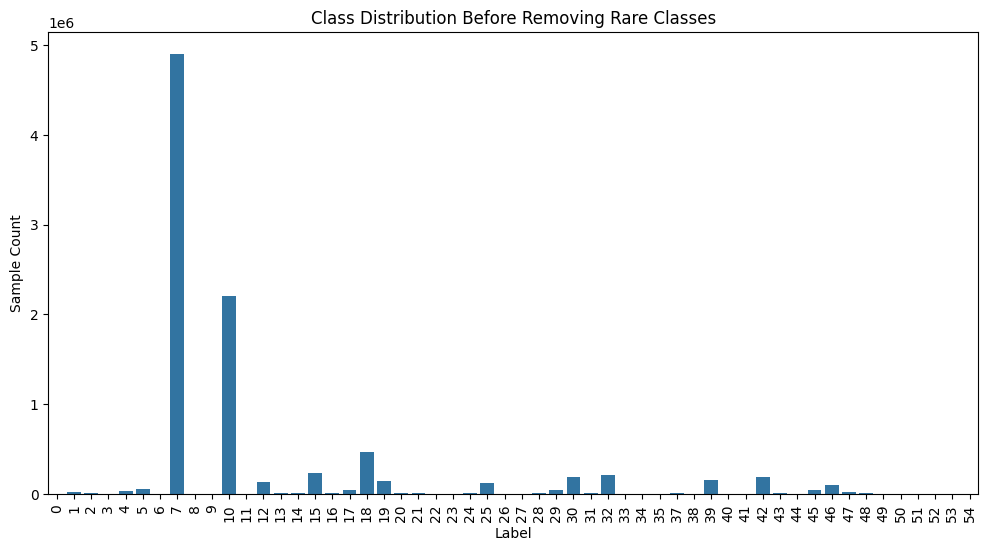

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=90)
plt.title("Class Distribution Before Removing Rare Classes")
plt.ylabel("Sample Count")
plt.xlabel("Label")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)} samples")
print(f"Val:   {len(X_val)} samples")
print(f"Test:  {len(X_test)} samples")


Train: 6612322 samples
Val:   1416926 samples
Test:  1416927 samples


In [10]:
# When you first load the CSV
df_full = pd.read_csv("/content/dataset.csv", low_memory=False)

# Optional: preview
df_full.head()


protocol flow_duration  src_bytes  dst_bytes dst_port total_fwd_pkts  \
0      udp      0.001055      132.0      164.0       53            NaN   
1      udp      0.036133      528.0      304.0     1024            NaN   
2      udp      0.001119      146.0      178.0       53            NaN   
3      udp      0.001209      132.0      164.0       53            NaN   
4      udp      0.001169      146.0      178.0       53            NaN   

  total_bwd_pkts flow_bytes_s flow_pkts_s attack_type  
0            NaN          NaN         NaN         NaN  
1            NaN          NaN         NaN         NaN  
2            NaN          NaN         NaN         NaN  
3            NaN          NaN         NaN         NaN  
4            NaN          NaN         NaN         NaN

from matplotlib import pyplot as plt
_df_0['src_bytes'].plot(kind='hist', bins=20, title='src_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['dst_bytes'].plot(kind='hist', bins=20, title='dst_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('flow_duration').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('dst_port').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='src_bytes', y='dst_bytes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['src_bytes'].plot(kind='line', figsize=(8, 4), title='src_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['dst_bytes'].plot(kind='line', figsize=(8, 4), title='dst_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['dst_port'].value_counts()
    for x_label, grp in _df_7.groupby('flow_duration')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('flow_duration')
_ = plt.ylabel('dst_port')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['flow_duration'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='src_bytes', y='flow_duration', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['dst_port'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='src_bytes', y='dst_port', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['flow_duration'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='dst_bytes', y='flow_duration', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['dst_port'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='dst_bytes', y='dst_port', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

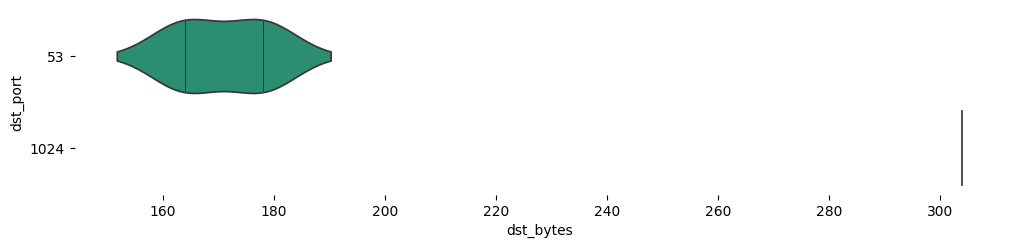

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['dst_port'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='dst_bytes', y='dst_port', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

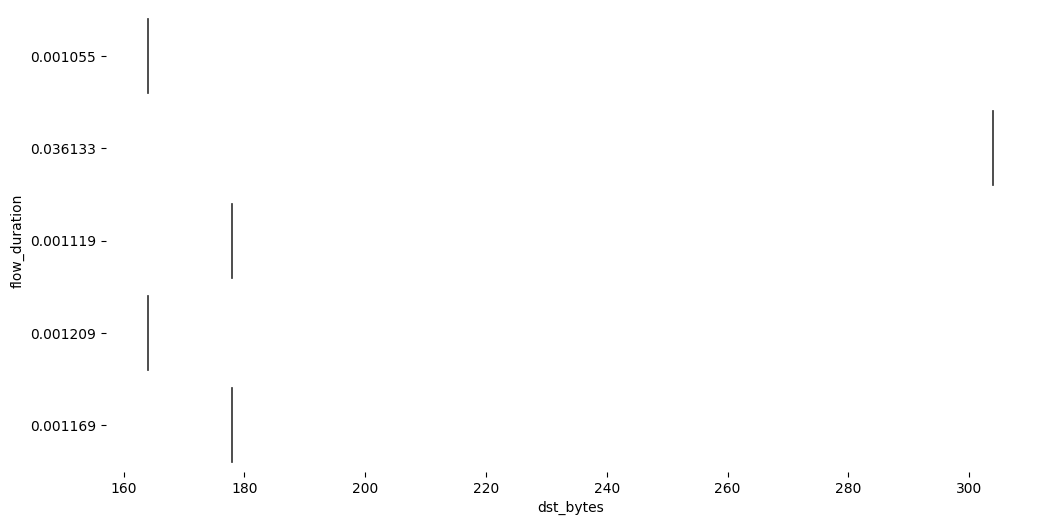

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['flow_duration'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='dst_bytes', y='flow_duration', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

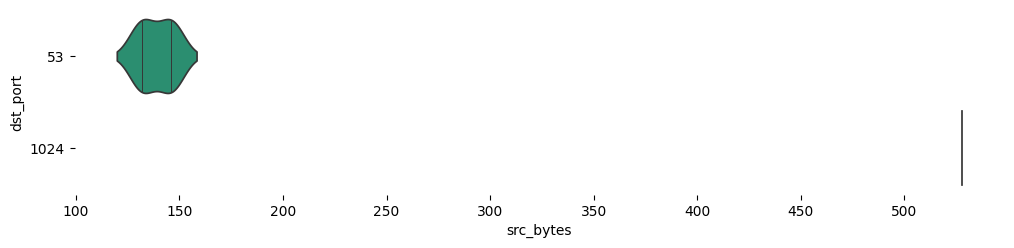

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['dst_port'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='src_bytes', y='dst_port', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

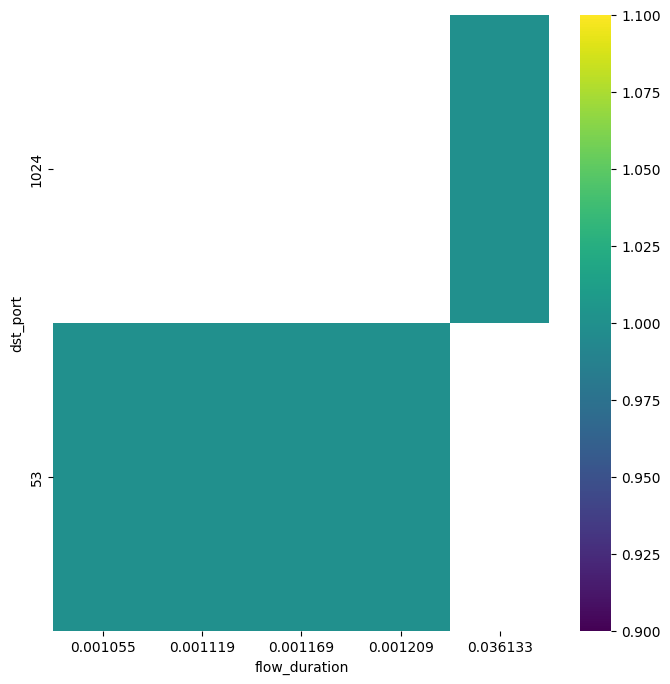

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['dst_port'].value_counts()
    for x_label, grp in _df_7.groupby('flow_duration')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('flow_duration')
_ = plt.ylabel('dst_port')

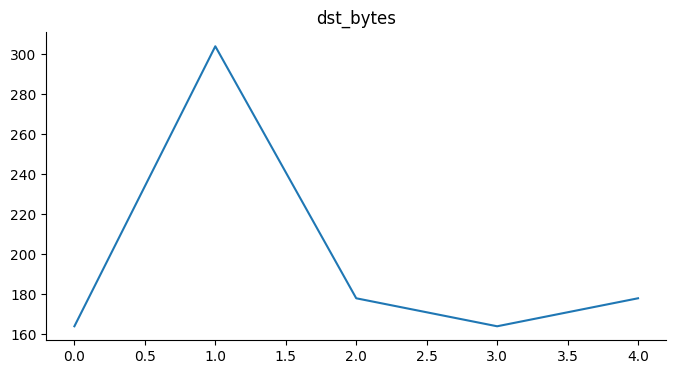

In [21]:
from matplotlib import pyplot as plt
_df_6['dst_bytes'].plot(kind='line', figsize=(8, 4), title='dst_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

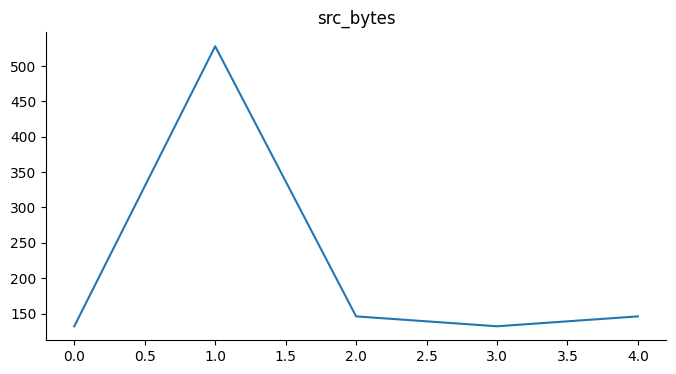

In [20]:
from matplotlib import pyplot as plt
_df_5['src_bytes'].plot(kind='line', figsize=(8, 4), title='src_bytes')
plt.gca().spines[['top', 'right']].set_visible(False)

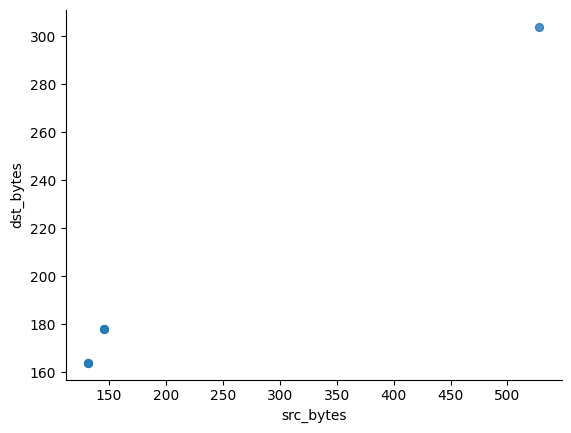

In [19]:
from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='src_bytes', y='dst_bytes', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

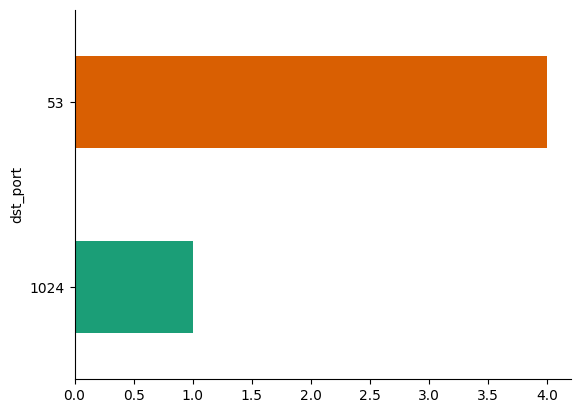

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('dst_port').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

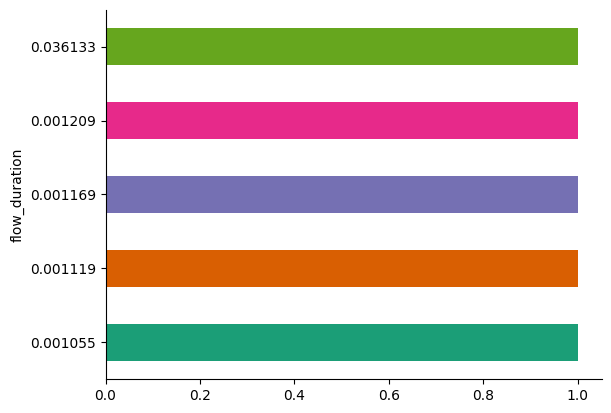

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('flow_duration').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

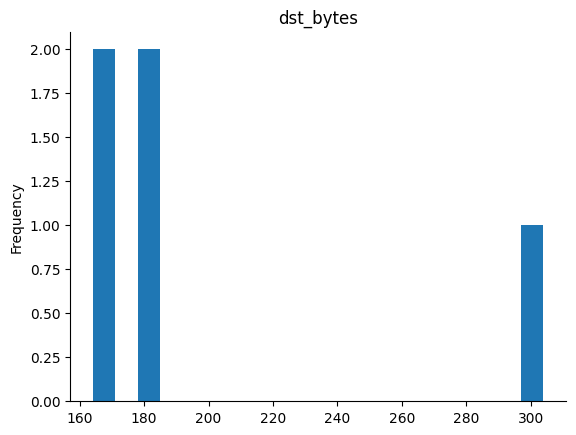

In [16]:
from matplotlib import pyplot as plt
_df_1['dst_bytes'].plot(kind='hist', bins=20, title='dst_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

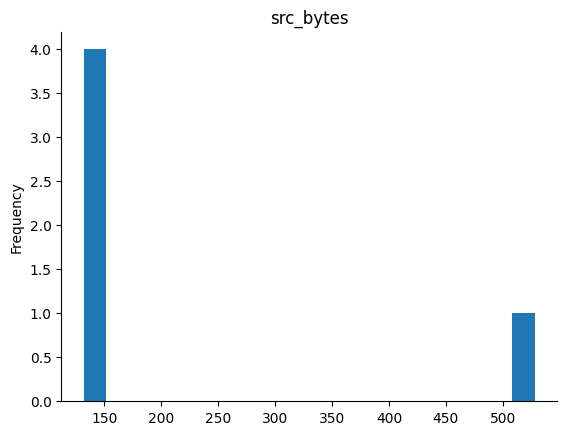

In [15]:
from matplotlib import pyplot as plt
_df_0['src_bytes'].plot(kind='hist', bins=20, title='src_bytes')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [28]:
# Fill missing attack labels with 'Unknown' for before-plot
df_full['attack_type'] = df_full['attack_type'].fillna('Unknown')
before_counts = df_full['attack_type'].value_counts()

# Reuse cleaned DataFrame
df_clean = df.copy()
df_clean['attack_type'] = le_target.inverse_transform(df_clean['label_enc'])
after_counts = df_clean['attack_type'].value_counts()


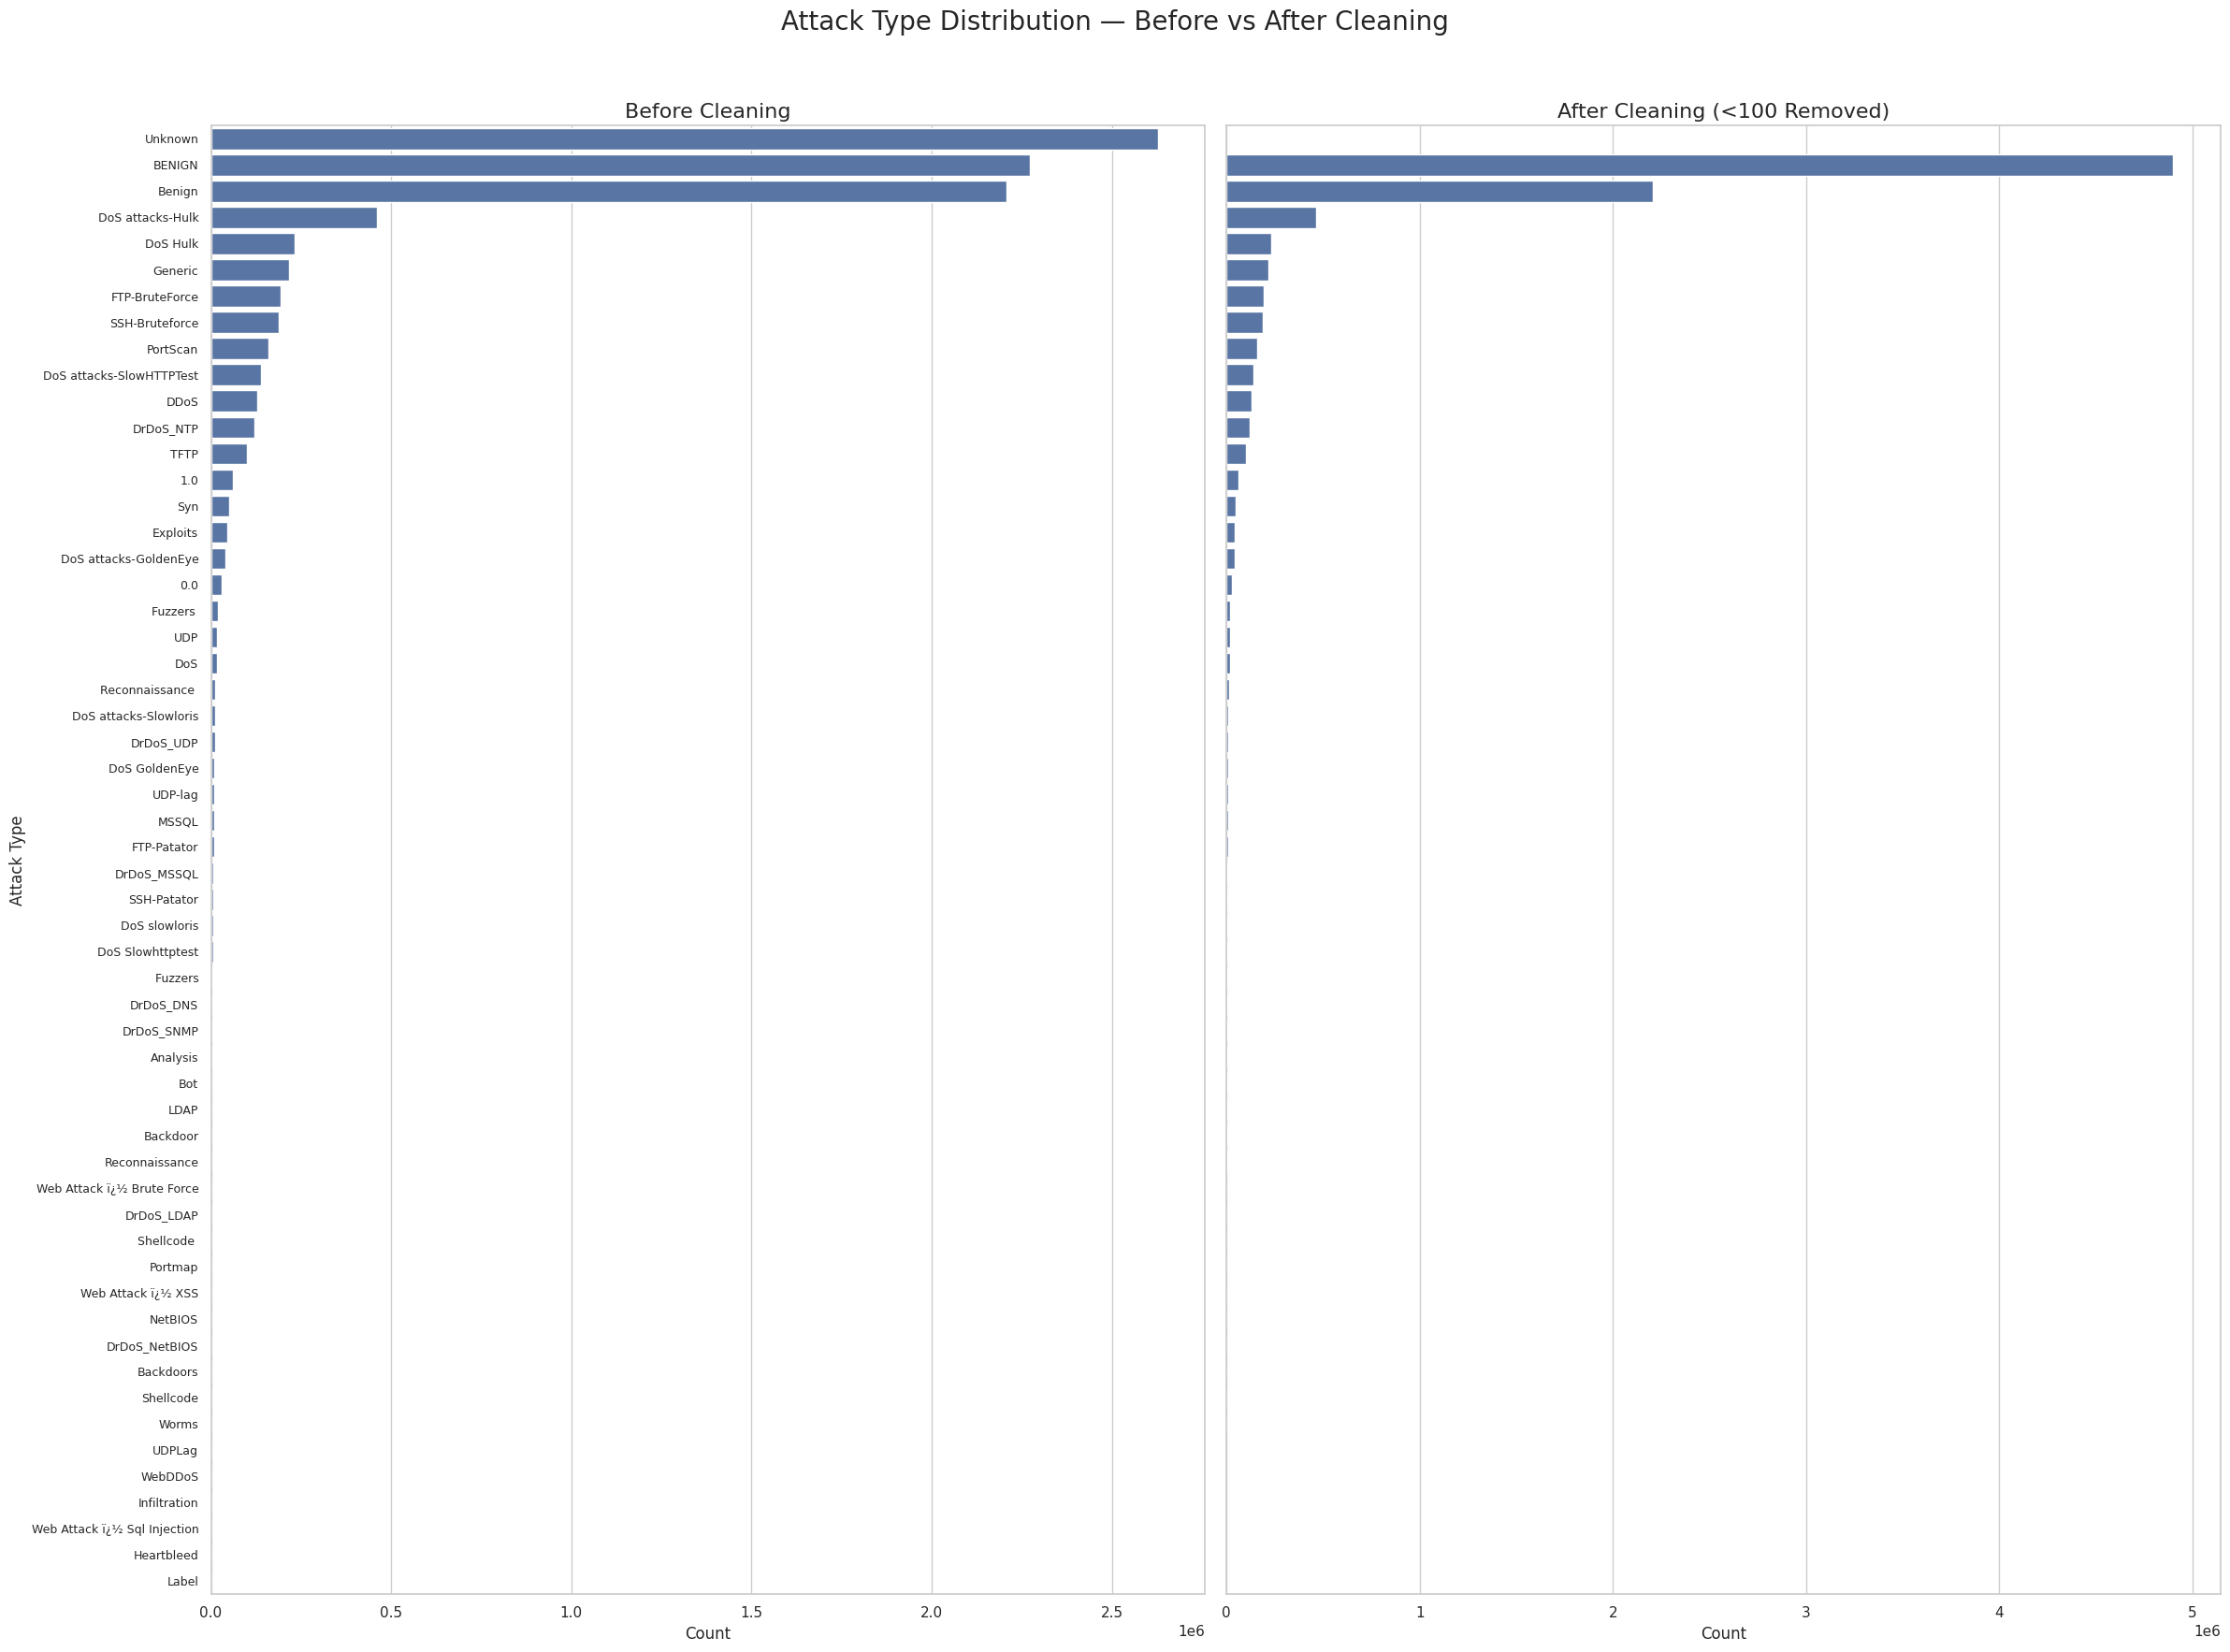

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(24, 18), sharey=True)

# Before Cleaning
sns.barplot(y=before_counts.index, x=before_counts.values, ax=axes[0])
axes[0].set_title("Before Cleaning", fontsize=16)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Attack Type")
axes[0].tick_params(axis='y', labelsize=9)

# After Cleaning
sns.barplot(y=after_counts.index, x=after_counts.values, ax=axes[1])
axes[1].set_title("After Cleaning (<100 Removed)", fontsize=16)
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].tick_params(axis='y', labelsize=9)

plt.suptitle("Attack Type Distribution — Before vs After Cleaning", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("attack_type_distribution_comparison.png", dpi=300)
plt.show()


 Histogram of Flow Duration / Byte Size

Box Plot of src_bytes per attack_type

Heatmap: Feature Correlation

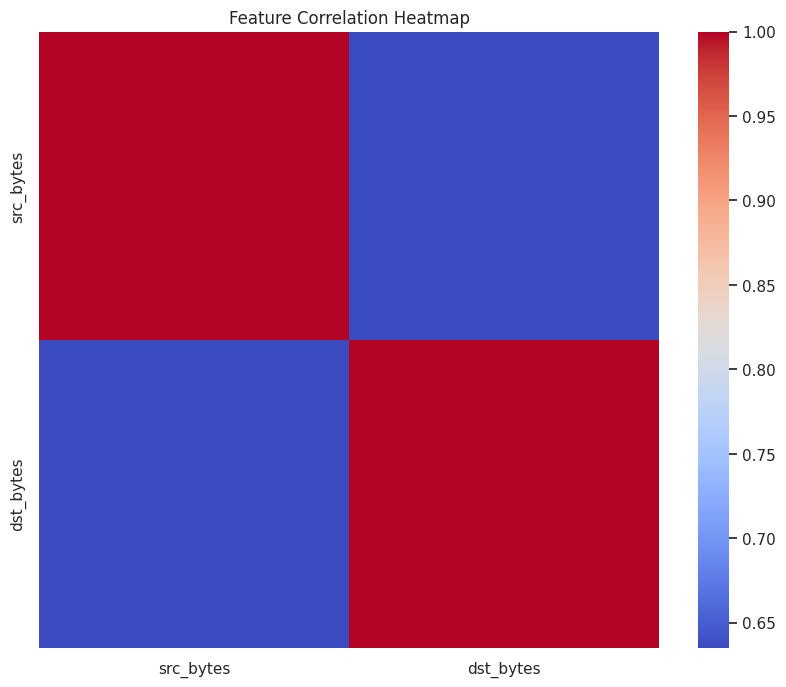

In [30]:
plt.figure(figsize=(10,8))
# Convert 'protocol' to numerical using Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean['protocol_enc'] = le.fit_transform(df_clean['protocol'])

# Select only numerical features for correlation
numerical_features = df_clean.select_dtypes(include=np.number).columns
df_clean_numeric = df_clean[numerical_features]

# Drop original 'protocol' and use the encoded one for correlation
sns.heatmap(df_clean_numeric.drop(columns=['label_enc', 'protocol_enc']).corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Class Imbalance Ratio Plot


In [31]:
attack_type_map = {
    "DoS Hulk": "DoS",
    "DoS attacks-Hulk": "DoS",
    "DoS attacks-GoldenEye": "DoS",
    "DoS GoldenEye": "DoS",
    "DoS Slowloris": "DoS",
    "DoS attacks-Slowloris": "DoS",
    "DoS attacks-SlowHTTPTest": "DoS",
    "DoS SlowHTTPTest": "DoS",

    "Web Attack − Brute Force": "Brute Force",
    "Brute Force": "Brute Force",
    "Web Attack − XSS": "XSS",
    "XSS": "XSS",

    "Web Attack − SQL Injection": "SQL Injection",
    "SQL Injection": "SQL Injection",

    "DDoS": "DDoS",
    "DDoS LOIC": "DDoS",
    "DDoS HOIC": "DDoS",

    # Extend as needed...
}


In [32]:
df_full['attack_type'] = df_full['attack_type'].replace(attack_type_map)


In [33]:
# Normalize all attack_type labels
df_full['attack_type'] = df_full['attack_type'].str.strip().str.title()
df_clean['attack_type'] = df_clean['attack_type'].str.strip().str.title()


In [34]:
# Normalize and then apply your label mapping
df_full['attack_type'] = df_full['attack_type'].str.strip().str.title()
df_clean['attack_type'] = df_clean['attack_type'].str.strip().str.title()

attack_type_map = {
    "Dos Hulk": "Dos",
    "Dos Attacks-Hulk": "Dos",
    "Dos Attacks-Goldeneye": "Dos",
    "Dos Goldeneye": "Dos",
    "Dos Slowloris": "Dos",
    "Dos Attacks-Slowloris": "Dos",
    "Dos Attacks-Slowhttptest": "Dos",
    "Dos Slowhttptest": "Dos",

    "Web Attack − Brute Force": "Brute Force",
    "Web Attack − Xss": "Xss",
    "Web Attack − Sql Injection": "Sql Injection",
    # Add more if needed
}

df_full['attack_type'] = df_full['attack_type'].replace(attack_type_map)
df_clean['attack_type'] = df_clean['attack_type'].replace(attack_type_map)


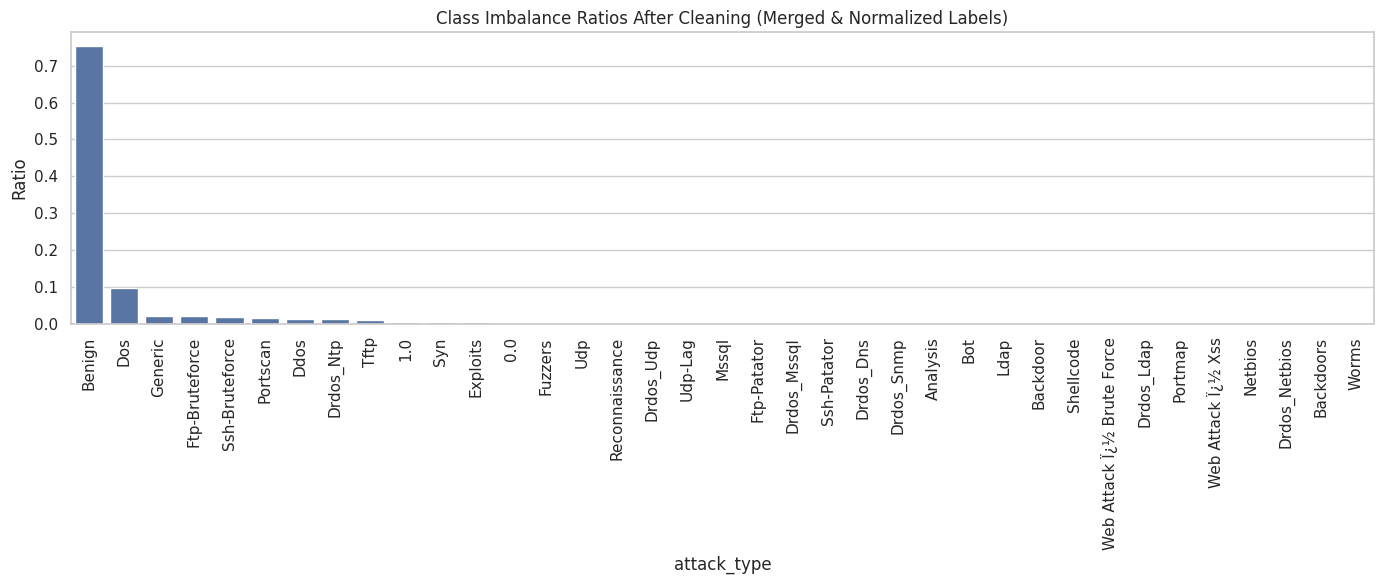

In [35]:
class_ratios = df_clean['attack_type'].value_counts(normalize=True)

plt.figure(figsize=(14, 6))
sns.barplot(x=class_ratios.index, y=class_ratios.values)
plt.xticks(rotation=90)
plt.title("Class Imbalance Ratios After Cleaning (Merged & Normalized Labels)")
plt.xlabel("attack_type")
plt.ylabel("Ratio")
plt.tight_layout()
plt.savefig("class_ratios_final_cleaned.png", dpi=300)
plt.show()


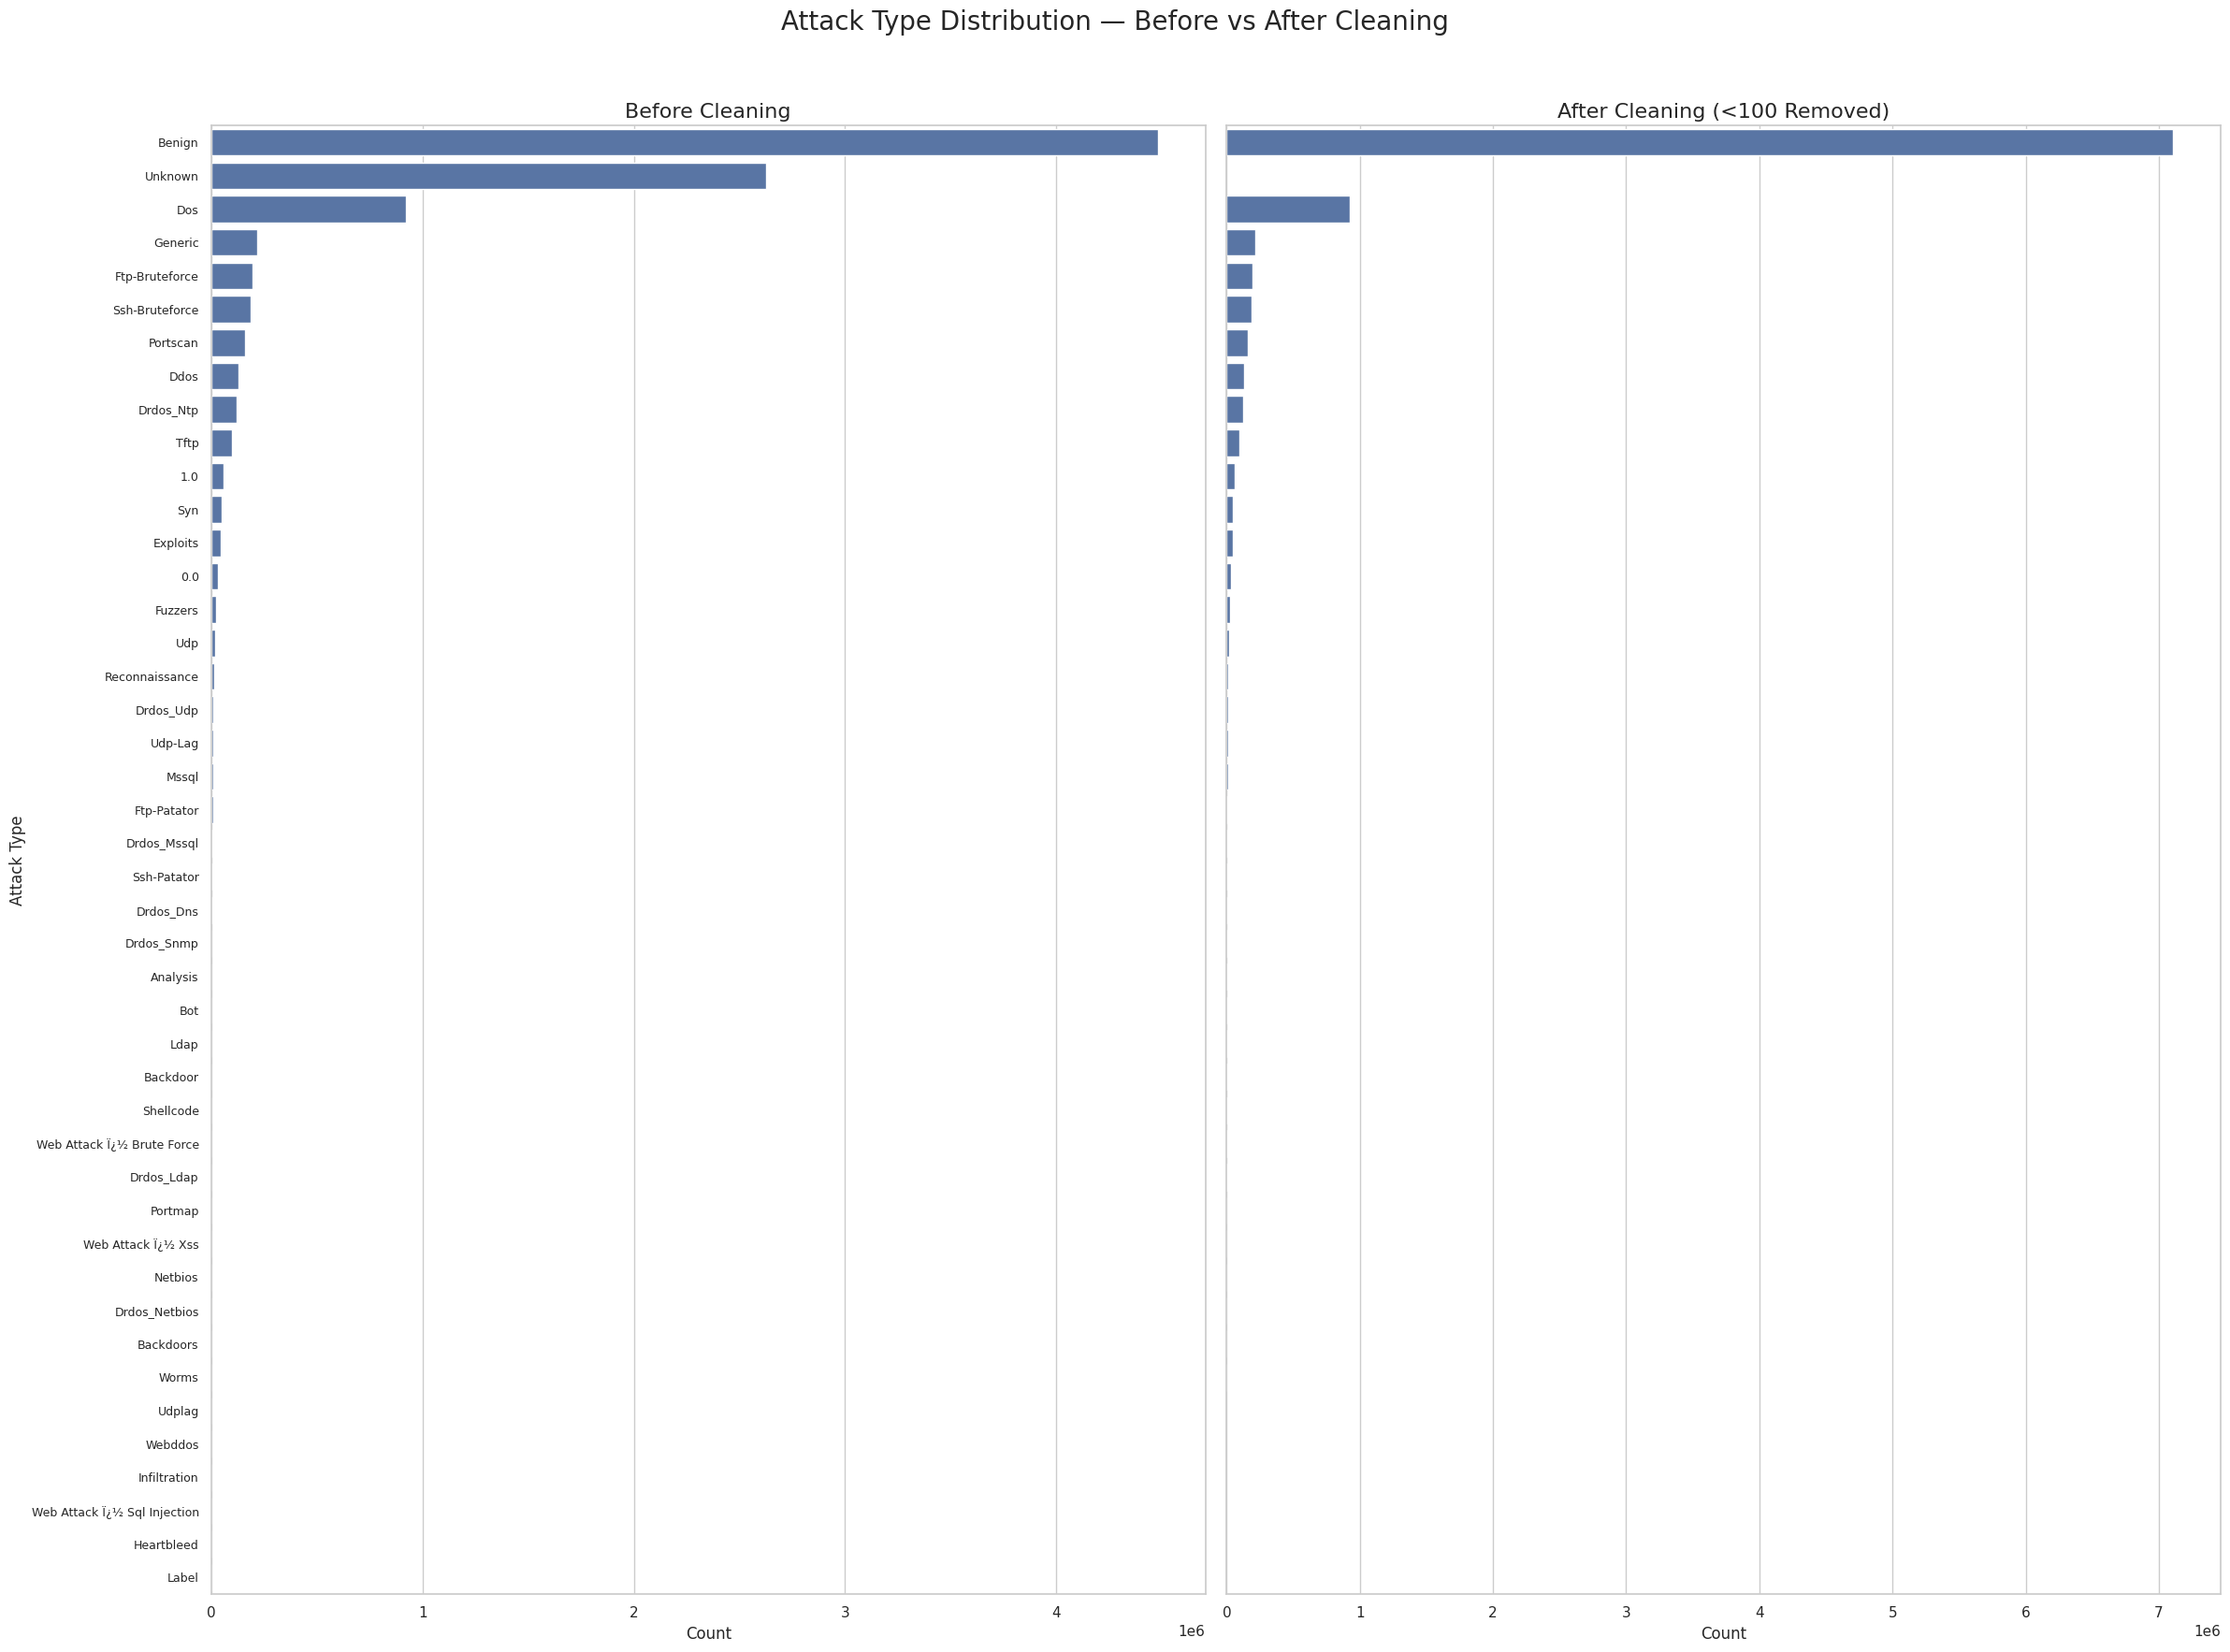

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🧹 Normalize attack_type in both DataFrames
df_full['attack_type'] = df_full['attack_type'].str.strip().str.title()
df_clean['attack_type'] = df_clean['attack_type'].str.strip().str.title()

# 🔁 Recompute counts after cleaning
before_counts = df_full['attack_type'].value_counts()
after_counts = df_clean['attack_type'].value_counts()

# 📊 Plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(24, 18), sharey=True)

# BEFORE Cleaning
sns.barplot(y=before_counts.index, x=before_counts.values, ax=axes[0])
axes[0].set_title("Before Cleaning", fontsize=16)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Attack Type")
axes[0].tick_params(axis='y', labelsize=9)

# AFTER Cleaning
sns.barplot(y=after_counts.index, x=after_counts.values, ax=axes[1])
axes[1].set_title("After Cleaning (<100 Removed)", fontsize=16)
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")
axes[1].tick_params(axis='y', labelsize=9)

# Overall layout
plt.suptitle("Attack Type Distribution — Before vs After Cleaning", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("attack_type_distribution_comparison_cleaned.png", dpi=300)
plt.show()


In [37]:
from sklearn.preprocessing import LabelEncoder

X = X.copy()
if 'protocol' in X.columns:
    le_proto = LabelEncoder()
    X['protocol'] = le_proto.fit_transform(X['protocol'])


In [38]:
# prompt: save encoded file as new csv

# Assuming 'df_clean' is your cleaned DataFrame with 'label_enc' column
df_clean.to_csv('encoded_dataset.csv', index=False)


In [39]:
from sklearn.preprocessing import LabelEncoder

if 'protocol' in X_train.columns:
    le_proto = LabelEncoder()
    X_train['protocol'] = le_proto.fit_transform(X_train['protocol'])
    X_val['protocol'] = le_proto.transform(X_val['protocol'])
    X_test['protocol'] = le_proto.transform(X_test['protocol'])


In [40]:
non_numeric_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: ['flow_duration', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']


In [41]:
for col in ['flow_duration', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')



In [42]:
for col in ['flow_duration', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)
    X_val[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)


In [43]:
import numpy as np

print("Infinite values in X_train:", np.isinf(X_train).sum().sum())
print("Very large values (>1e10):", (X_train > 1e10).sum().sum())


Infinite values in X_train: 14627
Very large values (>1e10): 14627


In [44]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)


In [45]:
X_train = X_train.fillna(X_train.median())
X_val   = X_val.fillna(X_train.median())  # use train's median to avoid leakage
X_test  = X_test.fillna(X_train.median())


In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)



In [47]:
# Convert back to DataFrames before saving
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_df   = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_df  = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add encoded labels
X_train_df['label'] = y_train.values
X_val_df['label']   = y_val.values
X_test_df['label']  = y_test.values


In [48]:
X_train_df.to_csv("train_scaled.csv", index=False)
X_val_df.to_csv("val_scaled.csv", index=False)
X_test_df.to_csv("test_scaled.csv", index=False)

print("✅ Saved: train_scaled.csv, val_scaled.csv, test_scaled.csv")


✅ Saved: train_scaled.csv, val_scaled.csv, test_scaled.csv


In [49]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Second split: 15% val, 15% test from 30%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [50]:
import joblib

joblib.dump(scaler, "standard_scaler.pkl")
joblib.dump(le_target, "label_encoder.pkl")


['label_encoder.pkl']

In [51]:
print("Train:\n", y_train.value_counts(normalize=True))
print("Val:\n", y_val.value_counts(normalize=True))
print("Test:\n", y_test.value_counts(normalize=True))


Train:
 label_enc
7     0.518751
10    0.233778
18    0.048899
15    0.024462
32    0.022812
30    0.020470
42    0.019859
39    0.016825
19    0.014809
12    0.013553
25    0.012848
46    0.010472
5     0.006364
45    0.005227
29    0.004713
17    0.004394
4     0.003176
1     0.002032
47    0.001915
13    0.001731
2     0.001295
20    0.001163
28    0.001103
14    0.001090
48    0.000939
37    0.000902
31    0.000840
24    0.000658
43    0.000624
21    0.000614
16    0.000582
0     0.000535
22    0.000388
27    0.000288
6     0.000283
11    0.000208
35    0.000202
8     0.000190
41    0.000186
50    0.000160
23    0.000152
3     0.000136
40    0.000073
52    0.000069
38    0.000068
26    0.000063
9     0.000057
44    0.000024
54    0.000018
Name: proportion, dtype: float64
Val:
 label_enc
7     0.518751
10    0.233778
18    0.048900
15    0.024462
32    0.022811
30    0.020470
42    0.019858
39    0.016824
19    0.014809
12    0.013553
25    0.012848
46    0.010471
5     0.006364
45 

In [52]:
non_numeric_cols = X_train.select_dtypes(include='object').columns.tolist()
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: ['flow_duration', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']


In [53]:
# List of known numeric columns with invalid string values
cols_to_fix = ['flow_duration', 'dst_port', 'total_fwd_pkts', 'total_bwd_pkts', 'flow_bytes_s', 'flow_pkts_s']

# Convert to numeric (invalid values → NaN)
for col in cols_to_fix:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Replace NaN with median (from train set only)
for col in cols_to_fix:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)
    X_val[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)


In [54]:
print("NaNs per column in X_train:")
print(X_train.isna().sum())


NaNs per column in X_train:
protocol                0
flow_duration           0
src_bytes         4687243
dst_bytes         4687243
dst_port                0
total_fwd_pkts          0
total_bwd_pkts          0
flow_bytes_s            0
flow_pkts_s             0
dtype: int64


In [55]:
for col in ['src_bytes', 'dst_bytes']:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)
    X_val[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)


In [56]:
print("Remaining NaNs:", X_train.isna().sum().sum())


Remaining NaNs: 0


In [57]:
import numpy as np

print("Infs in X_train:", np.isinf(X_train).sum().sum())
print("Values > 1e10 in X_train:", (X_train > 1e10).sum().sum())


Infs in X_train: 14627
Values > 1e10 in X_train: 14627


In [58]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)


In [59]:
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())  # use train's median for consistency
X_test = X_test.fillna(X_train.median())


In [60]:
print("✅ NaNs remaining:", X_train.isna().sum().sum())
print("✅ Infs remaining:", np.isinf(X_train).sum().sum())


✅ NaNs remaining: 0
✅ Infs remaining: 0


In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [63]:
import joblib
joblib.dump(scaler, "standard_scaler.pkl")


['standard_scaler.pkl']

In [64]:
# Save compressed CSVs instead
X_train_df.to_csv("train_dl.csv.gz", index=False, compression="gzip")
X_val_df.to_csv("val_dl.csv.gz", index=False, compression="gzip")
X_test_df.to_csv("test_dl.csv.gz", index=False, compression="gzip")

print("✅ Saved compressed CSVs: train_dl.csv.gz, val_dl.csv.gz, test_dl.csv.gz")



✅ Saved compressed CSVs: train_dl.csv.gz, val_dl.csv.gz, test_dl.csv.gz


 Apply SMOTE with Timer & Parallel Jobs

In [67]:
from imblearn.over_sampling import SMOTE
import time

# Remove n_jobs parameter
smote = SMOTE(random_state=42)
start = time.time()
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
end = time.time()
print(f"✅ SMOTE completed in {end - start:.2f} seconds.")

✅ SMOTE completed in 484.69 seconds.


In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_val_scaled      = scaler.transform(X_val)
X_test_scaled     = scaler.transform(X_test)


In [69]:
import joblib
joblib.dump(scaler, "standard_scaler.pkl")


['standard_scaler.pkl']

In [70]:
import pandas as pd

X_train_df = pd.DataFrame(X_train_sm_scaled, columns=X_train.columns)
X_val_df   = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_df  = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_df['label'] = y_train_sm
X_val_df['label']   = y_val.values
X_test_df['label']  = y_test.values


In [71]:
from google.colab import drive
drive.mount('/content/drive')

!cp train_dl.csv.gz /content/drive/MyDrive/
!cp val_dl.csv.gz /content/drive/MyDrive/
!cp test_dl.csv.gz /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Plot Class Distribution

In [74]:
import numpy as np
print("Unique labels after SMOTE:", np.unique(y_train_sm))
print("Total samples:", len(y_train_sm))


Unique labels after SMOTE: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 35 37 38 39 40 41 42 43 44 45 46 47 48 50 52
 54]
Total samples: 168077301


In [79]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(df['attack_type'])


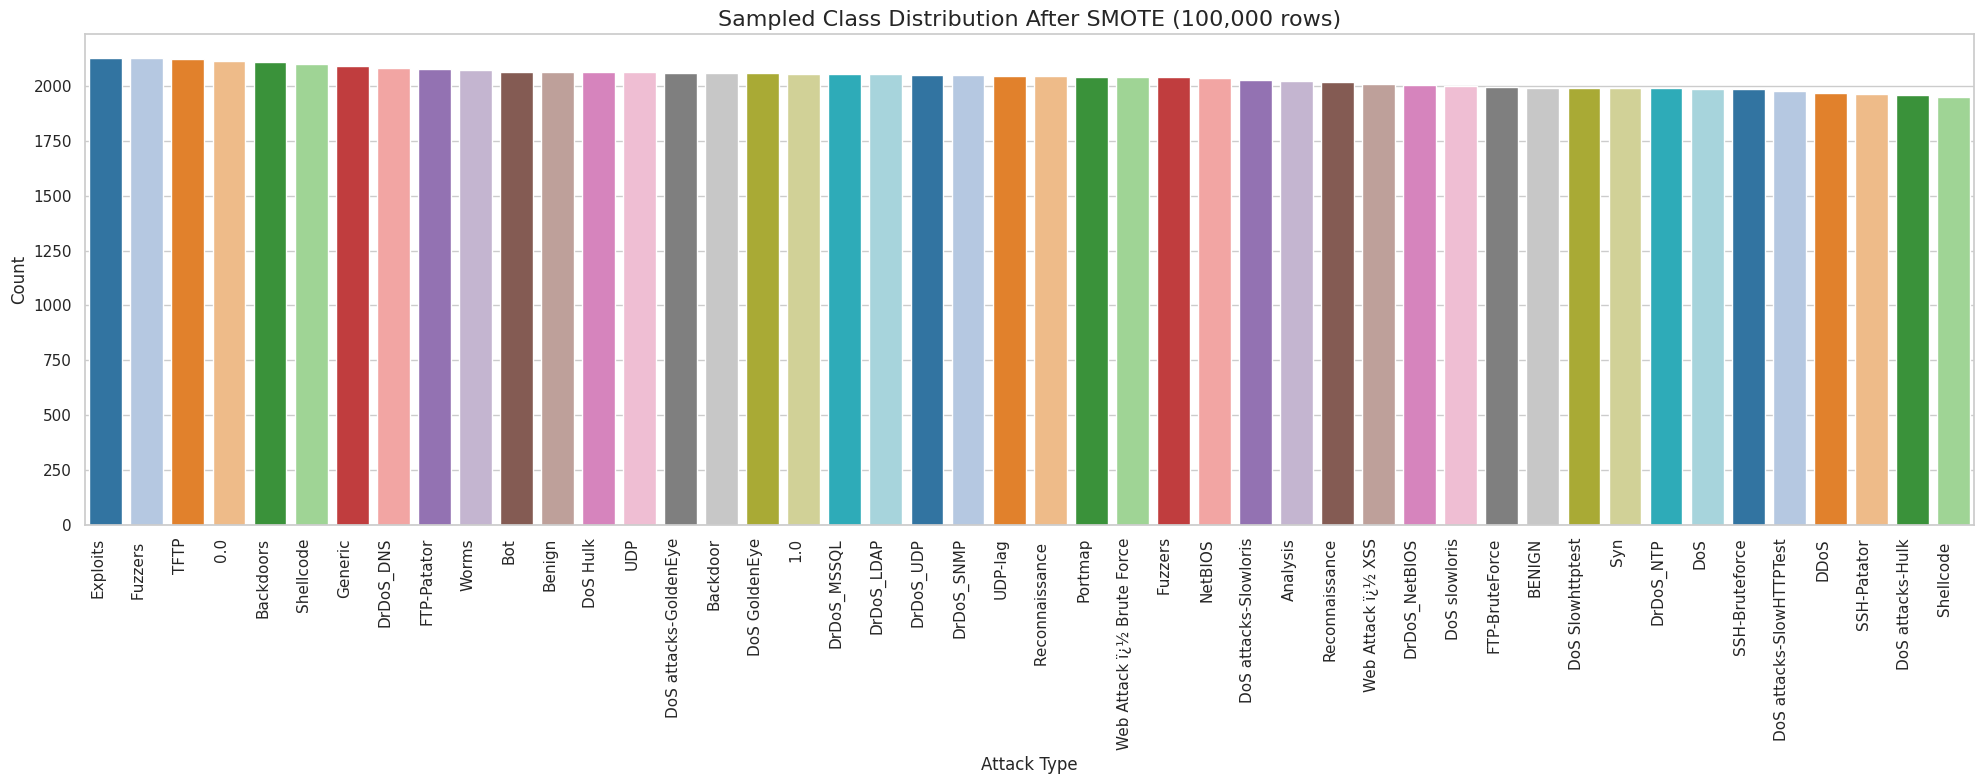

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Sample just 100,000 rows for plotting
y_sample = pd.Series(y_train_sm).sample(100_000, random_state=42)

# ✅ Map integer labels to attack names using your LabelEncoder
label_to_attack = dict(enumerate(le.classes_))
attack_names = y_sample.map(label_to_attack)

# ✅ Wrap into DataFrame for plotting
y_sample_df = pd.DataFrame({'attack_type': attack_names})

# ✅ Plot
plt.figure(figsize=(20, 8))
sns.countplot(data=y_sample_df, x='attack_type', order=y_sample_df['attack_type'].value_counts().index, palette='tab20')
plt.title("Sampled Class Distribution After SMOTE (100,000 rows)", fontsize=16)
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


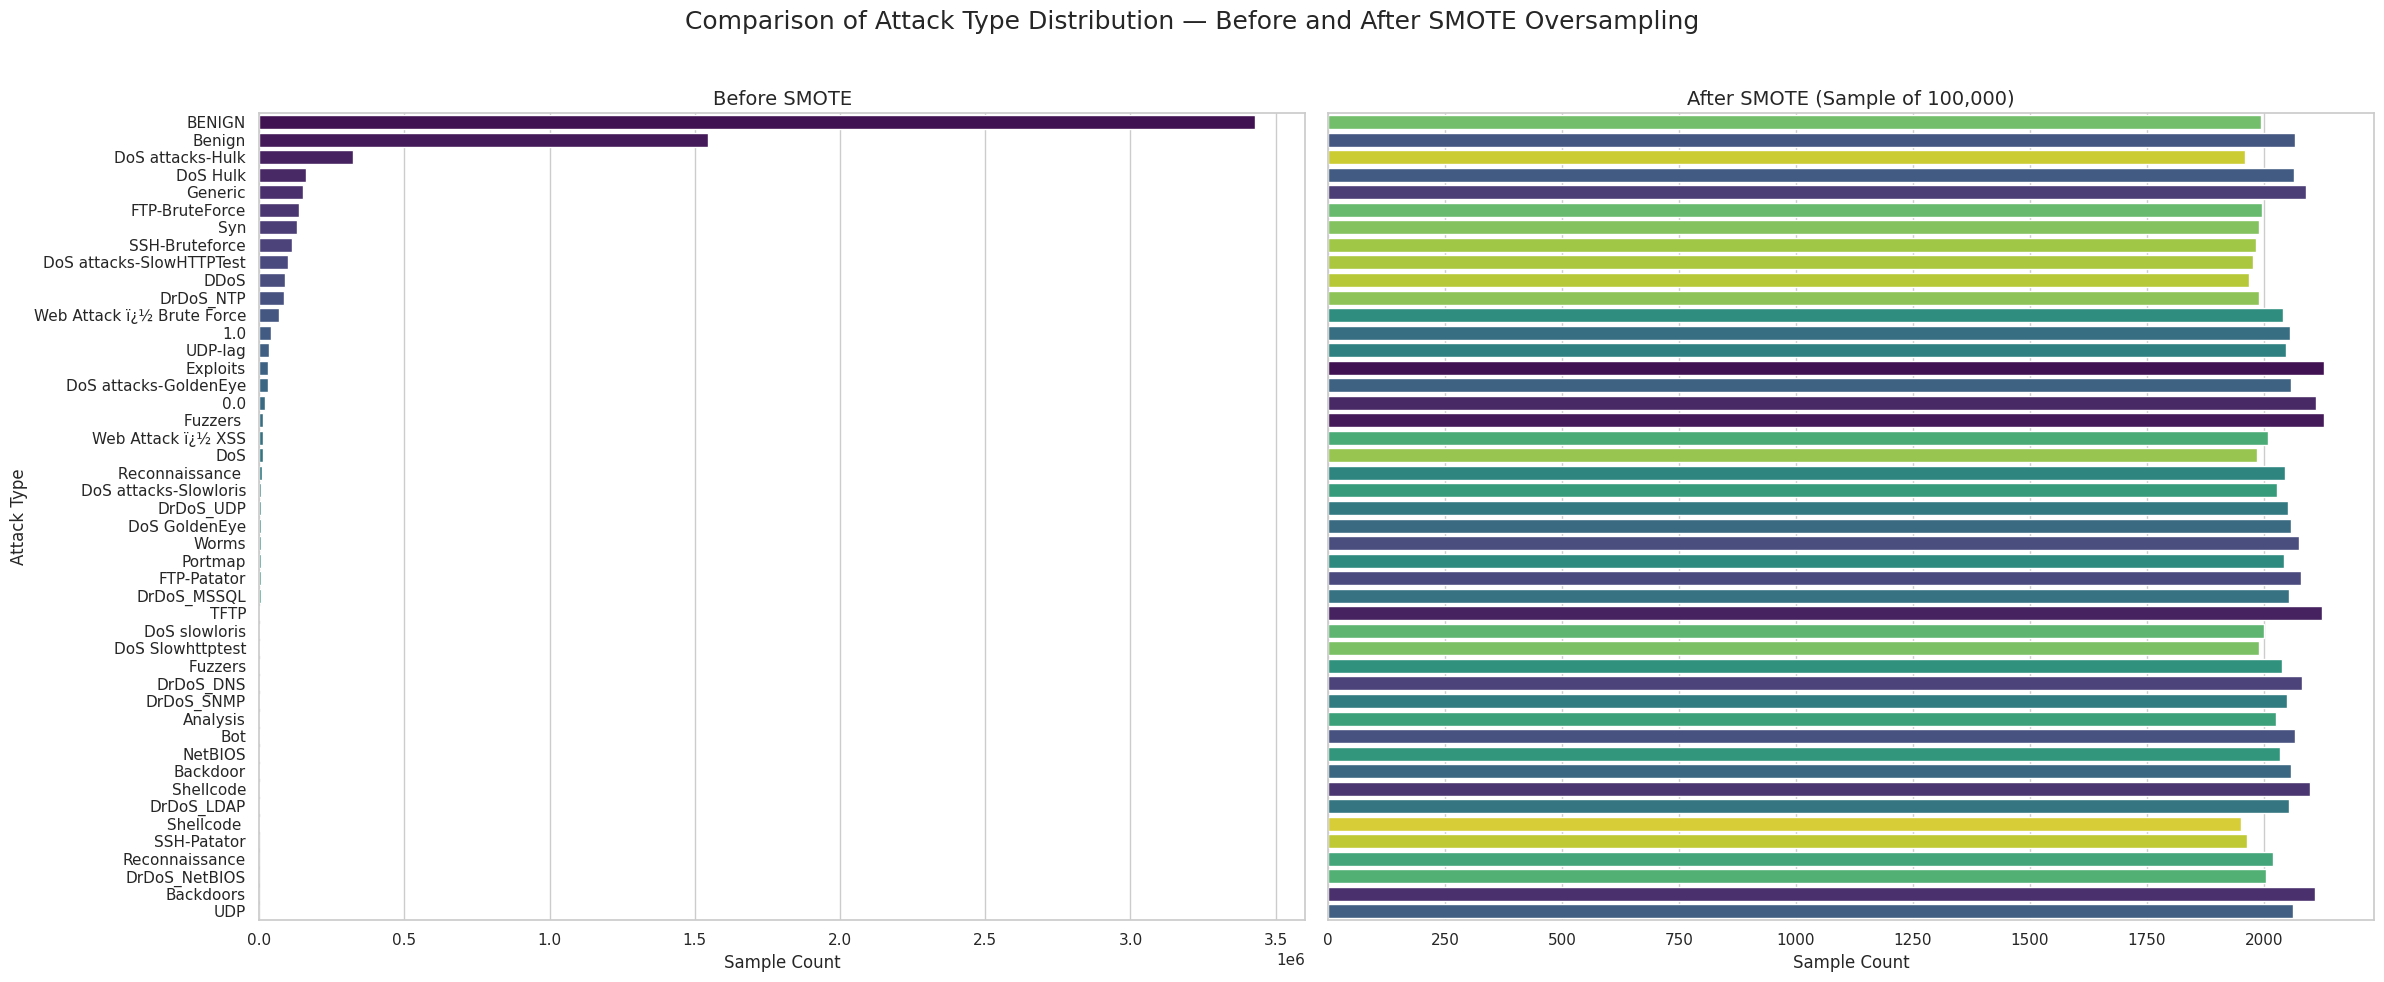

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 📌 Mapping label indices back to original attack type names
label_to_name = dict(enumerate(le.classes_))

# 🔹 Map encoded labels to attack type names
y_train_named = y_train.map(label_to_name)
y_sm_named_sample = pd.Series(y_train_sm).sample(100_000, random_state=42).map(label_to_name)

# 🔹 Create DataFrames for plotting
y_train_df = pd.DataFrame({'Attack Type': y_train_named})
y_sm_df = pd.DataFrame({'Attack Type': y_sm_named_sample})

# 🔹 Set plotting style
sns.set(style="whitegrid")

# 📊 Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

# ▶️ Before SMOTE
sns.countplot(data=y_train_df, y='Attack Type',
              order=y_train_df['Attack Type'].value_counts().index,
              ax=axes[0], palette="viridis")
axes[0].set_title("Before SMOTE", fontsize=14)
axes[0].set_xlabel("Sample Count", fontsize=12)
axes[0].set_ylabel("Attack Type", fontsize=12)

# ▶️ After SMOTE (sampled)
sns.countplot(data=y_sm_df, y='Attack Type',
              order=y_sm_df['Attack Type'].value_counts().index,
              ax=axes[1], palette="viridis")
axes[1].set_title("After SMOTE (Sample of 100,000)", fontsize=14)
axes[1].set_xlabel("Sample Count", fontsize=12)
axes[1].set_ylabel("")  # Remove y-axis label to avoid repetition

# 🔠 Overall plot title
plt.suptitle("Comparison of Attack Type Distribution — Before and After SMOTE Oversampling", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 💾 Optional: Save as PNG for thesis figures
plt.savefig("attack_distribution_before_after_smote.png", dpi=300)

# 📊 Show plot
plt.show()


Time Series or Flow Duration **Distribution**



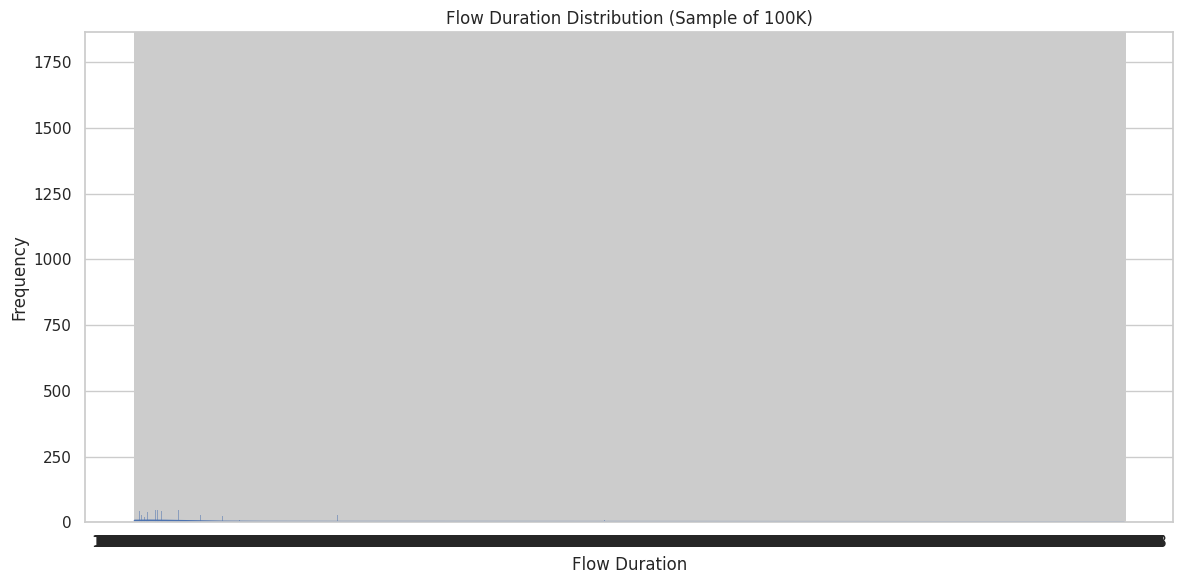

In [85]:
plt.figure(figsize=(12, 6))
sns.histplot(df['flow_duration'].sample(100_000, random_state=42), bins=100, kde=True)
plt.title("Flow Duration Distribution (Sample of 100K)")
plt.xlabel("Flow Duration")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



 Feature Correlation Heatmap

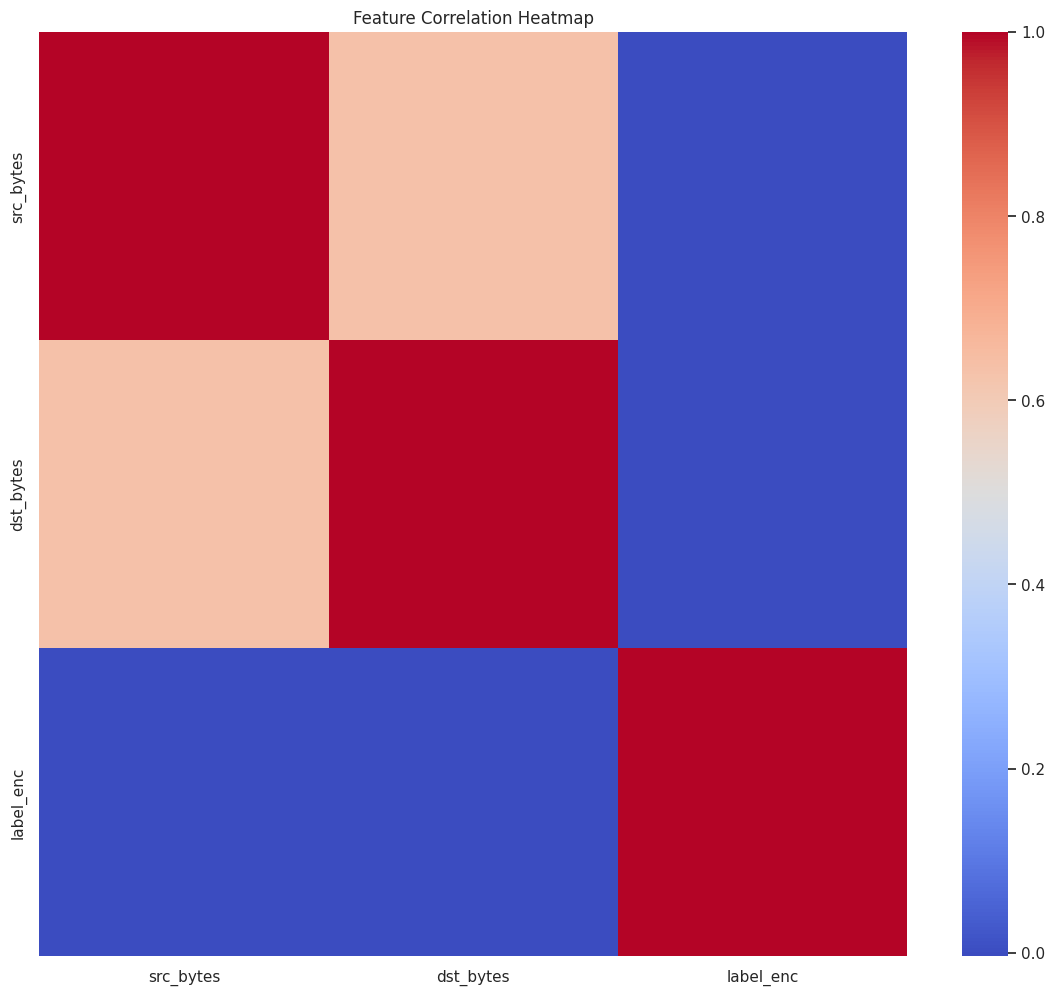

In [86]:
plt.figure(figsize=(14, 12))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


t-SNE or PCA 2D Visualization

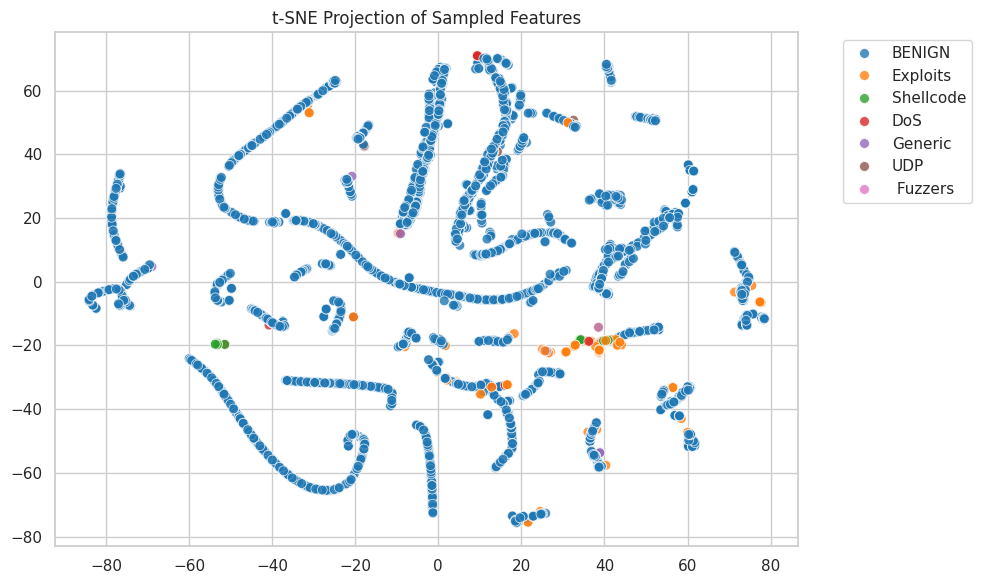

In [89]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Scale
# 1. Create a copy of X to avoid modifying the original DataFrame
X_temp = X[:5000].copy()

# 2. If 'protocol' is in the DataFrame, encode it to numerical
if 'protocol' in X_temp.columns:
    le = LabelEncoder()
    X_temp['protocol'] = le.fit_transform(X_temp['protocol'])

# 3. Convert hexadecimal strings to integers before scaling
X_temp = X_temp.apply(pd.to_numeric, errors='coerce').fillna(0) # Convert hex to int and fill NaN with 0

# 4. Now apply StandardScaler to the modified DataFrame
X_scaled = StandardScaler().fit_transform(X_temp)
y_sample = y[:5000]

# Reduce
X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=pd.Series(y_sample).map(label_to_name), palette='tab10', s=50, alpha=0.8)
plt.title("t-SNE Projection of Sampled Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Missing Data Heatmap

<Axes: >

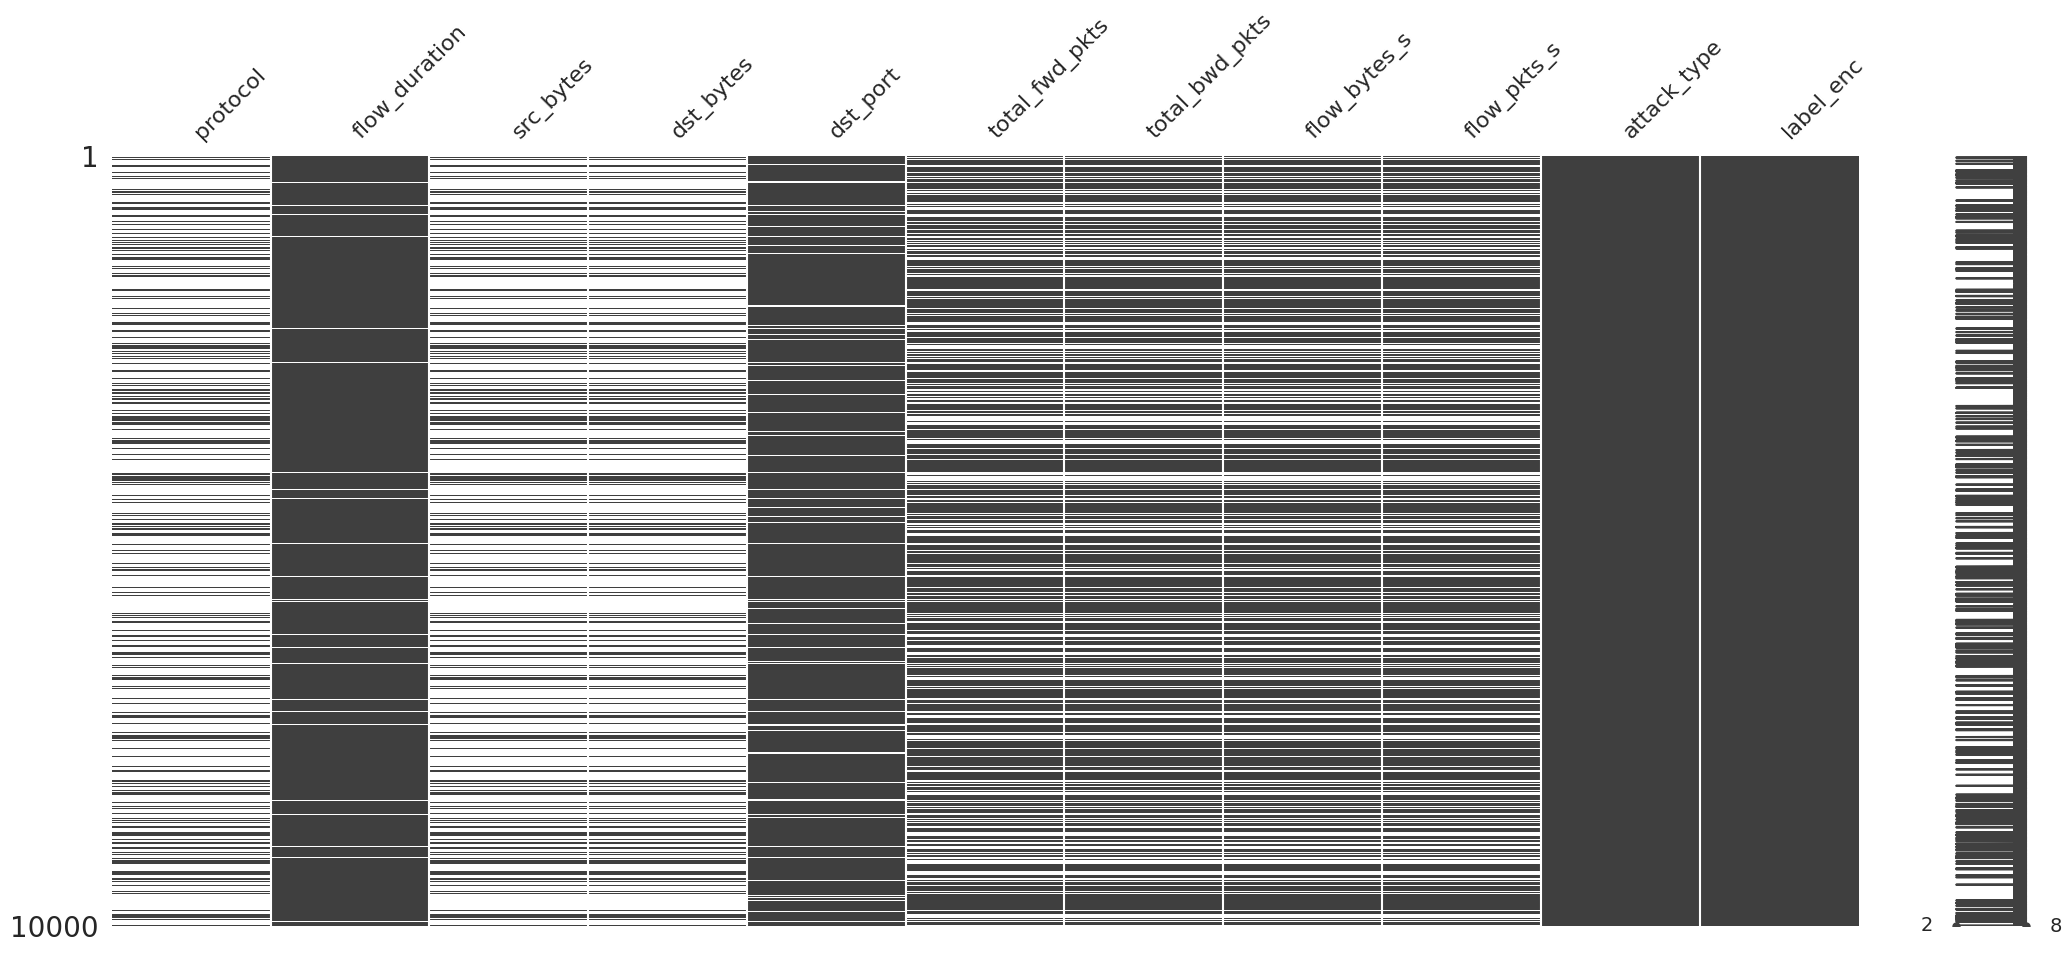

In [90]:
import missingno as msno
msno.matrix(df.sample(10000))


Feature Value Distributions (Histogram Grid)

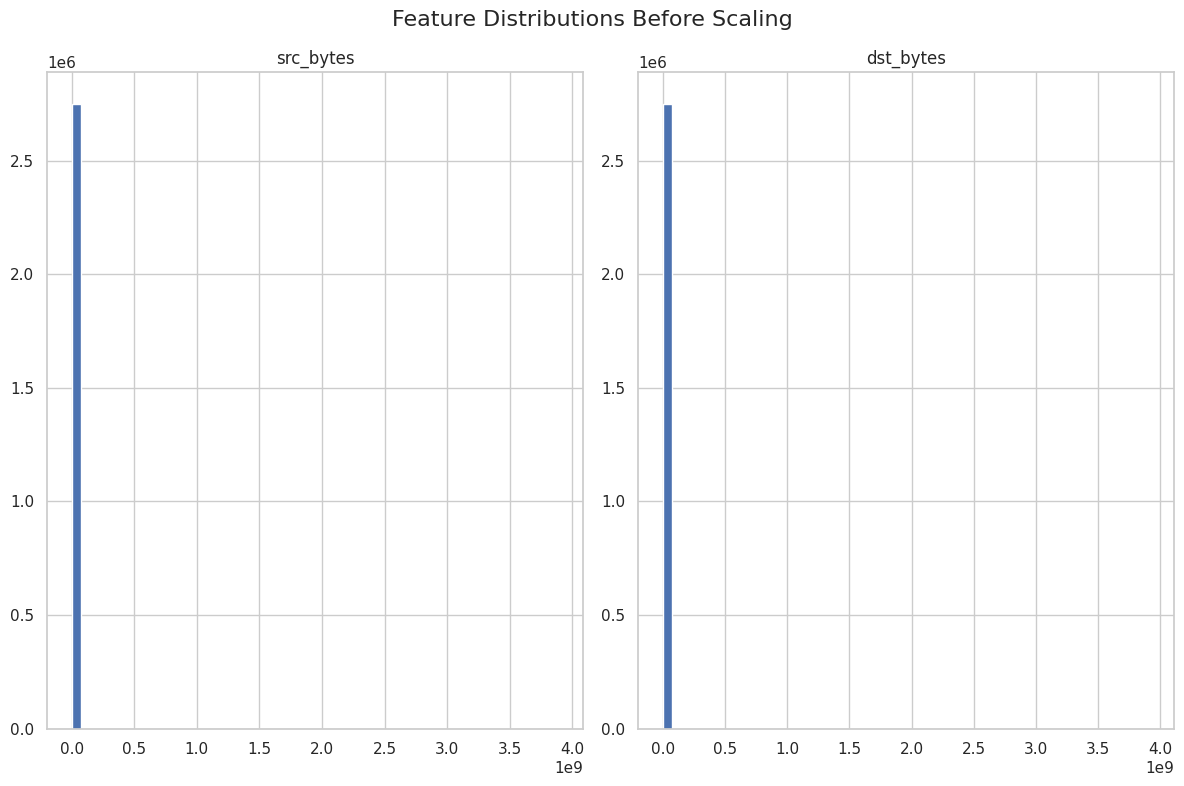

In [91]:
important_features = ['flow_duration', 'src_bytes', 'dst_bytes', 'flow_bytes_s', 'total_fwd_pkts', 'total_bwd_pkts']

df[important_features].hist(bins=50, figsize=(12, 8))
plt.suptitle("Feature Distributions Before Scaling", fontsize=16)
plt.tight_layout()
plt.show()


Class Imbalance Before SMOTE (Pie Chart)

 t-SNE / PCA Clustering Visualization

Number of NaNs in X_scaled: 20000


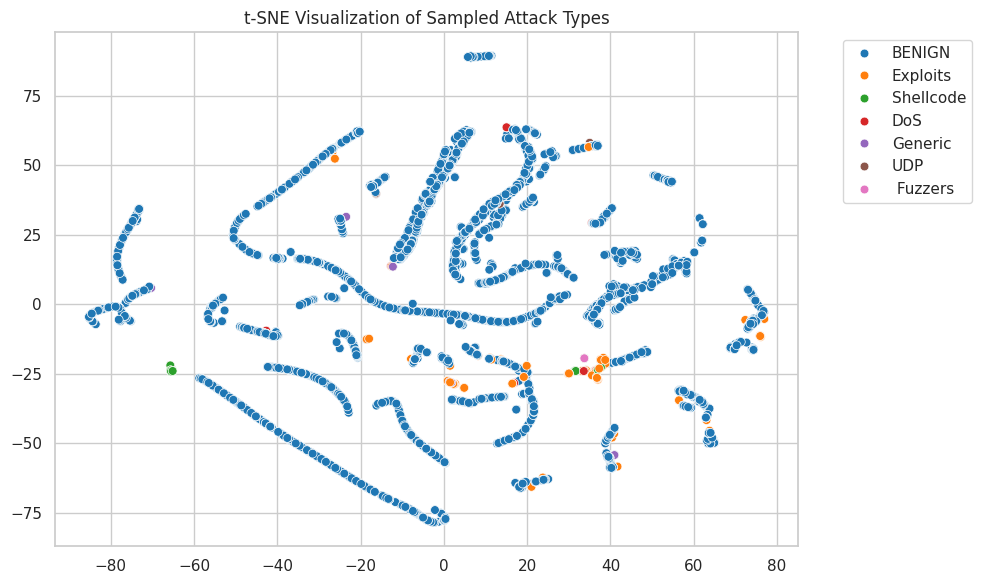

In [97]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import pandas as pd  # Import pandas if not already imported

# 1. Create a copy of X to avoid modifying the original DataFrame
X_temp = X[:5000].copy()

# 2. If 'protocol' is in the DataFrame, encode it to numerical
if 'protocol' in X_temp.columns:
    le = LabelEncoder()
    X_temp['protocol'] = le.fit_transform(X_temp['protocol'])

# 3. Convert hexadecimal strings in 'dst_port' to integers
X_temp['dst_port'] = X_temp['dst_port'].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)

# 4. Convert all columns to numeric (invalid values → NaN)
X_temp = X_temp.apply(pd.to_numeric, errors='coerce')

# 5. Fill NaN with median (from this subset only)
X_temp = X_temp.fillna(X_temp.median())

# 6. Now apply StandardScaler to the modified DataFrame
X_scaled = StandardScaler().fit_transform(X_temp)
y_sample = y[:5000]

# ***DIAGNOSE***: Print number of NaNs to check
print("Number of NaNs in X_scaled:", np.isnan(X_scaled).sum())

# ***FIX***: Impute NaNs using SimpleImputer if any are found
if np.isnan(X_scaled).sum() > 0:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')  # Or other strategies like 'mean', 'most_frequent'
    X_scaled = imputer.fit_transform(X_scaled)


# ... (rest of your t-SNE code)
X_embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=pd.Series(y[:5000]).map(label_to_name), palette='tab10', s=40)
plt.title("t-SNE Visualization of Sampled Attack Types")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Correlation Heatmap (Features)


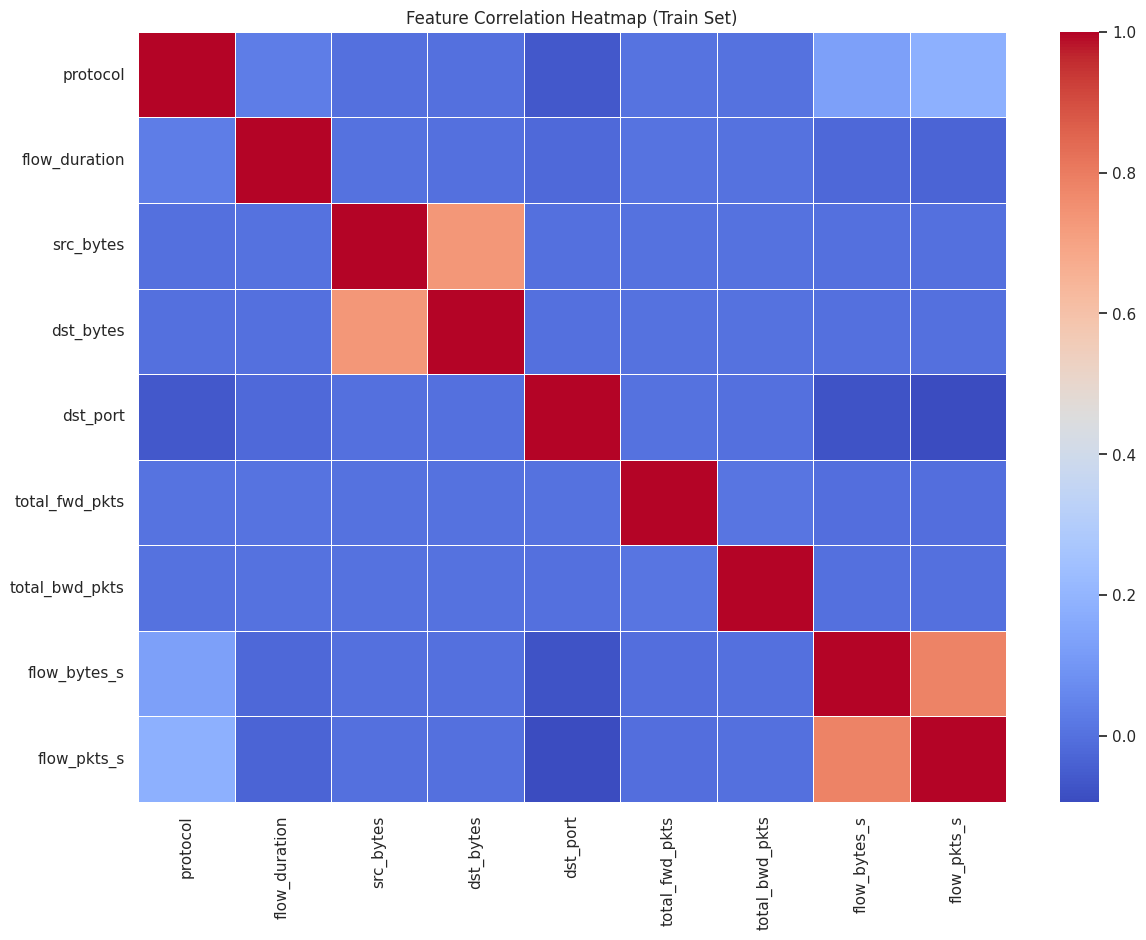

In [98]:
plt.figure(figsize=(14, 10))
sns.heatmap(pd.DataFrame(X_train_sm, columns=X.columns).corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap (Train Set)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    df[top_features].corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    annot_kws={"size": 10, "color": "black"}
)

plt.title("Feature Correlation Heatmap", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("feature_correlation_heatmap_annotated.png", dpi=300)
plt.show()


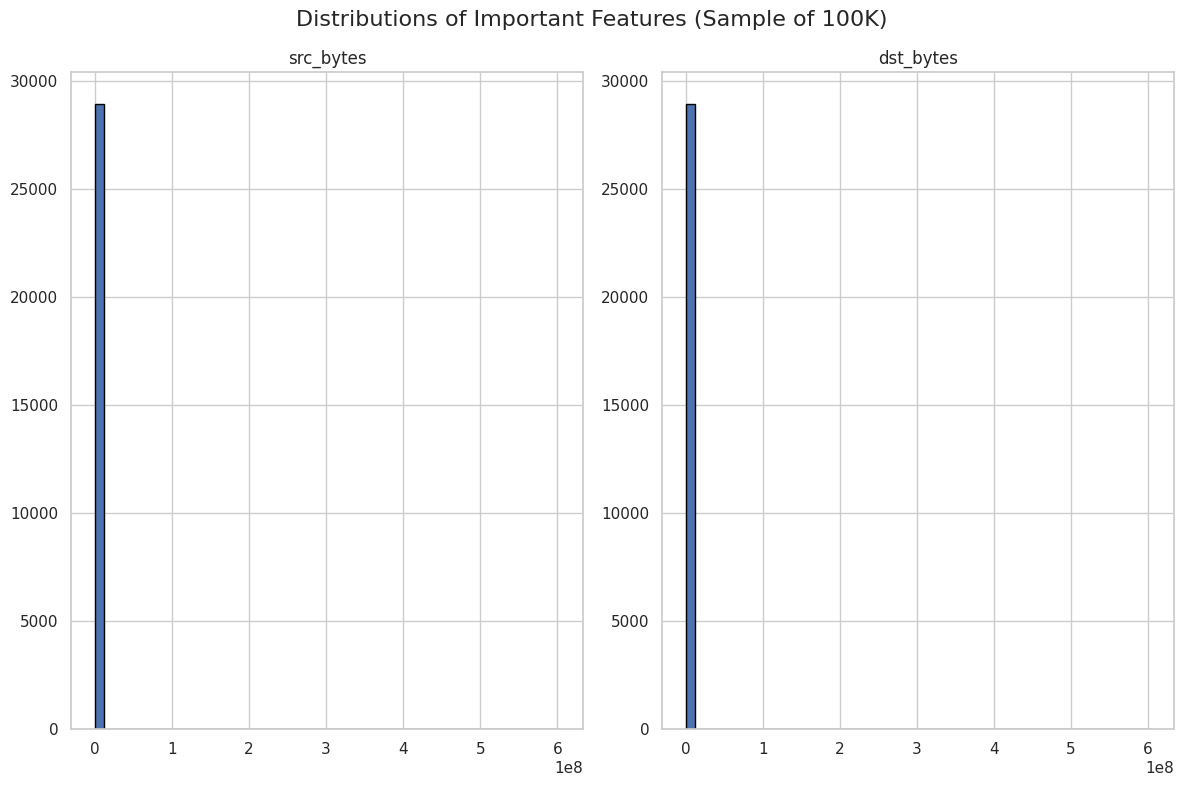

In [99]:
important_features = ['flow_duration', 'src_bytes', 'dst_bytes', 'flow_bytes_s', 'total_fwd_pkts', 'total_bwd_pkts']
df[important_features].sample(100_000).hist(bins=50, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distributions of Important Features (Sample of 100K)", fontsize=16)
plt.tight_layout()
plt.show()


In [104]:
df[top_features].isna().sum()


flow_duration      287421
src_bytes         6695085
dst_bytes         6695085
total_fwd_pkts    3038511
total_bwd_pkts    3038511
flow_bytes_s      3045709
flow_pkts_s       3038511
dtype: int64

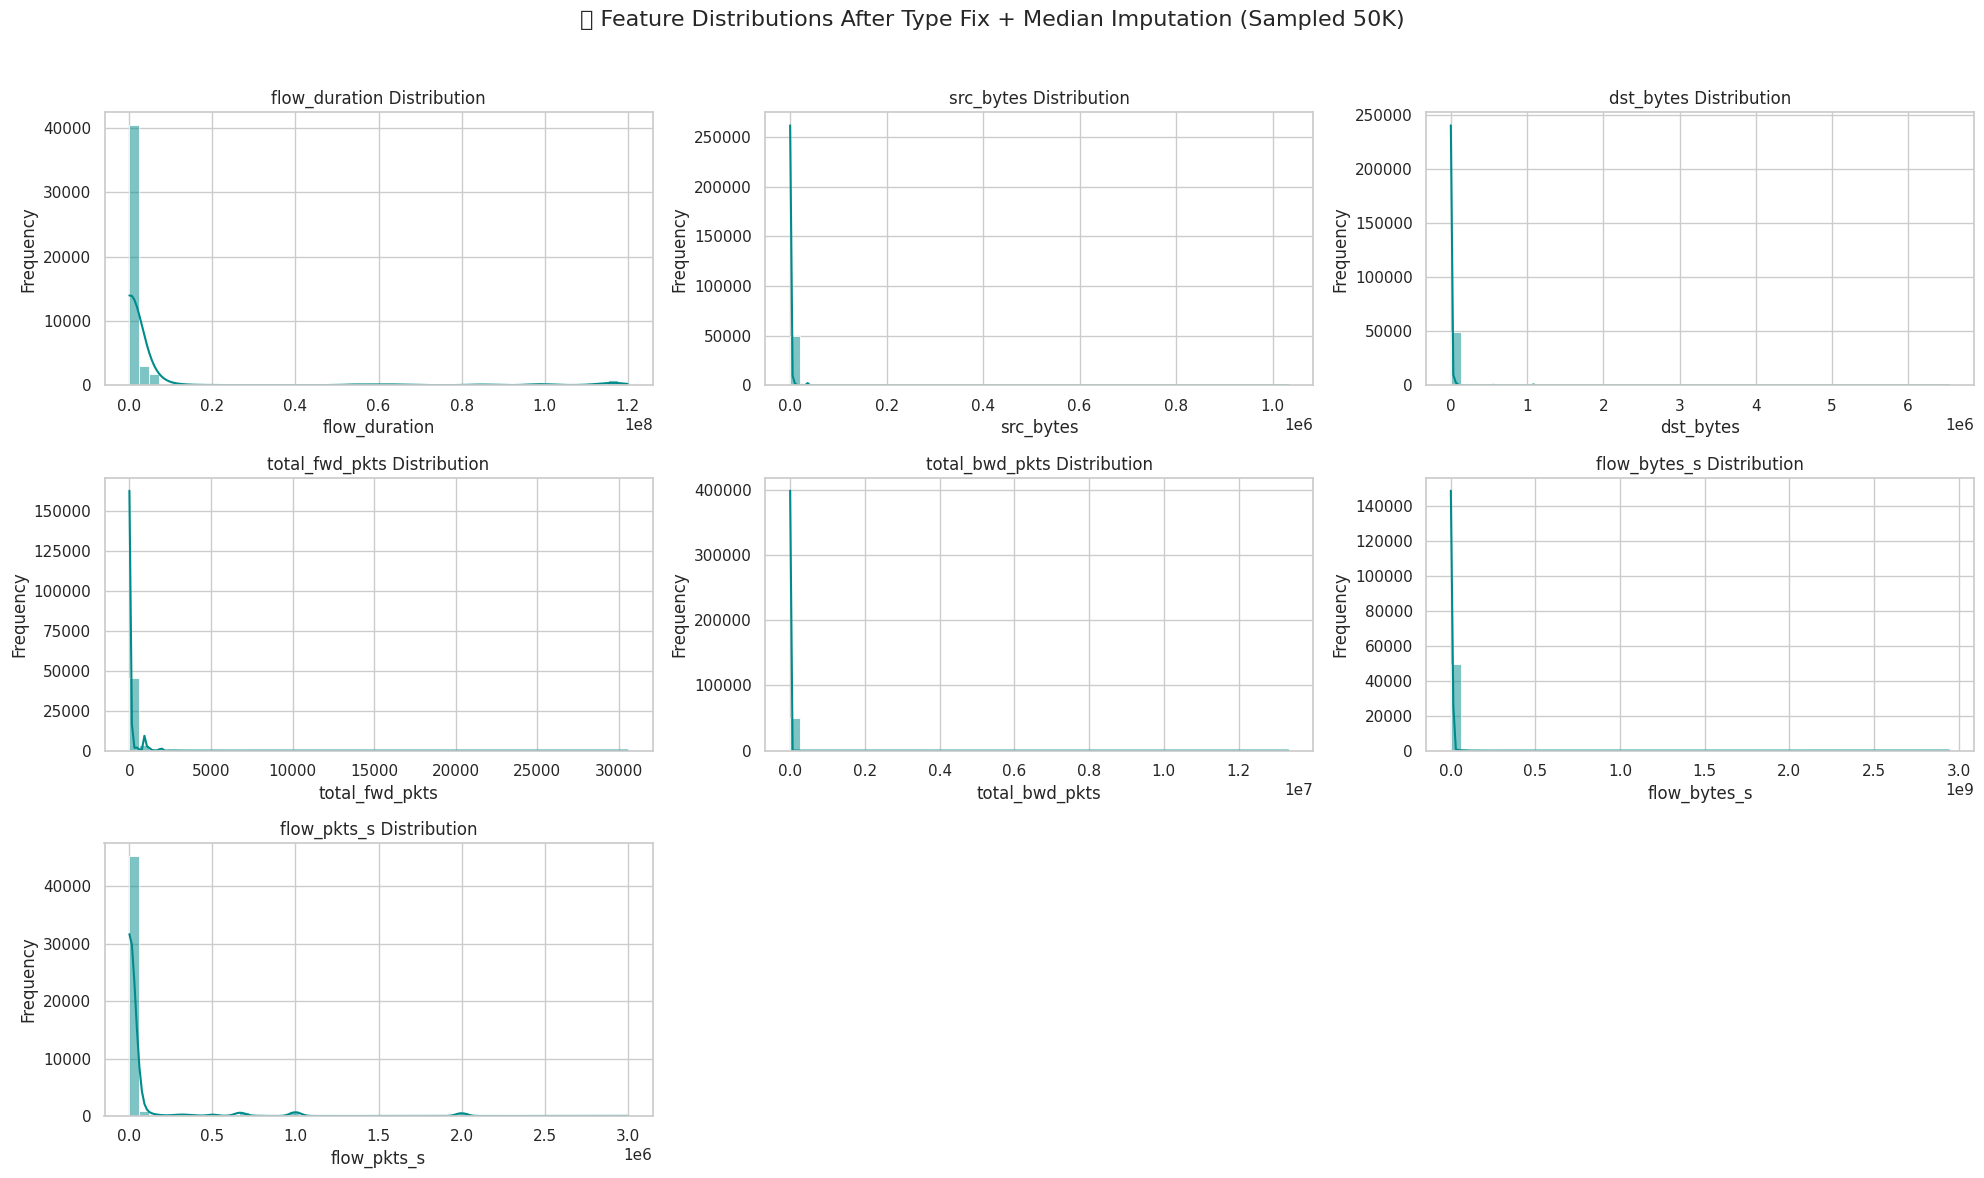

In [106]:
# Step 1: List your selected features
top_features = [
    'flow_duration', 'src_bytes', 'dst_bytes',
    'total_fwd_pkts', 'total_bwd_pkts',
    'flow_bytes_s', 'flow_pkts_s'
]

# Step 2: Force all values to numeric (convert strings to floats, NaNs stay)
df_imputed = df[top_features].apply(pd.to_numeric, errors='coerce')

# Step 3: Median imputation
df_imputed = df_imputed.fillna(df_imputed.median())

# Step 4: Sample 50,000 for fast plotting
df_sample = df_imputed.sample(50000, random_state=42)

# Step 5: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))
for i, feature in enumerate(top_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_sample[feature], bins=50, kde=True, color='darkcyan')
    plt.title(f"{feature} Distribution", fontsize=12)
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.suptitle("📊 Feature Distributions After Type Fix + Median Imputation (Sampled 50K)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("feature_distribution_fixed.png", dpi=300)
plt.show()


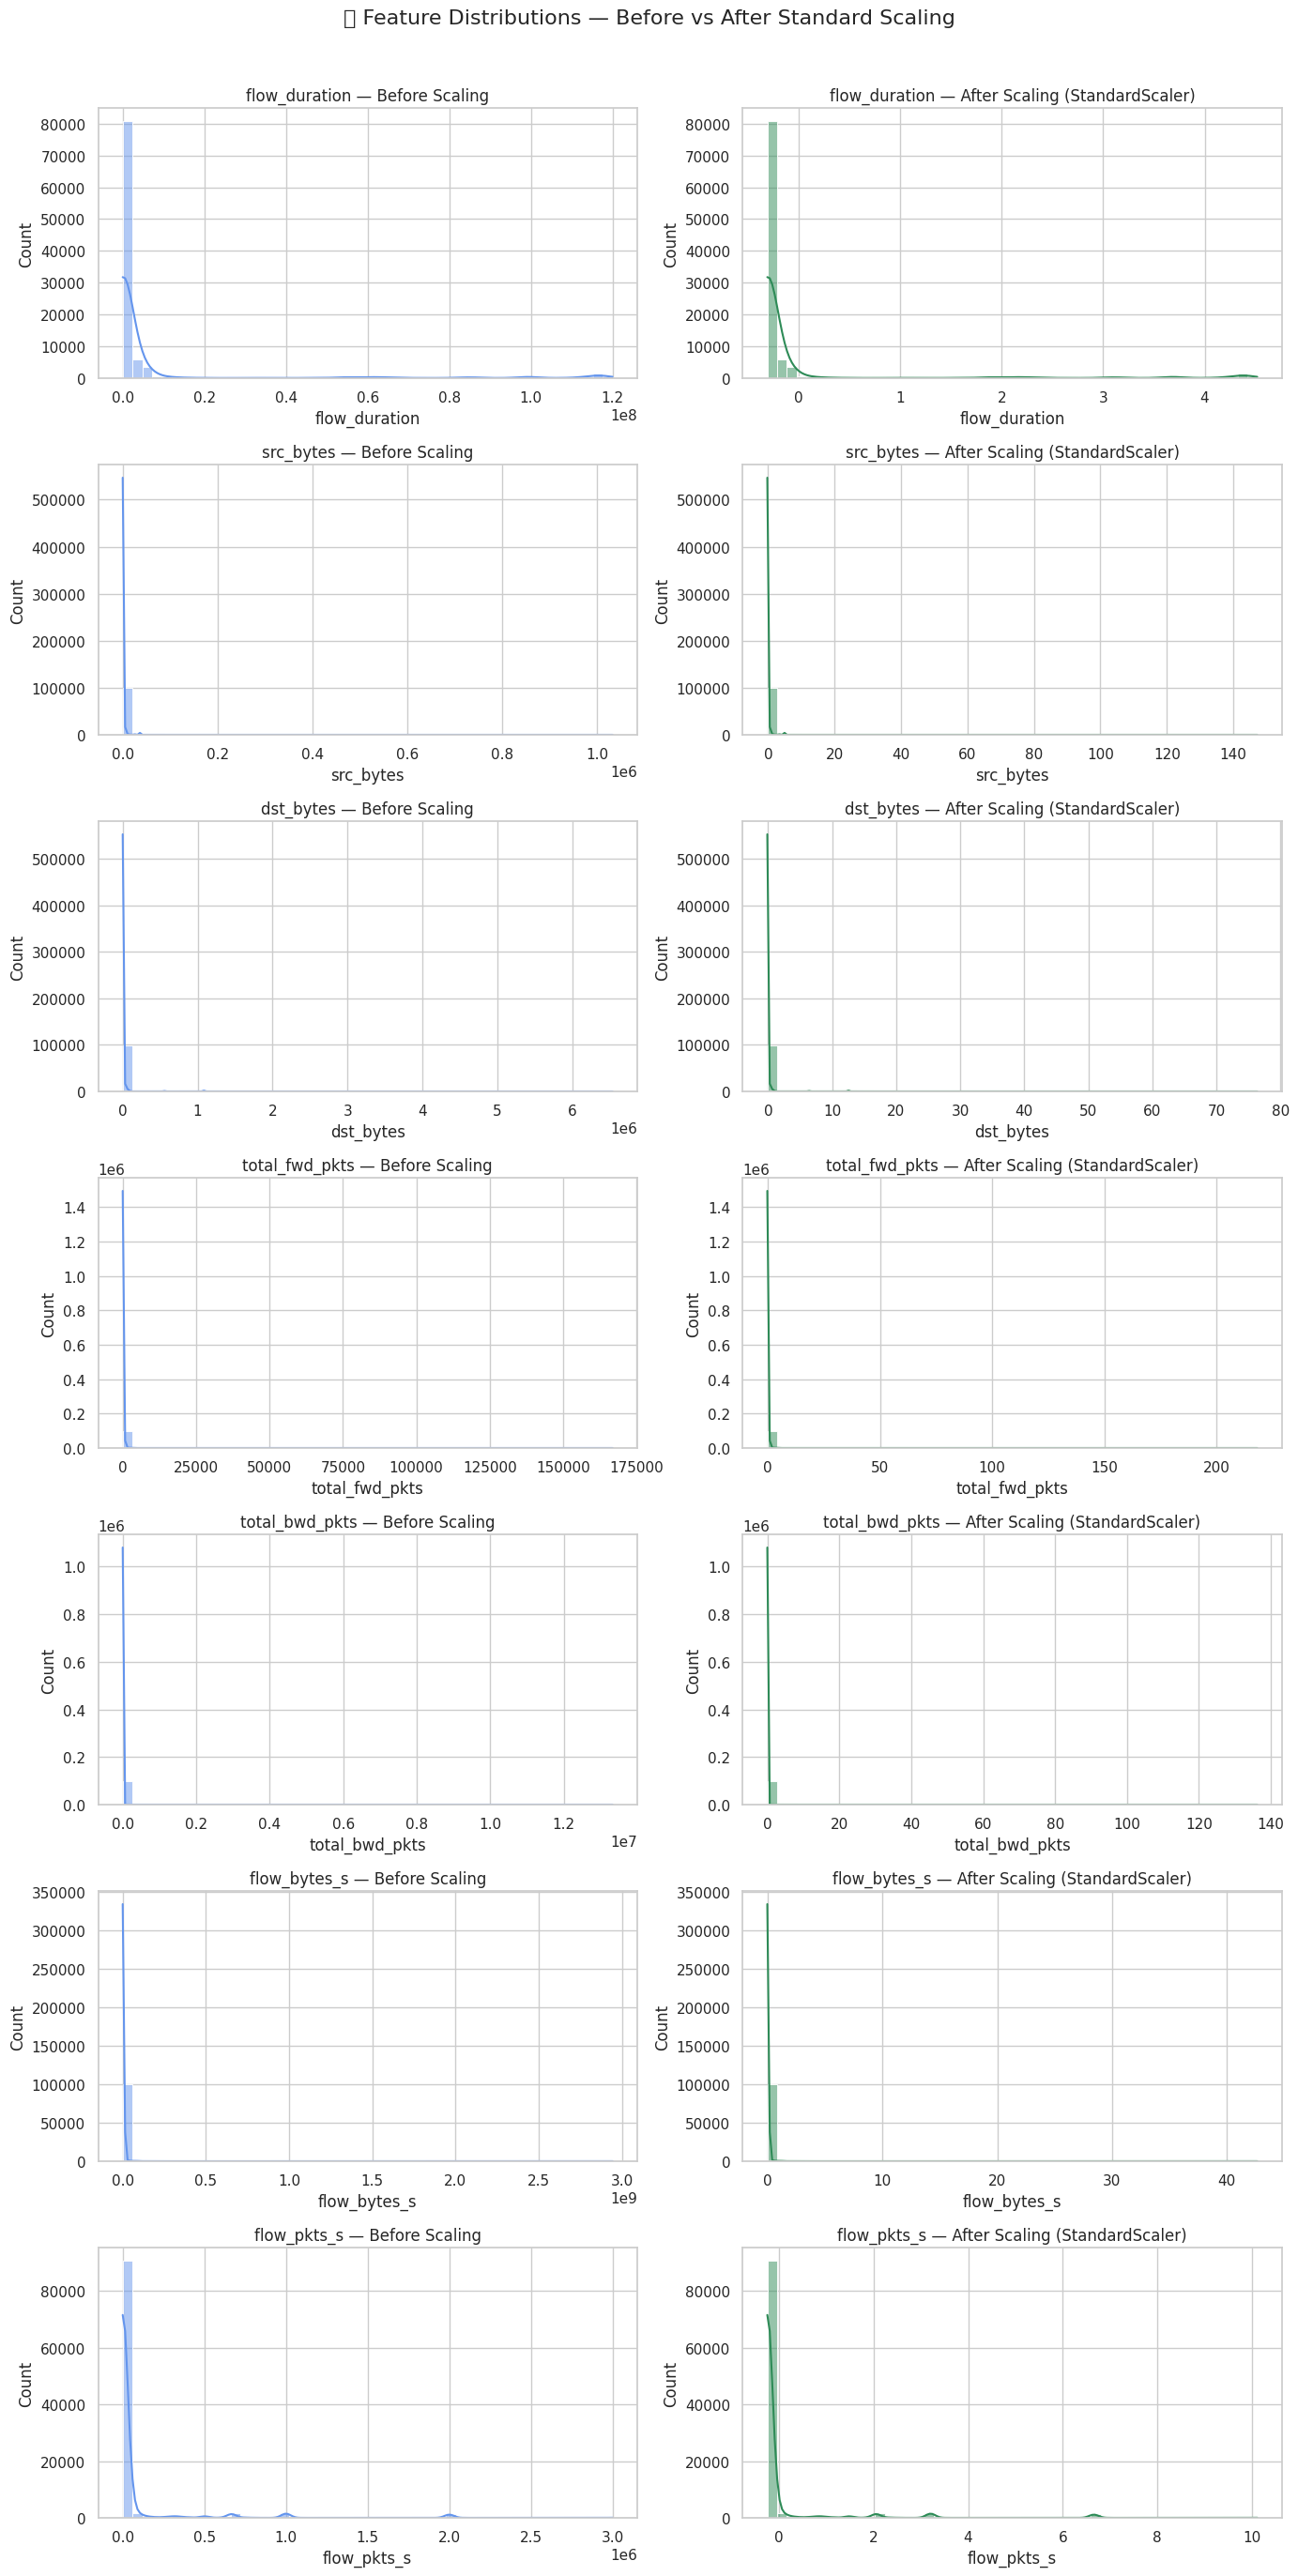

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ─── 1. Define top features ─────────────────────────────
top_features = [
    'flow_duration', 'src_bytes', 'dst_bytes',
    'total_fwd_pkts', 'total_bwd_pkts',
    'flow_bytes_s', 'flow_pkts_s'
]

# ─── 2. Convert to numeric ───────────────────────────────
df_numeric = df[top_features].apply(pd.to_numeric, errors='coerce')

# ─── 3. Replace inf and extreme values ──────────────────
df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)

# ─── 4. Fill NaNs with median ───────────────────────────
df_imputed = df_numeric.fillna(df_numeric.median())

# ─── 5. Sample 100,000 for visualization ────────────────
df_sample = df_imputed.sample(100_000, random_state=42)

# ─── 6. Scale data ──────────────────────────────────────
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_sample), columns=top_features)

# ─── 7. Plot Before & After Scaling ─────────────────────
fig, axes = plt.subplots(len(top_features), 2, figsize=(14, 4 * len(top_features)))
sns.set(style="whitegrid")

for i, feature in enumerate(top_features):
    sns.histplot(df_sample[feature], bins=50, kde=True, ax=axes[i, 0], color='cornflowerblue')
    axes[i, 0].set_title(f"{feature} — Before Scaling")
    axes[i, 0].set_xlabel(feature)

    sns.histplot(df_scaled[feature], bins=50, kde=True, ax=axes[i, 1], color='seagreen')
    axes[i, 1].set_title(f"{feature} — After Scaling (StandardScaler)")
    axes[i, 1].set_xlabel(feature)

plt.suptitle("📊 Feature Distributions — Before vs After Standard Scaling", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("feature_distributions_scaling_comparison.png", dpi=300)
plt.show()


Model Training: CNN + BiLSTM + Attention

In [118]:
import pandas as pd

# Load training set
train_df = pd.read_csv("/content/train_dl.csv.gz")
val_df = pd.read_csv("/content/val_dl.csv.gz")
test_df = pd.read_csv("/content/test_dl.csv.gz")

# Count top 10 frequent labels
top_N = 10
top_labels = train_df['label'].value_counts().nlargest(top_N).index.tolist()

# Filter only top N classes
train_df = train_df[train_df['label'].isin(top_labels)]
val_df   = val_df[val_df['label'].isin(top_labels)]
test_df  = test_df[test_df['label'].isin(top_labels)]

# Re-map labels to 0..(N-1)
label_map = {old: new for new, old in enumerate(sorted(top_labels))}
train_df['label'] = train_df['label'].map(label_map)
val_df['label']   = val_df['label'].map(label_map)
test_df['label']  = test_df['label'].map(label_map)

# Save filtered files
train_df.to_csv("train_topN.csv", index=False)
val_df.to_csv("val_topN.csv", index=False)
test_df.to_csv("test_topN.csv", index=False)

print("✅ Saved: train_topN.csv, val_topN.csv, test_topN.csv")


✅ Saved: train_topN.csv, val_topN.csv, test_topN.csv


In [119]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Load
train_df = pd.read_csv("/content/train_topN.csv")
val_df   = pd.read_csv("/content/val_topN.csv")
test_df  = pd.read_csv("/content/test_topN.csv")

# Inputs and labels
X_train = train_df.drop(columns=["label"]).values
y_train = train_df["label"].values
X_val   = val_df.drop(columns=["label"]).values
y_val   = val_df["label"].values
X_test  = test_df.drop(columns=["label"]).values
y_test  = test_df["label"].values

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
batch_size = 512
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Number of classes (should match top_N)
num_classes = len(np.unique(y_train))


In [120]:
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attn(x), dim=1)
        context = torch.sum(weights * x, dim=1)
        return context

class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.bilstm = nn.LSTM(128, hidden_dim, bidirectional=True, batch_first=True)
        self.attn = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)            # (B, 1, F)
        x = self.relu(self.conv1(x)) # (B, 128, F)
        x = x.permute(0, 2, 1)       # (B, T, D)
        x, _ = self.bilstm(x)
        context = self.attn(x)
        return self.fc(context)


In [121]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class weights for imbalanced classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

model = CNN_BiLSTM_Attention(input_dim=X_train.shape[1], hidden_dim=256, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [122]:
best_val_loss = float('inf')
patience = 10
wait = 0

for epoch in range(1, 50):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            val_preds = torch.argmax(out, dim=1)
            val_correct += (val_preds == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered.")
            break


Epoch 01 | Train Acc: 0.5622 | Val Acc: 0.5619 | Val Loss: 0.8140
Epoch 02 | Train Acc: 0.6503 | Val Acc: 0.7022 | Val Loss: 0.4701
Epoch 03 | Train Acc: 0.6917 | Val Acc: 0.7000 | Val Loss: 0.5140
Epoch 04 | Train Acc: 0.7128 | Val Acc: 0.6837 | Val Loss: 0.4551
Epoch 05 | Train Acc: 0.7125 | Val Acc: 0.6940 | Val Loss: 0.5371
Epoch 06 | Train Acc: 0.7192 | Val Acc: 0.6548 | Val Loss: 0.6008
Epoch 07 | Train Acc: 0.7223 | Val Acc: 0.7149 | Val Loss: 0.4373
Epoch 08 | Train Acc: 0.7278 | Val Acc: 0.8036 | Val Loss: 0.4209
Epoch 09 | Train Acc: 0.7266 | Val Acc: 0.8135 | Val Loss: 0.4204
Epoch 10 | Train Acc: 0.7314 | Val Acc: 0.6667 | Val Loss: 0.5859
Epoch 11 | Train Acc: 0.7255 | Val Acc: 0.6904 | Val Loss: 0.4972
Epoch 12 | Train Acc: 0.7252 | Val Acc: 0.6980 | Val Loss: 0.6964
Epoch 13 | Train Acc: 0.7229 | Val Acc: 0.7252 | Val Loss: 0.4167
Epoch 14 | Train Acc: 0.7209 | Val Acc: 0.7140 | Val Loss: 0.4409
Epoch 15 | Train Acc: 0.7294 | Val Acc: 0.6008 | Val Loss: 0.9416
Epoch 16 |

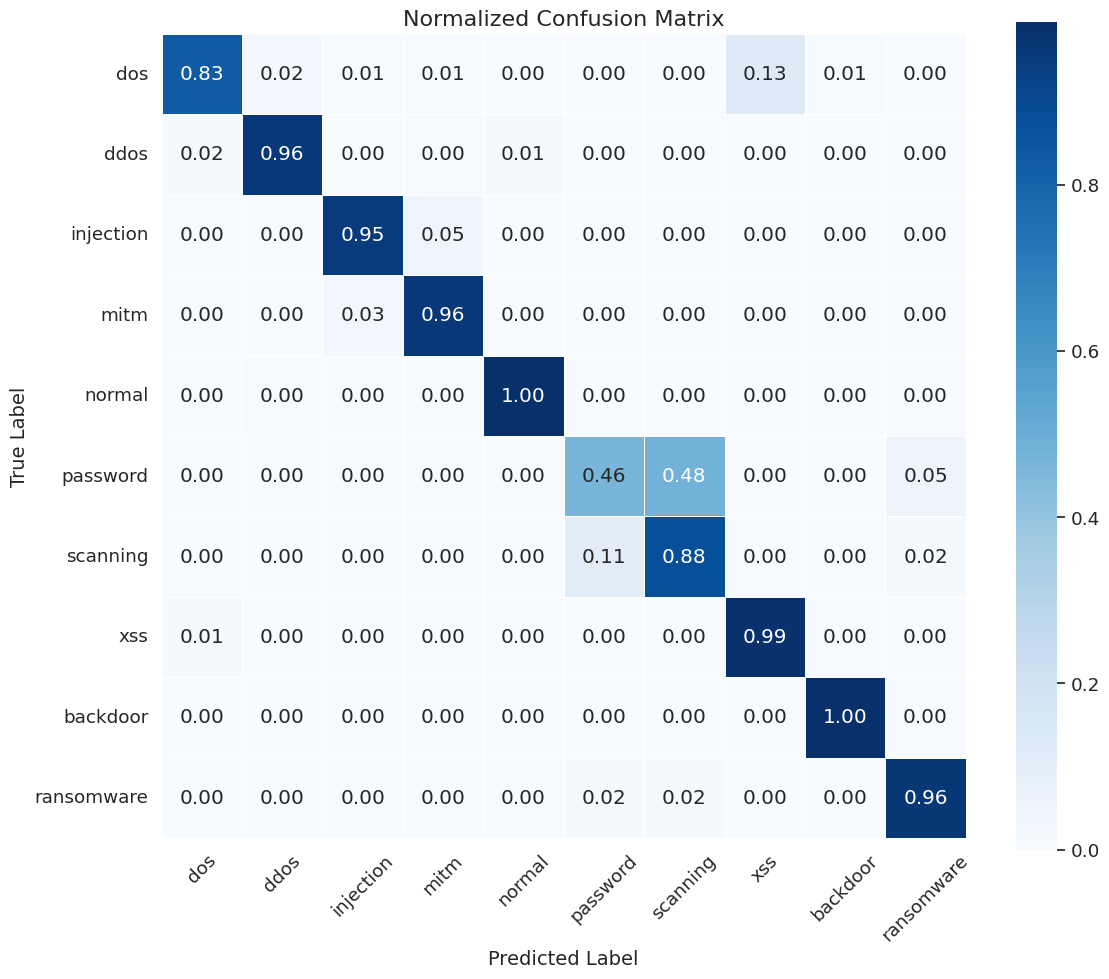

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ['dos', 'ddos', 'injection', 'mitm', 'normal', 'password', 'scanning', 'xss', 'backdoor', 'ransomware']

# Step 2: Normalize (for % values)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 3: Plot with seaborn heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)  # adjust font size
ax = sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes, linewidths=0.5, square=True)

# Step 4: Labels and formatting
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Step 5: Save for thesis use (e.g., PDF, PNG)
plt.savefig("confusion_matrix_thesis.png", dpi=300, bbox_inches='tight')
plt.show()


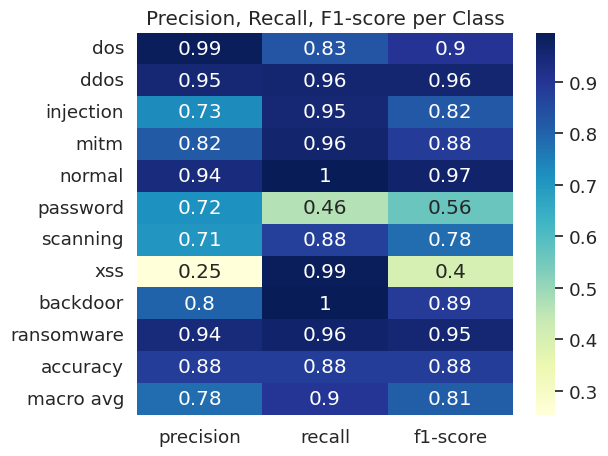

In [130]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Precision, Recall, F1-score per Class")
plt.tight_layout()
plt.show()


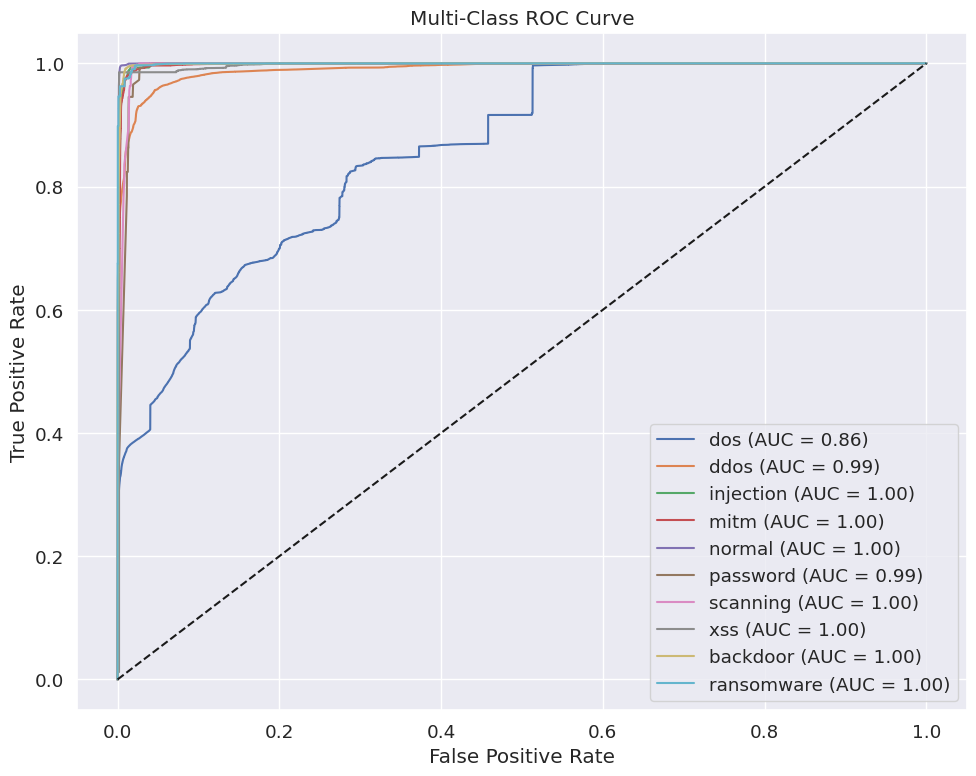

In [138]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

# Get predictions for the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    model_outputs = []
    all_labels = []
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        model_outputs.append(outputs)  # Store model outputs
        all_labels.append(yb)
                          # Concatenate predictions and labels

# FIX: Concatenate all_labels and model_outputs outside the loop
model_outputs = torch.cat(model_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

y_test_bin = label_binarize(all_labels.cpu(), classes=range(len(classes)))
y_score = model_outputs.detach().cpu().numpy()  # use softmax/logits output from model

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [140]:
import torch
import matplotlib.pyplot as plt

# Initialize early stopping and tracking variables
best_val_loss = float('inf')
patience = 10
wait = 0

# Lists for plotting
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

for epoch in range(1, 50):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Validation
    model.eval()
    val_loss_total, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss_total += loss.item() * yb.size(0)  # weight by batch size
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_total / val_total
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    # Logging
    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    # Step learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⛔ Early stopping triggered.")
            break


Epoch 01 | Train Acc: 0.8785 | Val Acc: 0.8770 | Val Loss: 0.2247
Epoch 02 | Train Acc: 0.8788 | Val Acc: 0.8793 | Val Loss: 0.2231
Epoch 03 | Train Acc: 0.8798 | Val Acc: 0.8808 | Val Loss: 0.2249
Epoch 04 | Train Acc: 0.8792 | Val Acc: 0.8838 | Val Loss: 0.2194
Epoch 05 | Train Acc: 0.8798 | Val Acc: 0.8830 | Val Loss: 0.2198
Epoch 06 | Train Acc: 0.8807 | Val Acc: 0.8782 | Val Loss: 0.2235
Epoch 07 | Train Acc: 0.8782 | Val Acc: 0.8818 | Val Loss: 0.2216
Epoch 08 | Train Acc: 0.8808 | Val Acc: 0.8838 | Val Loss: 0.2194
Epoch 09 | Train Acc: 0.8795 | Val Acc: 0.8839 | Val Loss: 0.2199
Epoch 10 | Train Acc: 0.8797 | Val Acc: 0.8811 | Val Loss: 0.2193
Epoch 11 | Train Acc: 0.8802 | Val Acc: 0.8836 | Val Loss: 0.2214
Epoch 12 | Train Acc: 0.8805 | Val Acc: 0.8751 | Val Loss: 0.2304
Epoch 13 | Train Acc: 0.8807 | Val Acc: 0.8798 | Val Loss: 0.2211
Epoch 14 | Train Acc: 0.8799 | Val Acc: 0.8514 | Val Loss: 0.2586
Epoch 15 | Train Acc: 0.8815 | Val Acc: 0.8821 | Val Loss: 0.2164
Epoch 16 |


✅ Test Accuracy: 0.8875

📋 Classification Report:
              precision    recall  f1-score   support

         dos       0.99      0.84      0.91    735032
        ddos       0.96      0.97      0.96    331246
   injection       0.78      0.96      0.86     19204
        mitm       0.85      0.97      0.90     34661
      normal       0.95      0.99      0.97     69287
    password       0.72      0.46      0.56     20984
    scanning       0.71      0.88      0.78     29004
         xss       0.25      0.99      0.40     32322
    backdoor       0.80      1.00      0.89     23840
  ransomware       0.94      0.97      0.95     28139

    accuracy                           0.89   1323719
   macro avg       0.80      0.90      0.82   1323719
weighted avg       0.94      0.89      0.90   1323719



<Figure size 1000x800 with 0 Axes>

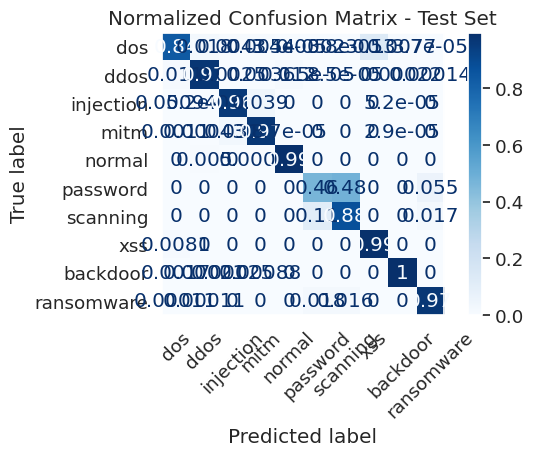

In [141]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Compute Test Accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_acc = np.mean(all_preds == all_labels)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix (Normalized)
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, colorbar=True)
plt.title("Normalized Confusion Matrix - Test Set")
plt.tight_layout()
plt.grid(False)
plt.show()


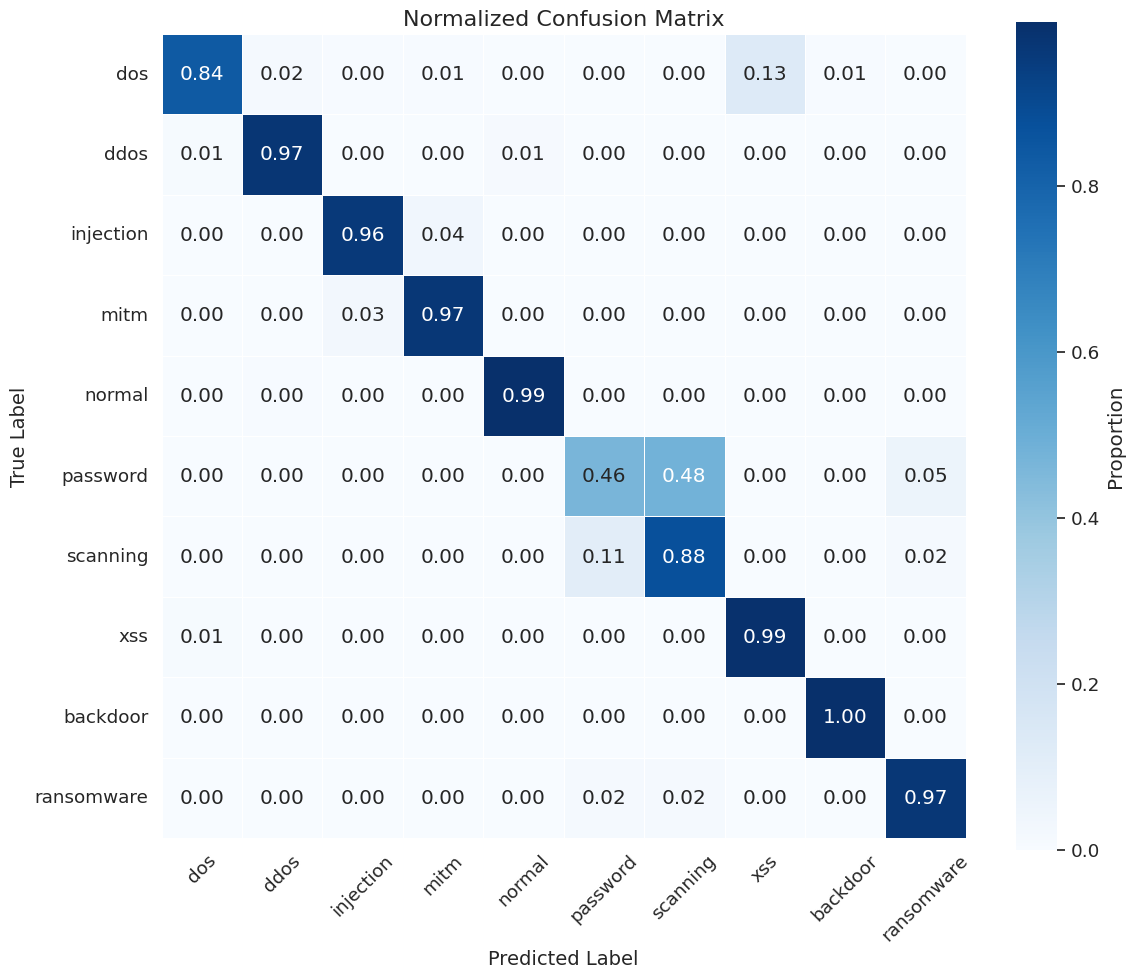

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ─── Replace with your actual class names ───────────────────────────
class_names = ['dos', 'ddos', 'injection', 'mitm', 'normal',
               'password', 'scanning', 'xss', 'backdoor', 'ransomware']

# Assuming 'all_labels' are your true labels and 'all_preds' are your predictions
# ─── Generate confusion matrix ──────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

# ─── Normalize if needed ────────────────────────────────────────────
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ─── Plot ───────────────────────────────────────────────────────────
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'}, linewidths=0.5, square=True)

plt.title("Normalized Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_thesis.png", dpi=300)
plt.show()

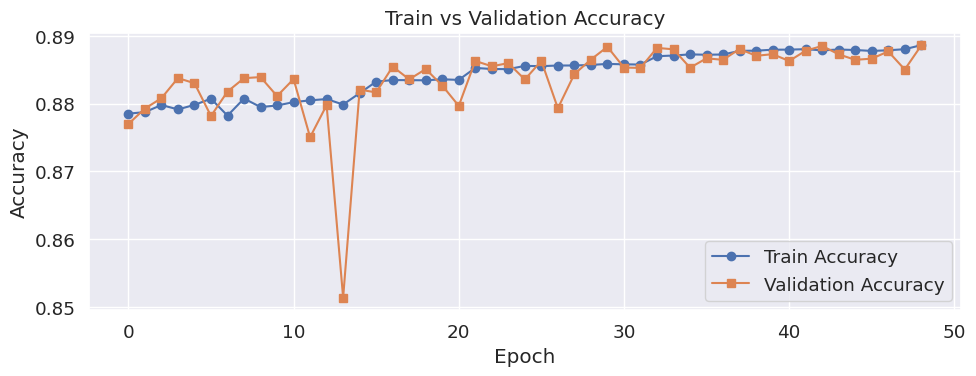

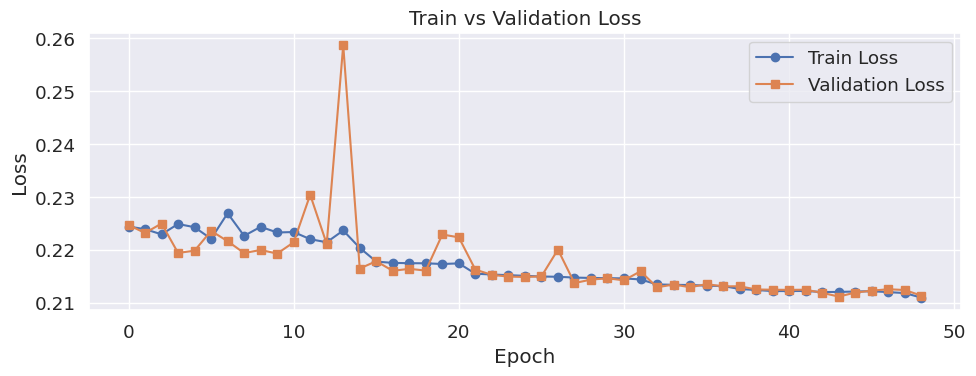

In [142]:
# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label='Train Accuracy', marker='o')
plt.plot(val_acc_list, label='Validation Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label='Train Loss', marker='o')
plt.plot(val_loss_list, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


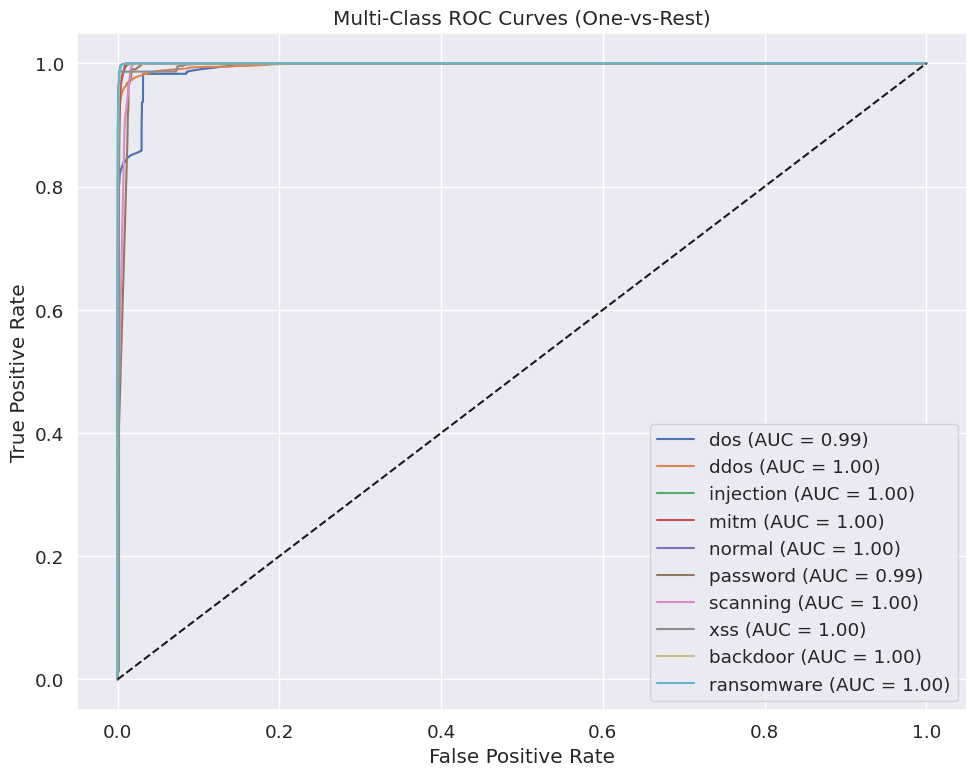

In [143]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get number of classes
n_classes = len(classes)

# Convert labels to one-hot
y_true_bin = label_binarize(all_labels, classes=range(n_classes))

# Get predicted probabilities
model.eval()
y_scores = []
y_true_raw = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        probs = torch.softmax(outputs, dim=1)  # probabilities
        y_scores.append(probs.cpu().numpy())
        y_true_raw.append(yb.cpu().numpy())

y_scores = np.vstack(y_scores)
y_true_bin = label_binarize(np.concatenate(y_true_raw), classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multi-Class ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


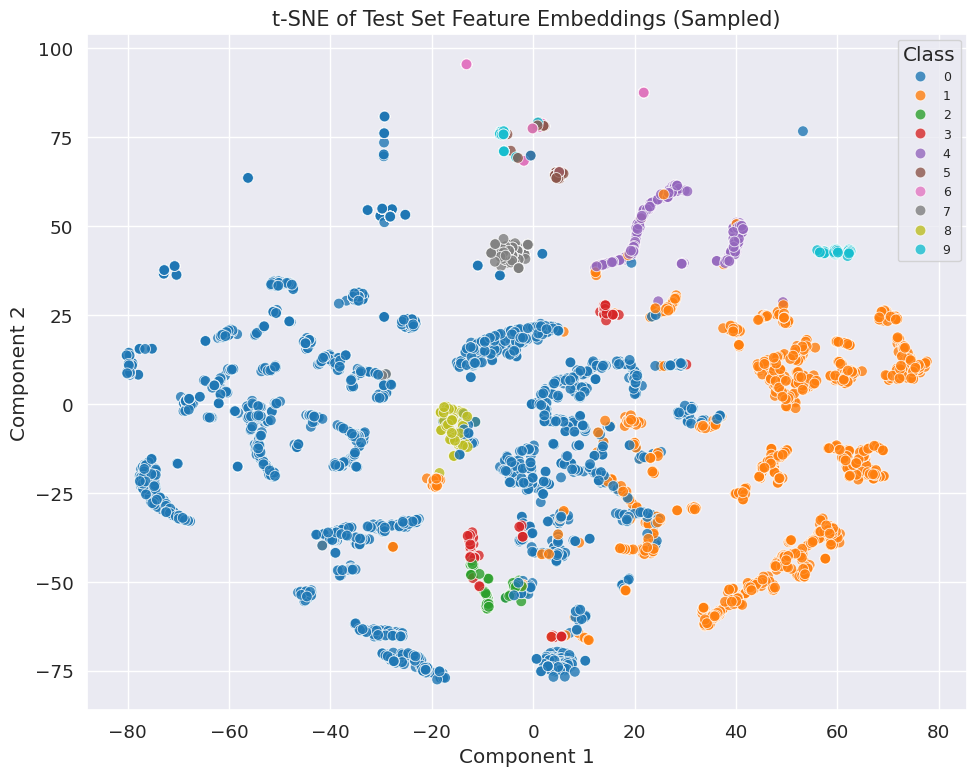

In [145]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample a subset
np.random.seed(42)
sample_indices = np.random.choice(len(labels), size=5000, replace=False)
sampled_features = features[sample_indices]
sampled_labels = labels[sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(sampled_features)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    hue=sampled_labels,
    palette='tab10',
    s=60,
    alpha=0.8,
    legend='full'
)
plt.title("t-SNE of Test Set Feature Embeddings (Sampled)", fontsize=15)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("tsne_testset.png", dpi=300)
plt.show()



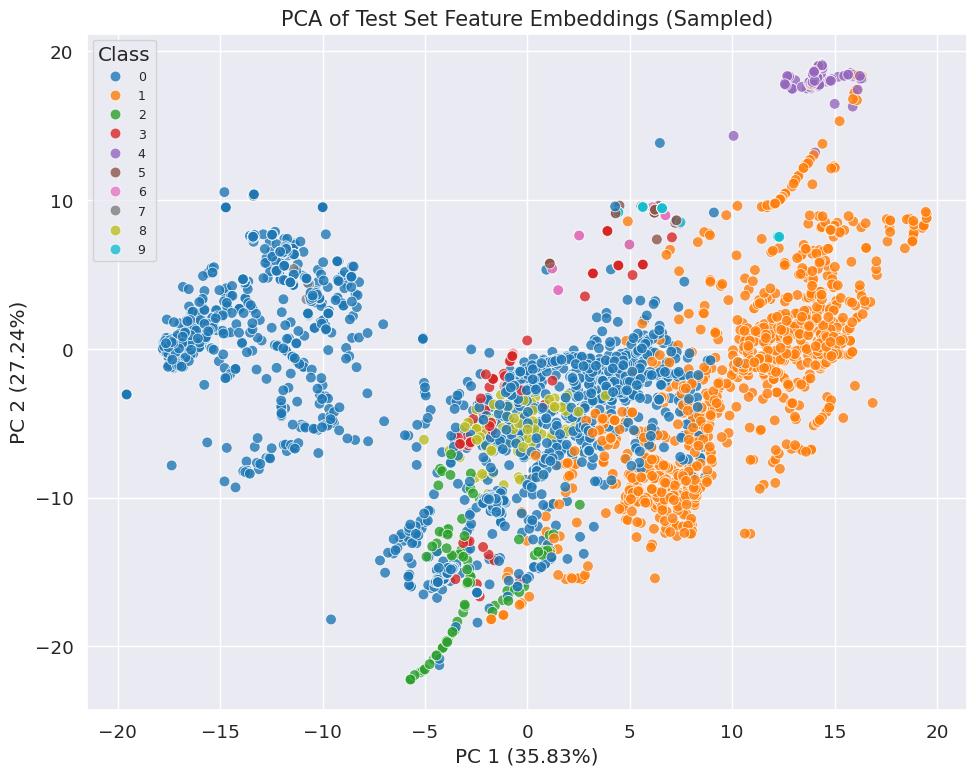

In [146]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample a subset if needed (reuse from t-SNE step)
np.random.seed(42)
sample_indices = np.random.choice(len(labels), size=5000, replace=False)
sampled_features = features[sample_indices]
sampled_labels = labels[sample_indices]

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sampled_features)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=sampled_labels,
    palette='tab10',
    s=60,
    alpha=0.8,
    legend='full'
)
plt.title("PCA of Test Set Feature Embeddings (Sampled)", fontsize=15)
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Class", loc="best", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_testset.png", dpi=300)
plt.show()


BiLSTM Model Setup (Full Feature Set)

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [156]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_size,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True,
                              bidirectional=True,
                              dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add seq_len=1
        out, _ = self.bilstm(x)
        out = out[:, -1, :]
        return self.fc(out)


In [157]:
# Replace with your actual datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=256, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256, shuffle=False)


In [158]:
input_size = X_train.shape[1]
model = BiLSTMClassifier(input_size=input_size, hidden_size=128, num_classes=10).to(device)

# Class weights
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

best_val_loss = float('inf')
wait = 0
patience = 5

for epoch in range(1, 31):
    model.train()
    total, correct, total_loss = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            val_correct += (out.argmax(1) == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_bilstm.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping.")
            break


Epoch 01 | Train Acc: 0.5370 | Val Acc: 0.5658 | Val Loss: 0.7152
Epoch 02 | Train Acc: 0.5803 | Val Acc: 0.5769 | Val Loss: 0.6985
Epoch 03 | Train Acc: 0.5963 | Val Acc: 0.5843 | Val Loss: 0.6739
Epoch 04 | Train Acc: 0.6151 | Val Acc: 0.6221 | Val Loss: 0.6540
Epoch 05 | Train Acc: 0.6378 | Val Acc: 0.6722 | Val Loss: 0.6133
Epoch 06 | Train Acc: 0.6594 | Val Acc: 0.6687 | Val Loss: 0.5847
Epoch 07 | Train Acc: 0.6687 | Val Acc: 0.6657 | Val Loss: 0.5787
Epoch 08 | Train Acc: 0.6764 | Val Acc: 0.6766 | Val Loss: 0.5503
Epoch 09 | Train Acc: 0.6846 | Val Acc: 0.6879 | Val Loss: 0.5415
Epoch 10 | Train Acc: 0.6882 | Val Acc: 0.6941 | Val Loss: 0.5327
Epoch 11 | Train Acc: 0.6906 | Val Acc: 0.6932 | Val Loss: 0.5183
Epoch 12 | Train Acc: 0.6921 | Val Acc: 0.6780 | Val Loss: 0.5066
Epoch 13 | Train Acc: 0.6934 | Val Acc: 0.7044 | Val Loss: 0.5086
Epoch 14 | Train Acc: 0.6946 | Val Acc: 0.6929 | Val Loss: 0.5001
Epoch 15 | Train Acc: 0.6954 | Val Acc: 0.6896 | Val Loss: 0.4906
Epoch 16 |

In [160]:
# Load best model
model.load_state_dict(torch.load("best_bilstm.pt"))
model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

# Classification report
print("✅ Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print("\n📋 Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


✅ Test Accuracy: 0.701605098967379

📋 Classification Report:
               precision    recall  f1-score   support

         dos       0.96      0.57      0.71    735032
        ddos       0.90      0.86      0.88    331246
   injection       0.30      0.87      0.45     19204
        mitm       0.61      0.82      0.70     34661
      normal       0.36      0.99      0.53     69287
    password       0.51      0.97      0.67     20984
    scanning       0.94      0.40      0.56     29004
         xss       0.23      0.98      0.37     32322
    backdoor       0.38      0.97      0.54     23840
  ransomware       0.98      0.91      0.94     28139

    accuracy                           0.70   1323719
   macro avg       0.62      0.83      0.64   1323719
weighted avg       0.86      0.70      0.73   1323719



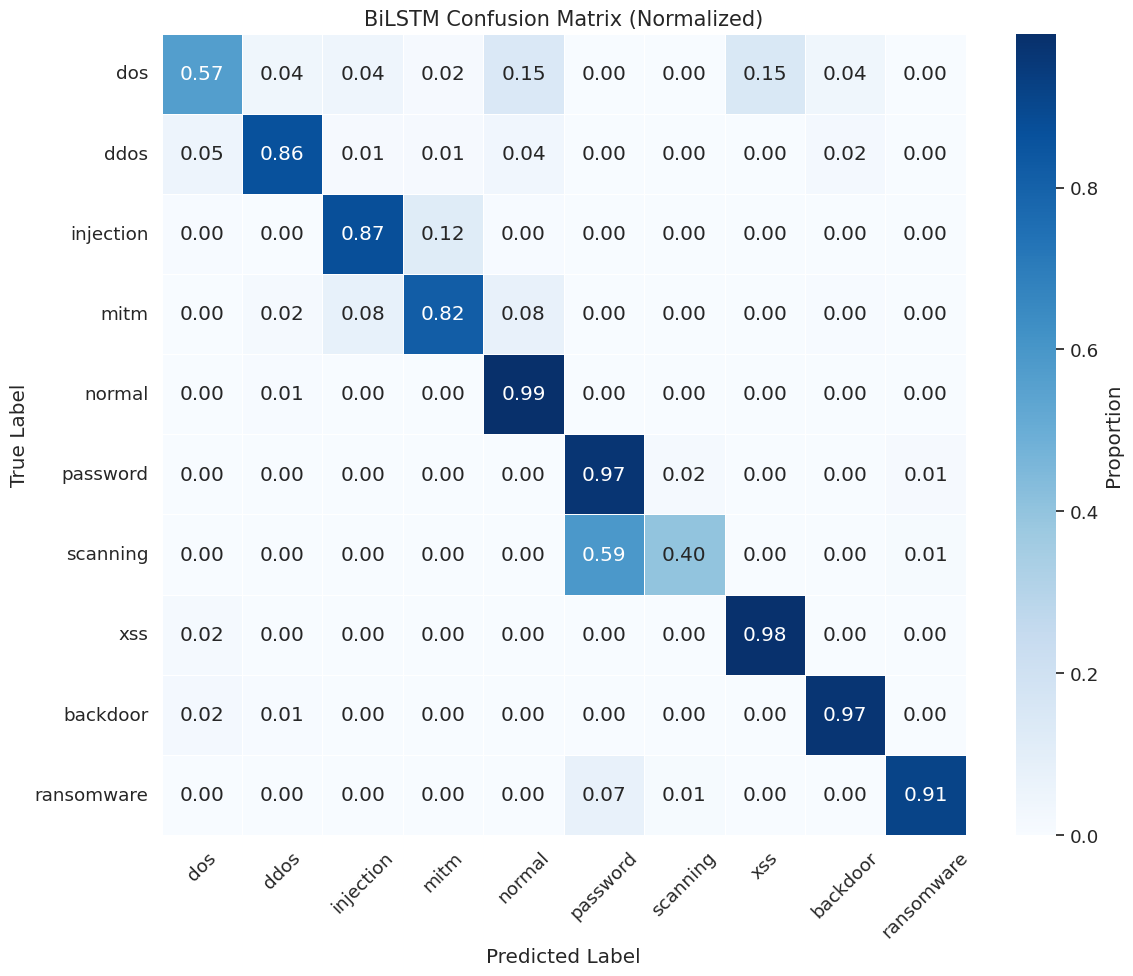

In [161]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'}, linewidths=0.5)
plt.title("BiLSTM Confusion Matrix (Normalized)", fontsize=15)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("bilstm_confusion_matrix.png", dpi=300)
plt.show()


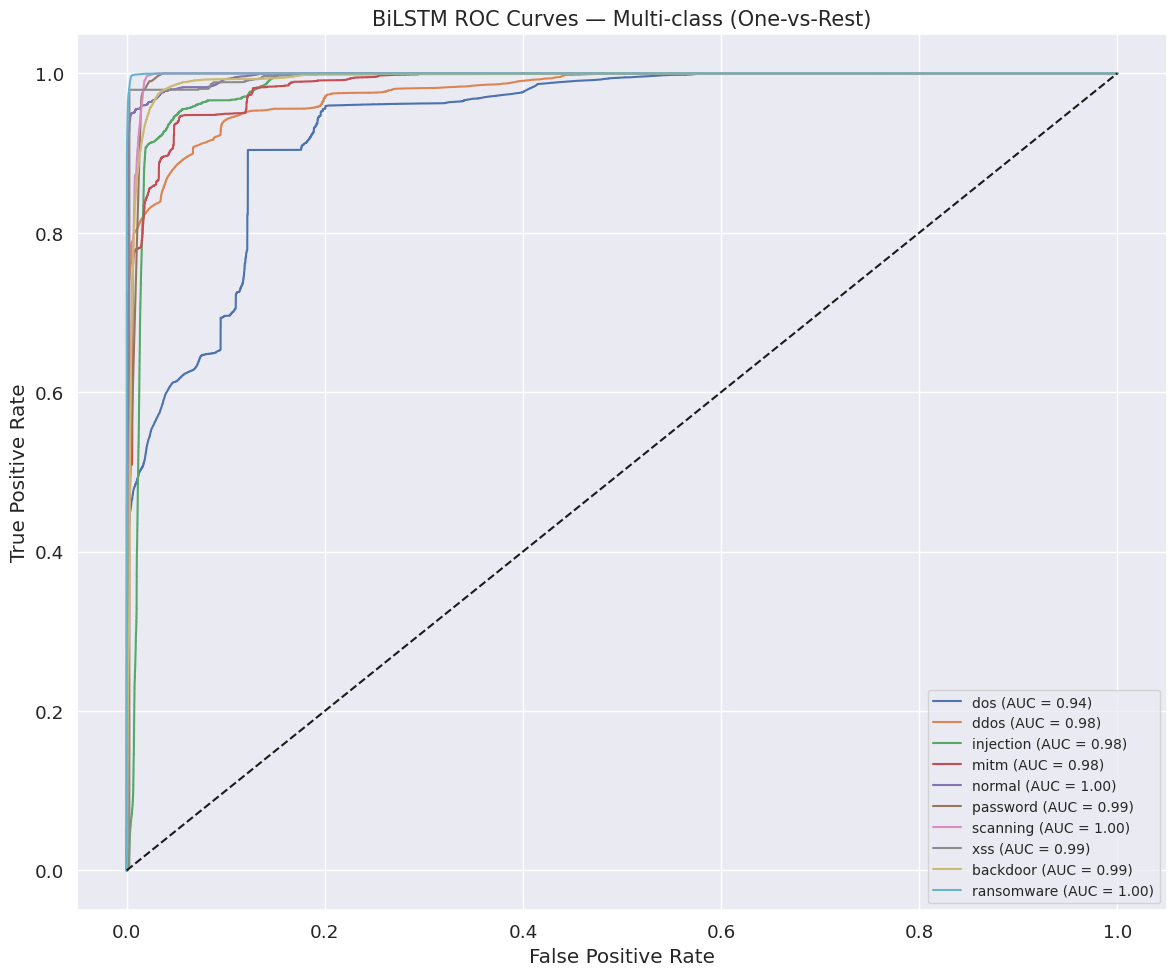

In [162]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for One-vs-Rest AUC
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
y_prob = np.array(y_prob)

plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("BiLSTM ROC Curves — Multi-class (One-vs-Rest)", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("bilstm_roc_curves.png", dpi=300)
plt.show()


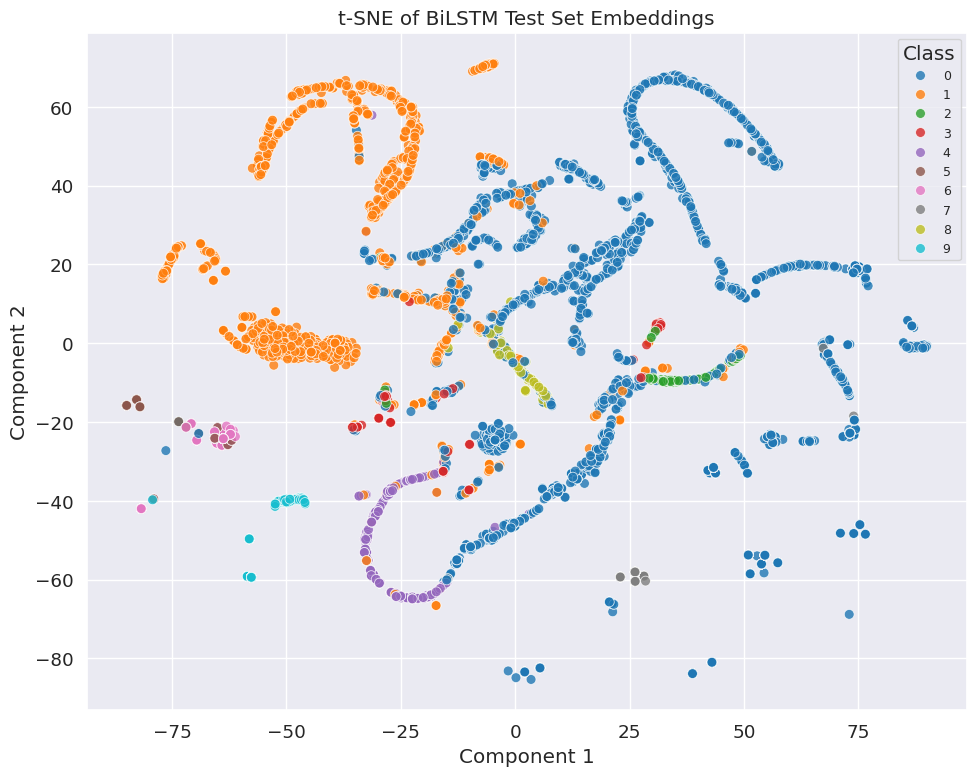

In [163]:
from sklearn.manifold import TSNE
import seaborn as sns

# Sample 5000 points for t-SNE
np.random.seed(42)
idx = np.random.choice(len(y_true), 5000, replace=False)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(y_prob[idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],
                hue=np.array(y_true)[idx], palette='tab10', s=50, alpha=0.8, legend='full')
plt.title("t-SNE of BiLSTM Test Set Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("bilstm_tsne.png", dpi=300)
plt.show()


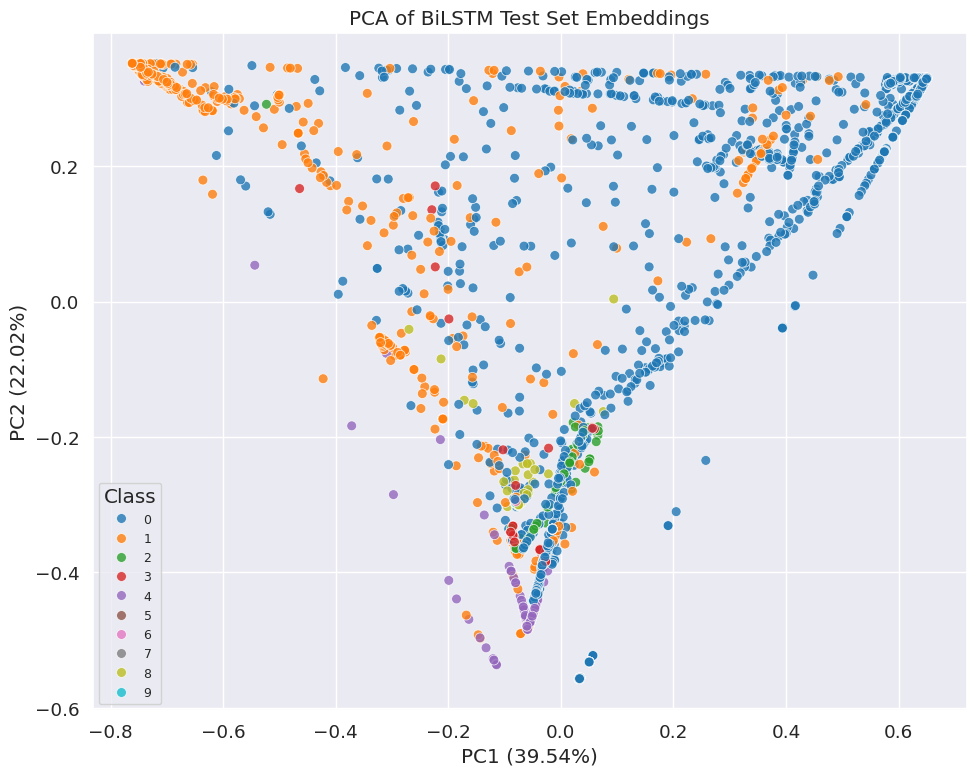

In [164]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_results = pca.fit_transform(y_prob[idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1],
                hue=np.array(y_true)[idx], palette='tab10', s=50, alpha=0.8, legend='full')
plt.title("PCA of BiLSTM Test Set Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Class", loc="best", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.savefig("bilstm_pca.png", dpi=300)
plt.show()


Full LSTM Model Pipeline (Using Normal Dataset)

In [165]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Shape: (batch, seq_len=1, features)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        return self.fc(out)


In [166]:
input_size = X_train.shape[1]  # Full feature count
model = LSTMClassifier(input_size=input_size, hidden_size=128, num_classes=10).to(device)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [167]:
best_val_loss = float('inf')
wait = 0
patience = 5

for epoch in range(1, 31):
    model.train()
    total, correct, total_loss = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            val_correct += (out.argmax(1) == yb).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_lstm.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping.")
            break


Epoch 01 | Train Acc: 0.5308 | Val Acc: 0.5693 | Val Loss: 0.7193
Epoch 02 | Train Acc: 0.5777 | Val Acc: 0.5683 | Val Loss: 0.7051
Epoch 03 | Train Acc: 0.5977 | Val Acc: 0.5953 | Val Loss: 0.6742
Epoch 04 | Train Acc: 0.6169 | Val Acc: 0.6335 | Val Loss: 0.6432
Epoch 05 | Train Acc: 0.6414 | Val Acc: 0.6499 | Val Loss: 0.6108
Epoch 06 | Train Acc: 0.6612 | Val Acc: 0.6724 | Val Loss: 0.5899
Epoch 07 | Train Acc: 0.6708 | Val Acc: 0.6773 | Val Loss: 0.5667
Epoch 08 | Train Acc: 0.6799 | Val Acc: 0.6899 | Val Loss: 0.5572
Epoch 09 | Train Acc: 0.6860 | Val Acc: 0.6904 | Val Loss: 0.5467
Epoch 10 | Train Acc: 0.6887 | Val Acc: 0.6878 | Val Loss: 0.5332
Epoch 11 | Train Acc: 0.6907 | Val Acc: 0.6856 | Val Loss: 0.5268
Epoch 12 | Train Acc: 0.6919 | Val Acc: 0.6880 | Val Loss: 0.5365
Epoch 13 | Train Acc: 0.6929 | Val Acc: 0.6930 | Val Loss: 0.5224
Epoch 14 | Train Acc: 0.6937 | Val Acc: 0.6853 | Val Loss: 0.5099
Epoch 15 | Train Acc: 0.6943 | Val Acc: 0.6932 | Val Loss: 0.5001
Epoch 16 |

In [168]:
model.load_state_dict(torch.load("best_lstm.pt"))


<All keys matched successfully>

In [169]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [170]:
# Load best LSTM model
model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [171]:
print(f"✅ Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


✅ Test Accuracy: 0.6979

📋 Classification Report:
              precision    recall  f1-score   support

         dos       0.97      0.55      0.70    735032
        ddos       0.89      0.88      0.88    331246
   injection       0.39      0.85      0.53     19204
        mitm       0.56      0.79      0.66     34661
      normal       0.33      0.99      0.50     69287
    password       0.52      0.93      0.67     20984
    scanning       0.94      0.40      0.56     29004
         xss       0.23      0.98      0.37     32322
    backdoor       0.39      0.97      0.56     23840
  ransomware       0.93      0.97      0.95     28139

    accuracy                           0.70   1323719
   macro avg       0.61      0.83      0.64   1323719
weighted avg       0.86      0.70      0.73   1323719



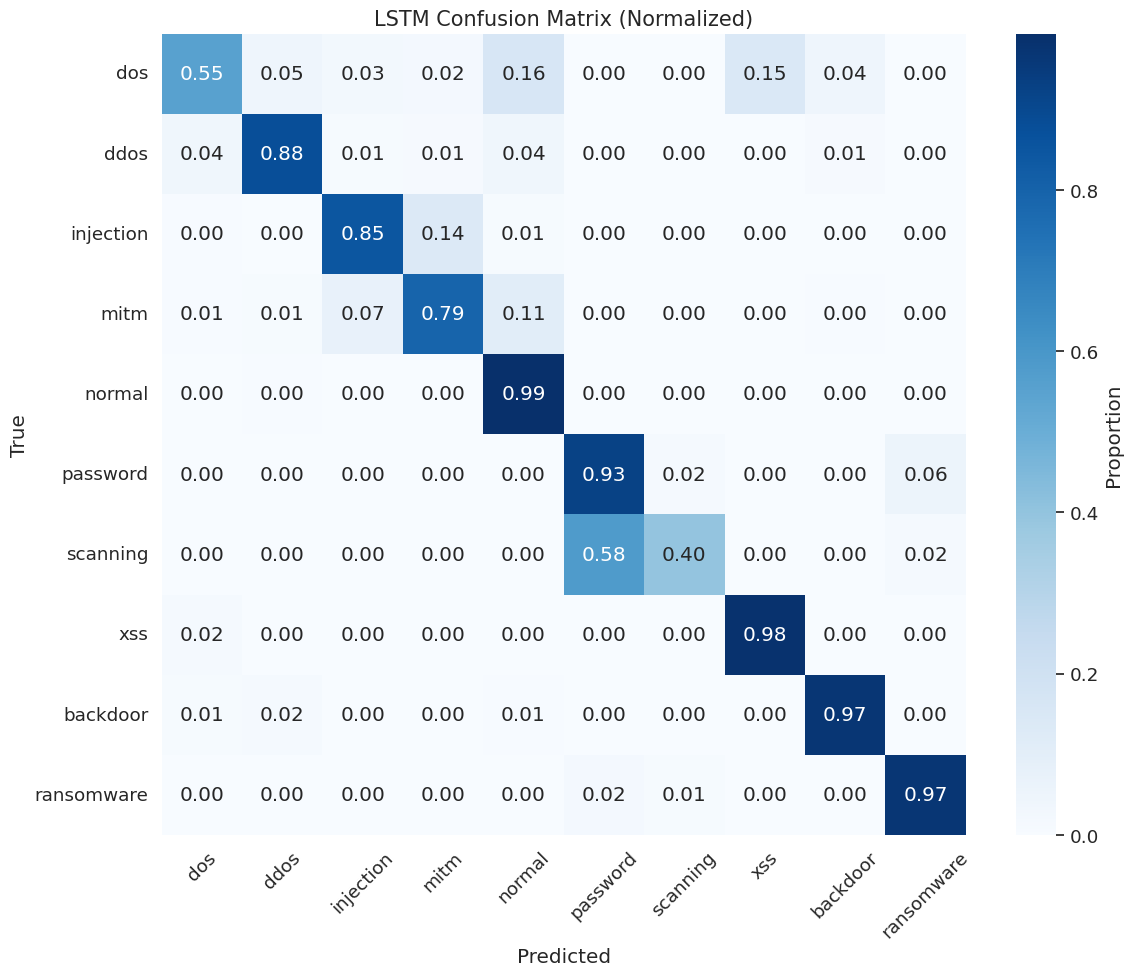

In [172]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.title("LSTM Confusion Matrix (Normalized)", fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("lstm_confusion_matrix.png", dpi=300)
plt.show()


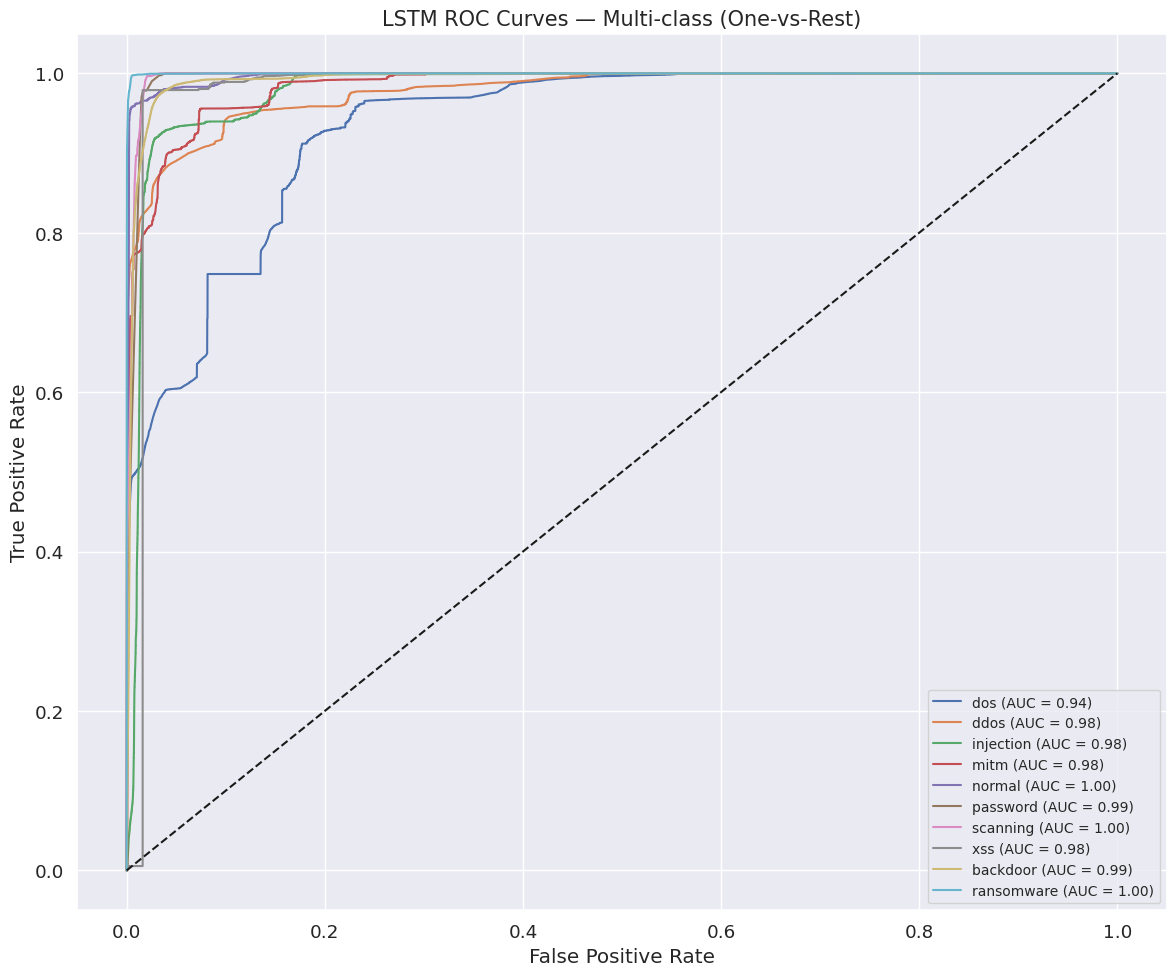

In [173]:
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("LSTM ROC Curves — Multi-class (One-vs-Rest)", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("lstm_roc_curves.png", dpi=300)
plt.show()


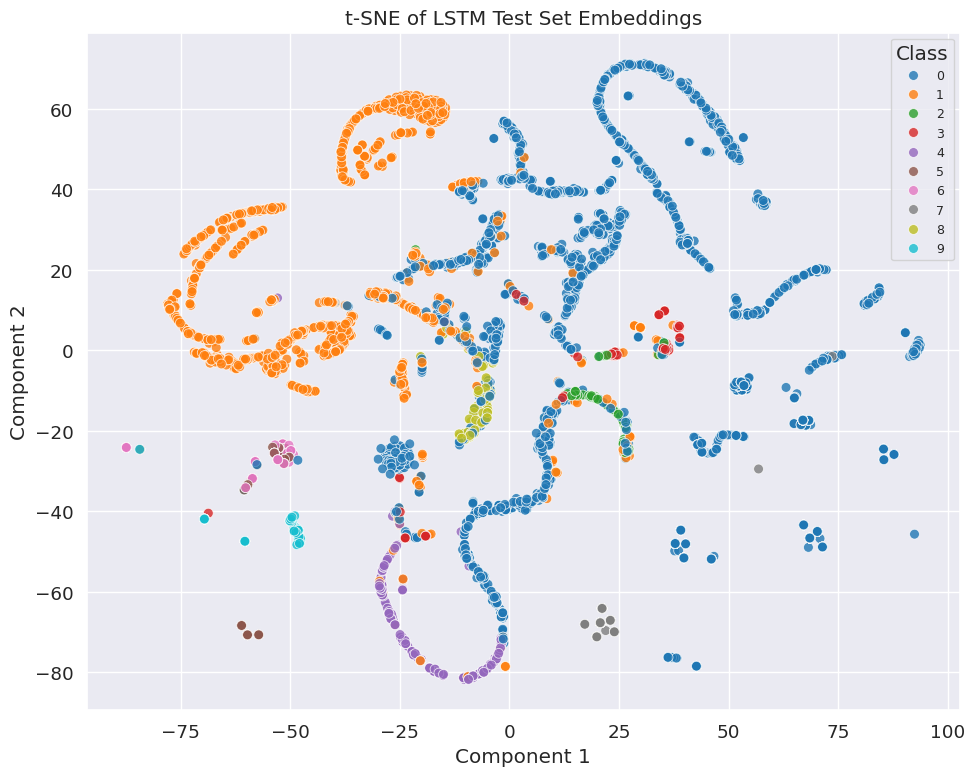

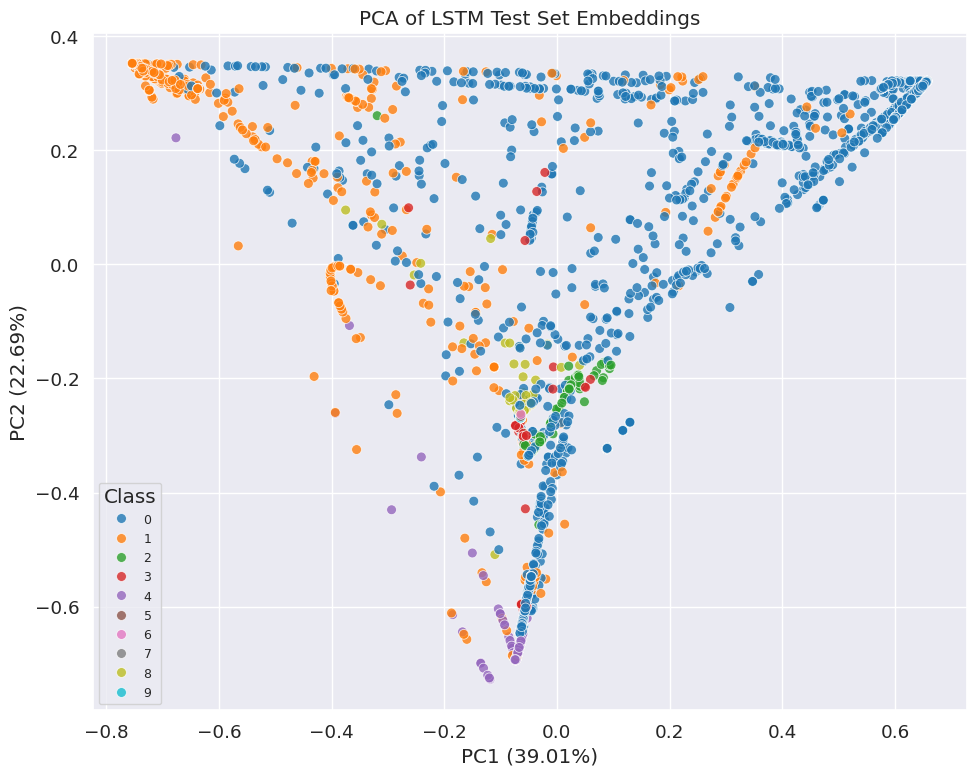

In [174]:
# Sample 5000 points for visualization
np.random.seed(42)
sample_idx = np.random.choice(len(y_true), size=5000, replace=False)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=y_true[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("t-SNE of LSTM Test Set Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("lstm_tsne.png", dpi=300)
plt.show()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=y_true[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("PCA of LSTM Test Set Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("lstm_pca.png", dpi=300)
plt.show()


CNN + BiLSTM Model

In [175]:
import torch.nn as nn

class CNN_BiLSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        self.bilstm = nn.LSTM(input_size=64, hidden_size=128,
                              num_layers=1, batch_first=True,
                              bidirectional=True)

        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, features)
        x = self.conv1(x)   # (batch, 64, features)
        x = self.relu(x)
        x = self.pool(x)    # (batch, 64, features/2)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features) for LSTM
        out, _ = self.bilstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out)


In [176]:
input_size = X_train.shape[1]
model = CNN_BiLSTM(input_size=input_size, num_classes=10).to(device)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [177]:
best_val_loss = float('inf')
wait = 0
patience = 5

for epoch in range(1, 31):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            val_correct += (out.argmax(1) == yb).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_cnn_bilstm.pt")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping.")
            break


Epoch 01 | Train Acc: 0.6086 | Val Acc: 0.5811 | Val Loss: 0.9184
Epoch 02 | Train Acc: 0.6920 | Val Acc: 0.7599 | Val Loss: 0.4578
Epoch 03 | Train Acc: 0.7460 | Val Acc: 0.6977 | Val Loss: 0.4792
Epoch 04 | Train Acc: 0.7566 | Val Acc: 0.7807 | Val Loss: 0.3724
Epoch 05 | Train Acc: 0.7738 | Val Acc: 0.7545 | Val Loss: 0.6944
Epoch 06 | Train Acc: 0.7849 | Val Acc: 0.7848 | Val Loss: 0.3652
Epoch 07 | Train Acc: 0.7934 | Val Acc: 0.7676 | Val Loss: 0.4803
Epoch 08 | Train Acc: 0.7953 | Val Acc: 0.7714 | Val Loss: 0.6339
Epoch 09 | Train Acc: 0.7990 | Val Acc: 0.8186 | Val Loss: 0.3114
Epoch 10 | Train Acc: 0.8041 | Val Acc: 0.8117 | Val Loss: 0.3199
Epoch 11 | Train Acc: 0.8115 | Val Acc: 0.8091 | Val Loss: 0.3124
Epoch 12 | Train Acc: 0.8139 | Val Acc: 0.8178 | Val Loss: 0.2827
Epoch 13 | Train Acc: 0.8156 | Val Acc: 0.8309 | Val Loss: 0.3032
Epoch 14 | Train Acc: 0.8181 | Val Acc: 0.8198 | Val Loss: 0.2824
Epoch 15 | Train Acc: 0.8194 | Val Acc: 0.8419 | Val Loss: 0.3032
Epoch 16 |

In [178]:
model.load_state_dict(torch.load("best_cnn_bilstm.pt"))
model.eval()



CNN_BiLSTM(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [179]:
model.load_state_dict(torch.load("best_cnn_bilstm.pt"))
model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [180]:
from sklearn.metrics import classification_report, accuracy_score

print(f"✅ Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


✅ Test Accuracy: 0.8687

📋 Classification Report:
              precision    recall  f1-score   support

         dos       0.99      0.82      0.89    735032
        ddos       0.96      0.94      0.95    331246
   injection       0.67      0.92      0.78     19204
        mitm       0.72      0.94      0.82     34661
      normal       0.89      0.99      0.94     69287
    password       0.70      0.48      0.57     20984
    scanning       0.71      0.86      0.78     29004
         xss       0.25      0.99      0.40     32322
    backdoor       0.67      0.99      0.80     23840
  ransomware       0.94      0.97      0.95     28139

    accuracy                           0.87   1323719
   macro avg       0.75      0.89      0.79   1323719
weighted avg       0.93      0.87      0.89   1323719



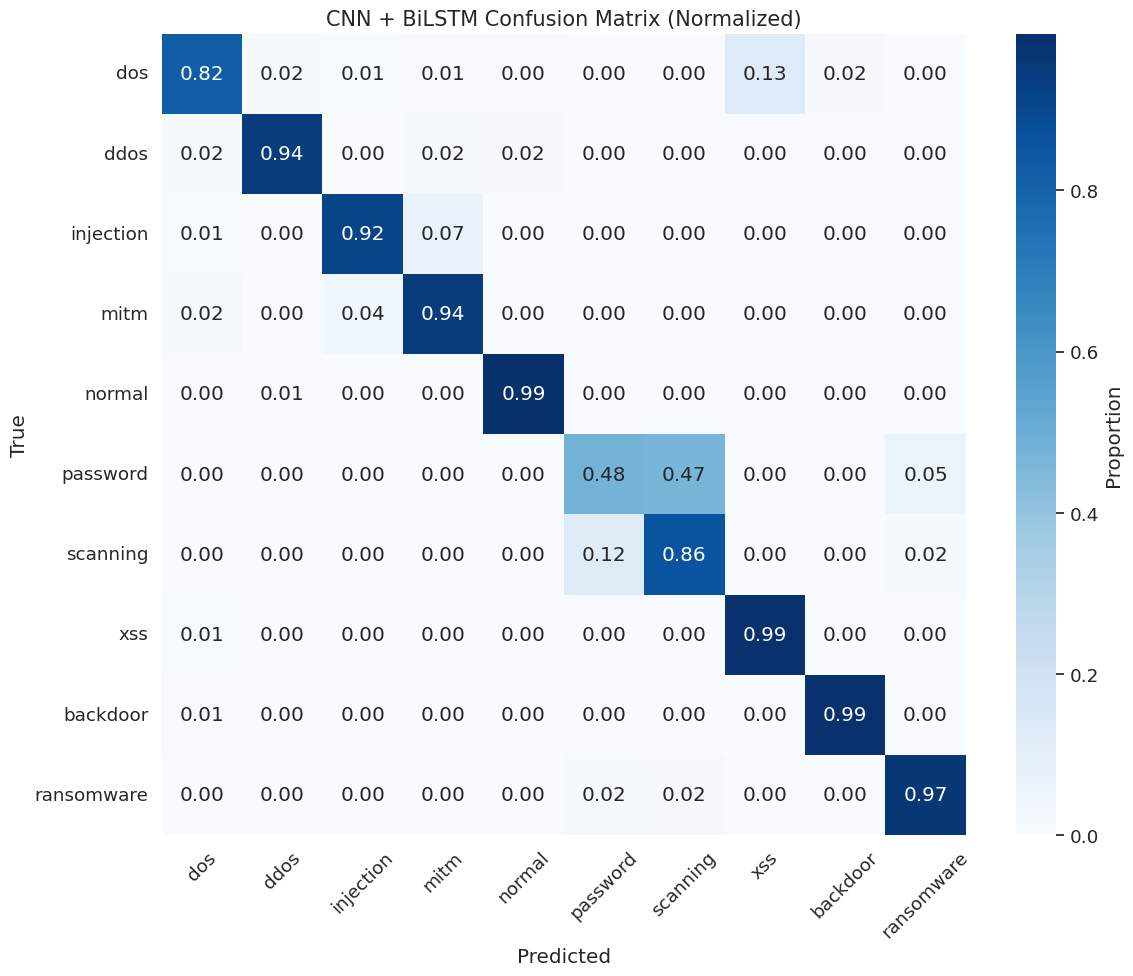

In [181]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.title("CNN + BiLSTM Confusion Matrix (Normalized)", fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("cnn_bilstm_confusion_matrix.png", dpi=300)
plt.show()


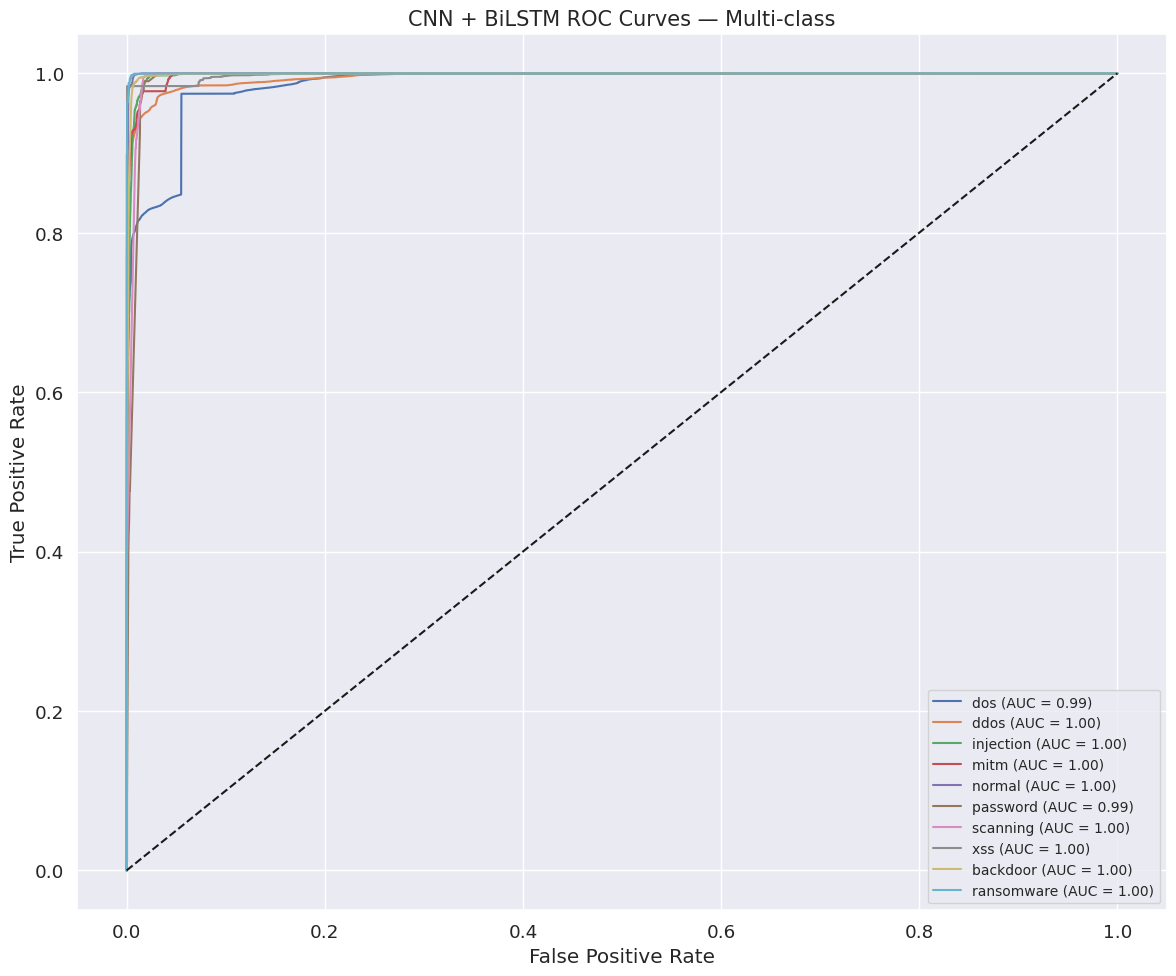

In [182]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("CNN + BiLSTM ROC Curves — Multi-class", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("cnn_bilstm_roc_curves.png", dpi=300)
plt.show()


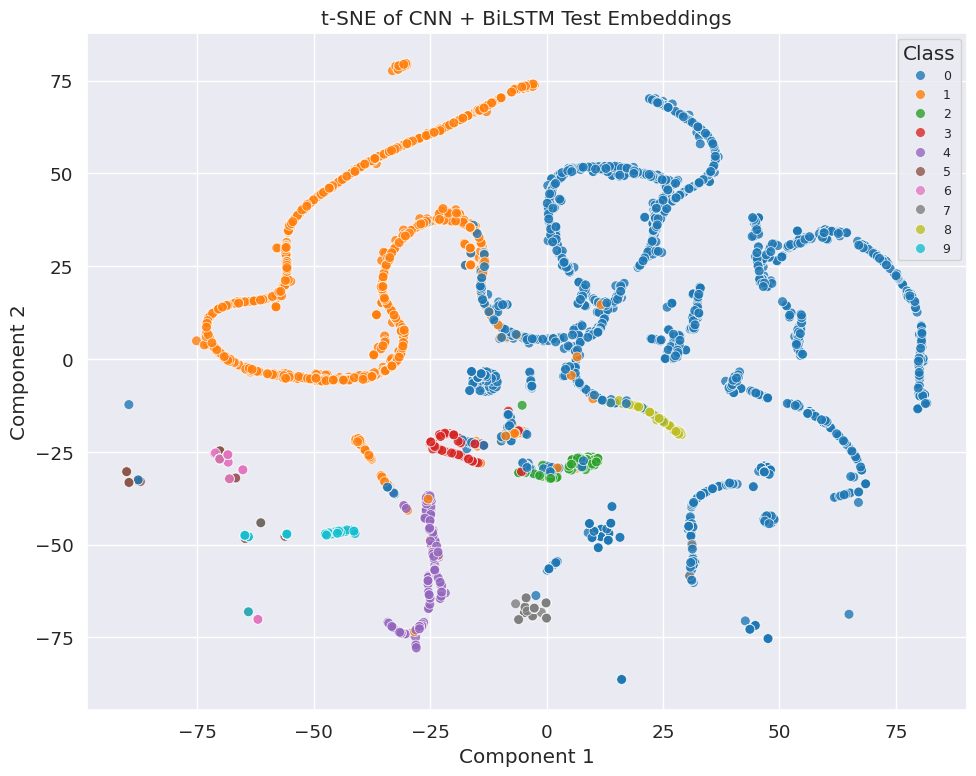

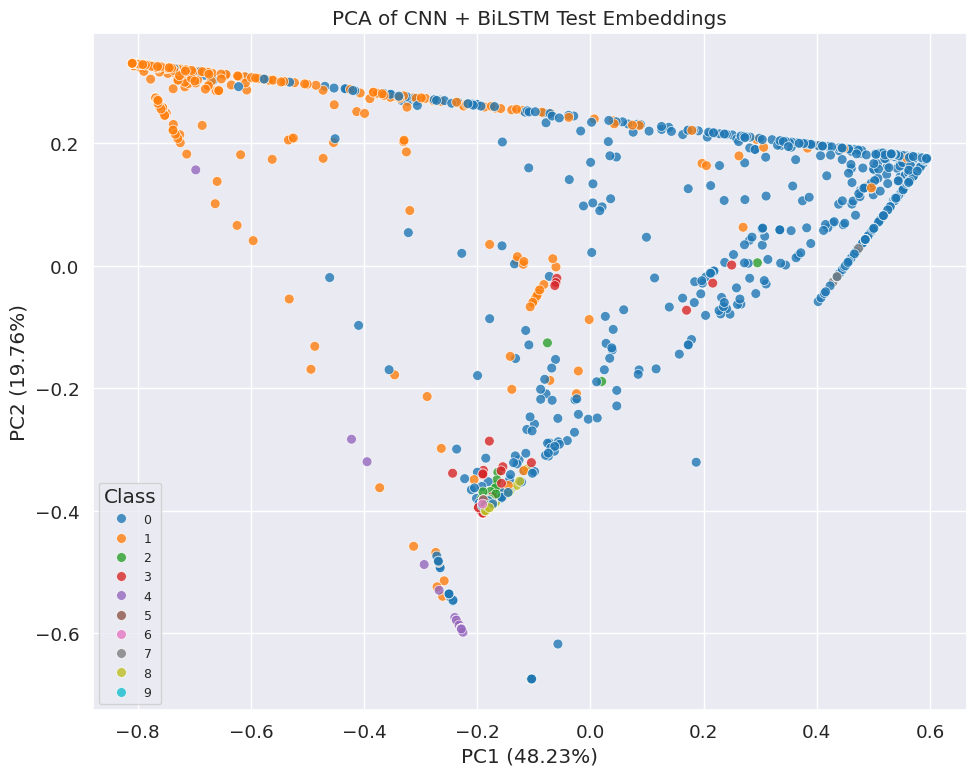

In [183]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

# Sample 5000 points for visualization
np.random.seed(42)
sample_idx = np.random.choice(len(y_true), size=5000, replace=False)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=y_true[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("t-SNE of CNN + BiLSTM Test Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("cnn_bilstm_tsne.png", dpi=300)
plt.show()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=y_true[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("PCA of CNN + BiLSTM Test Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("cnn_bilstm_pca.png", dpi=300)
plt.show()


 MLP Model — Full Code (With Class Weights & Evaluation)

In [184]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [185]:
input_size = X_train.shape[1]
model = MLP(input_size=input_size, num_classes=10).to(device)

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [186]:
best_val_loss = float('inf')
wait = 0
patience = 5

for epoch in range(1, 31):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            val_loss += criterion(out, yb).item()
            val_correct += (out.argmax(1) == yb).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_mlp.pt")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping.")
            break


Epoch 01 | Train Acc: 0.5714 | Val Acc: 0.5908 | Val Loss: 1.4130
Epoch 02 | Train Acc: 0.6258 | Val Acc: 0.6681 | Val Loss: 3.1879
Epoch 03 | Train Acc: 0.6400 | Val Acc: 0.4852 | Val Loss: 3.6857
Epoch 04 | Train Acc: 0.6472 | Val Acc: 0.6114 | Val Loss: 1.3322
Epoch 05 | Train Acc: 0.6536 | Val Acc: 0.5377 | Val Loss: 2.3591
Epoch 06 | Train Acc: 0.6577 | Val Acc: 0.7059 | Val Loss: 1.9479
Epoch 07 | Train Acc: 0.6609 | Val Acc: 0.5580 | Val Loss: 3.2815
Epoch 08 | Train Acc: 0.6633 | Val Acc: 0.6068 | Val Loss: 1.4043
Epoch 09 | Train Acc: 0.6712 | Val Acc: 0.5673 | Val Loss: 2.3679
⏹️ Early stopping.


In [187]:
model.load_state_dict(torch.load("best_mlp.pt"))
model.eval()

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())



In [188]:
from sklearn.metrics import classification_report, accuracy_score

print(f"✅ Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


✅ Test Accuracy: 0.6123

📋 Classification Report:
              precision    recall  f1-score   support

         dos       0.87      0.57      0.69    735032
        ddos       0.86      0.76      0.81    331246
   injection       0.05      0.53      0.09     19204
        mitm       0.66      0.64      0.65     34661
      normal       0.34      0.00      0.01     69287
    password       0.47      0.78      0.59     20984
    scanning       0.84      0.33      0.48     29004
         xss       0.23      0.98      0.37     32322
    backdoor       0.25      0.91      0.39     23840
  ransomware       0.98      0.90      0.94     28139

    accuracy                           0.61   1323719
   macro avg       0.55      0.64      0.50   1323719
weighted avg       0.79      0.61      0.66   1323719



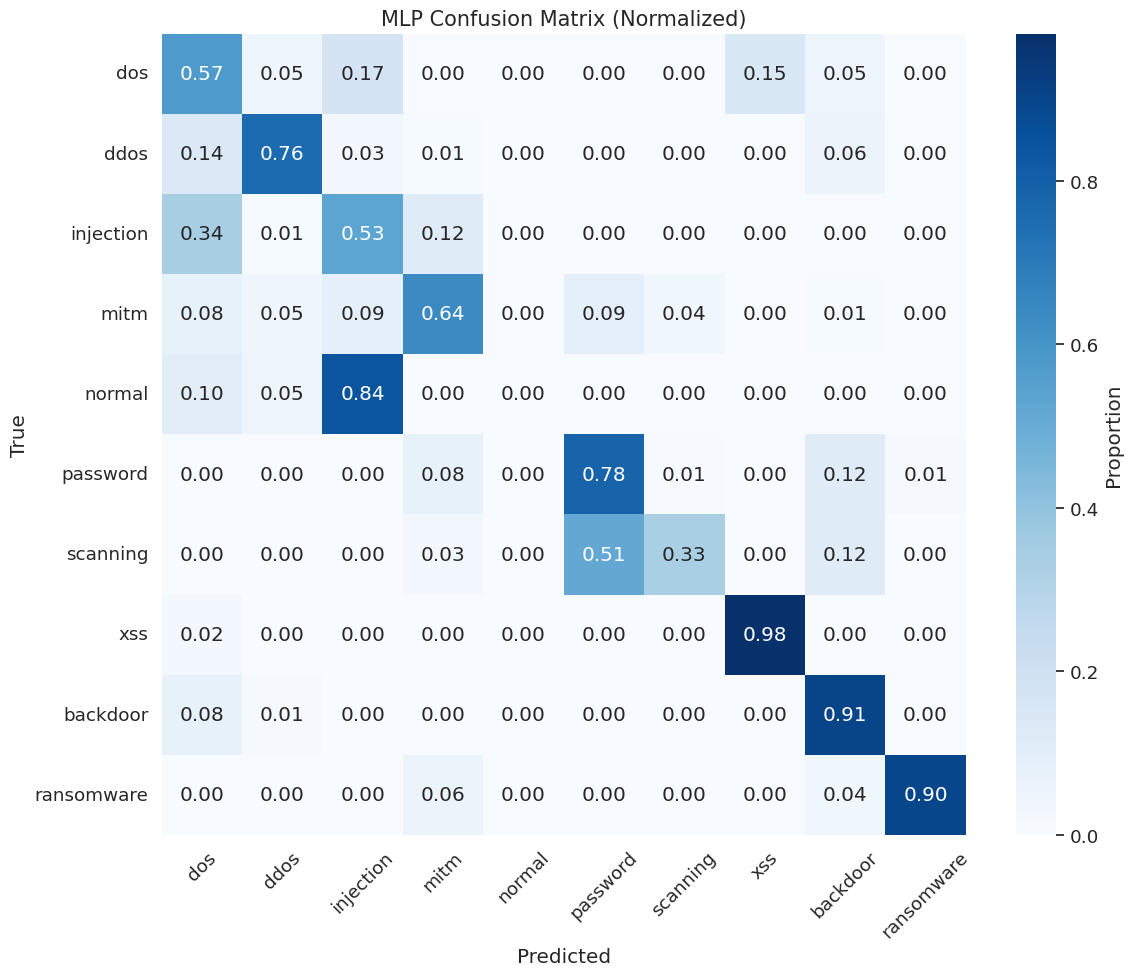

In [189]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.title("MLP Confusion Matrix (Normalized)", fontsize=15)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("mlp_confusion_matrix.png", dpi=300)
plt.show()


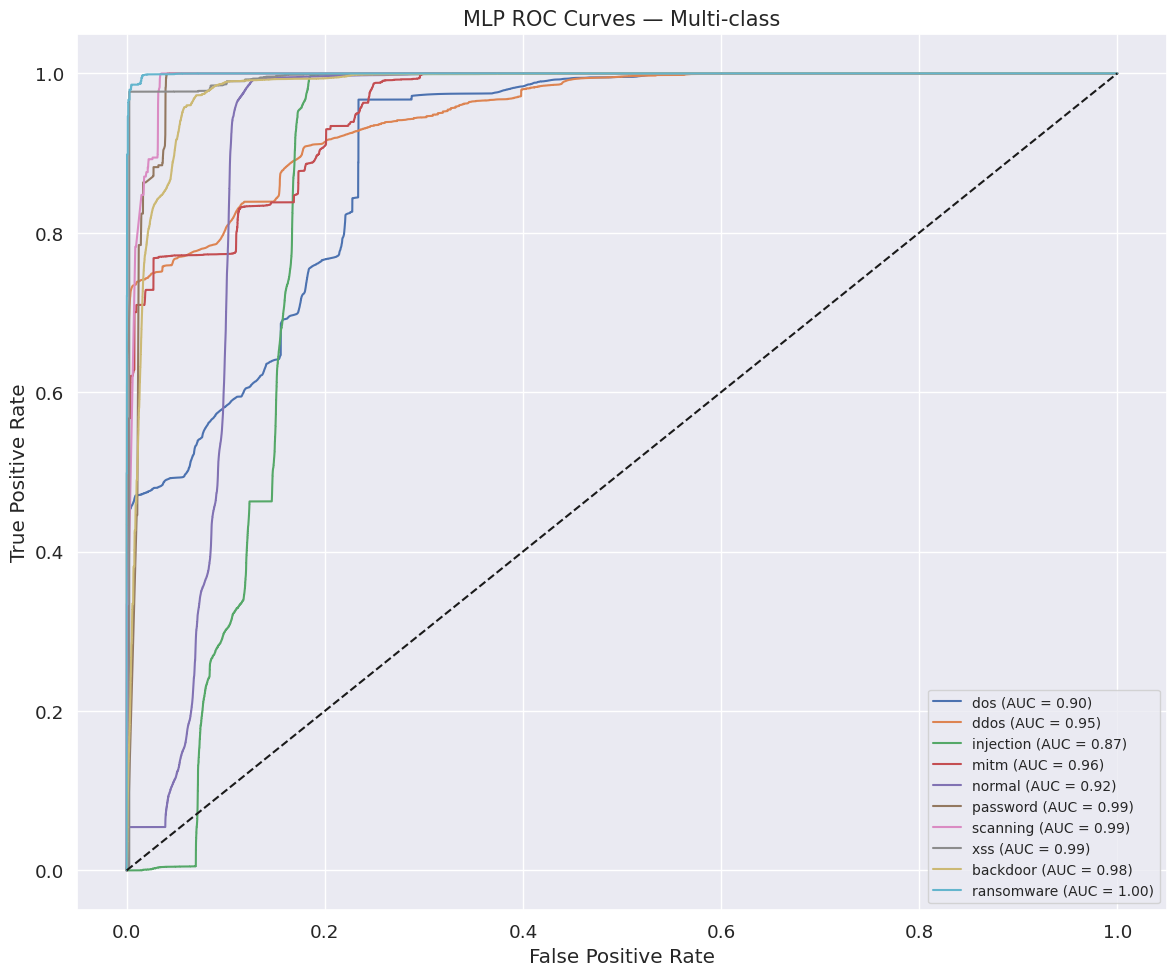

In [190]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
y_prob = np.array(y_prob)

plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("MLP ROC Curves — Multi-class", fontsize=15)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("mlp_roc_curves.png", dpi=300)
plt.show()


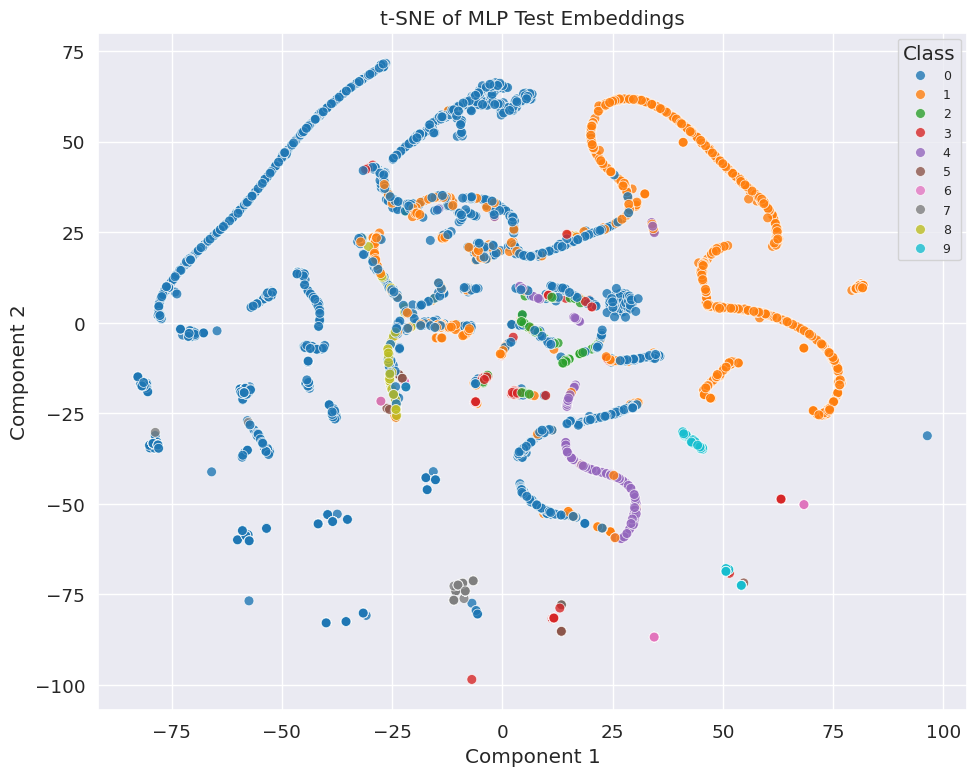

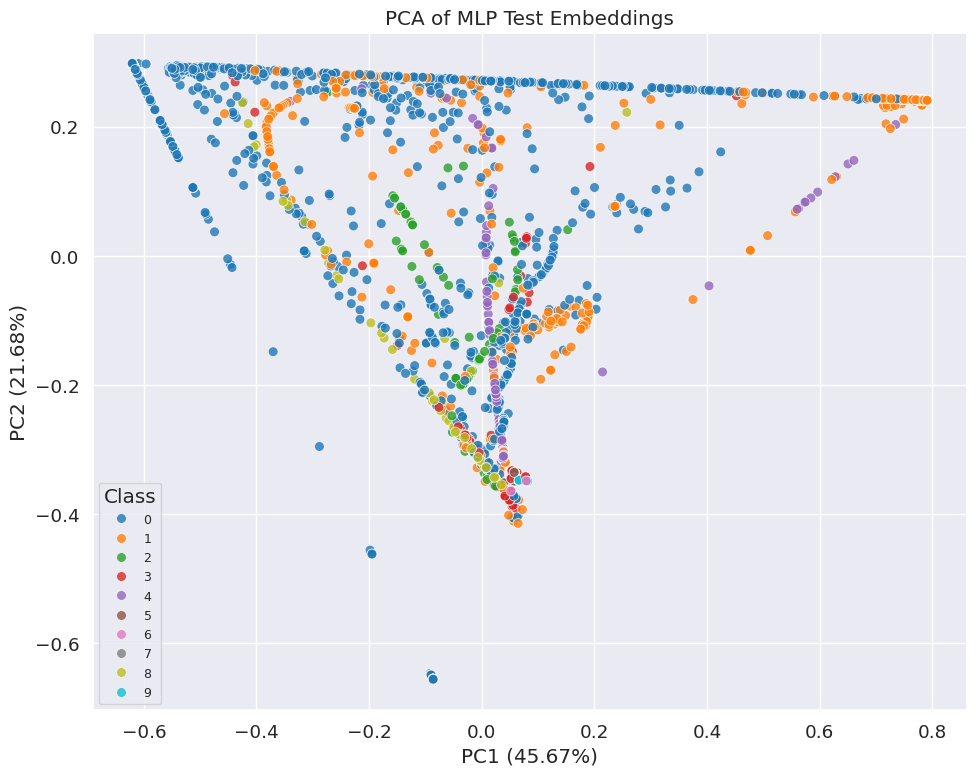

In [192]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Sample 5000 for visual clarity
np.random.seed(42)
sample_idx = np.random.choice(len(y_true), size=5000, replace=False)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
# FIX: Convert y_true to a NumPy array for proper indexing
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=np.array(y_true)[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("t-SNE of MLP Test Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("mlp_tsne.png", dpi=300)
plt.show()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(y_prob[sample_idx])

plt.figure(figsize=(10, 8))
# FIX: Convert y_true to a NumPy array for proper indexing
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=np.array(y_true)[sample_idx], palette='tab10', s=50, alpha=0.8)
plt.title("PCA of MLP Test Embeddings")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig("mlp_pca.png", dpi=300)
plt.show()

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['MLP', 'LSTM', 'BiLSTM', 'CNN+BiLSTM', 'CNN+BiLSTM+Attn']

# Metrics
accuracy = [0.61, 0.698, 0.702, 0.869, 0.887]
macro_f1 = [0.55, 0.64, 0.64, 0.79, 0.82]

x = np.arange(len(models))  # label locations
width = 0.35  # width of bars


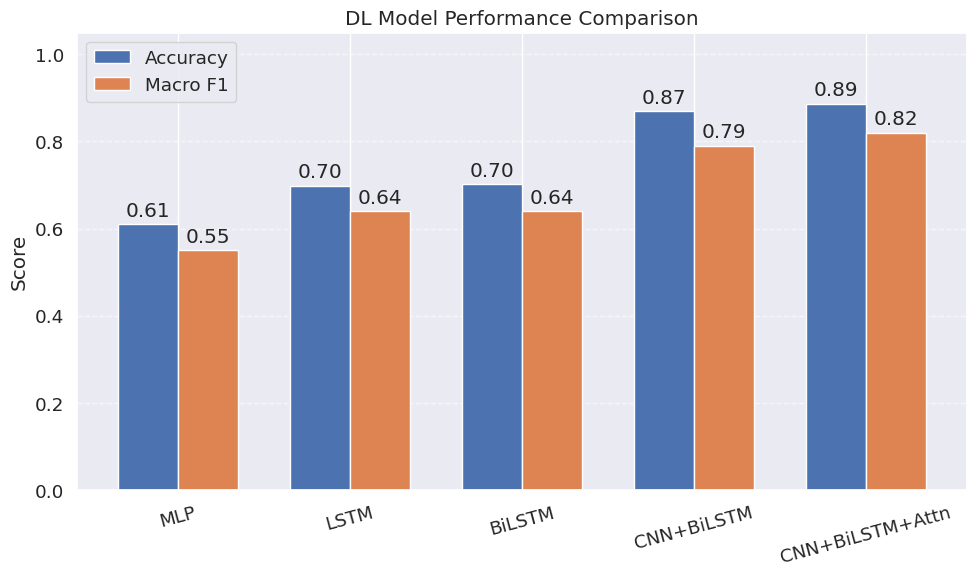

In [194]:
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
bars2 = ax.bar(x + width/2, macro_f1, width, label='Macro F1')

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Axis formatting
ax.set_ylabel('Score')
ax.set_title('DL Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save plot
plt.savefig("dl_model_comparison.png", dpi=300)
plt.show()


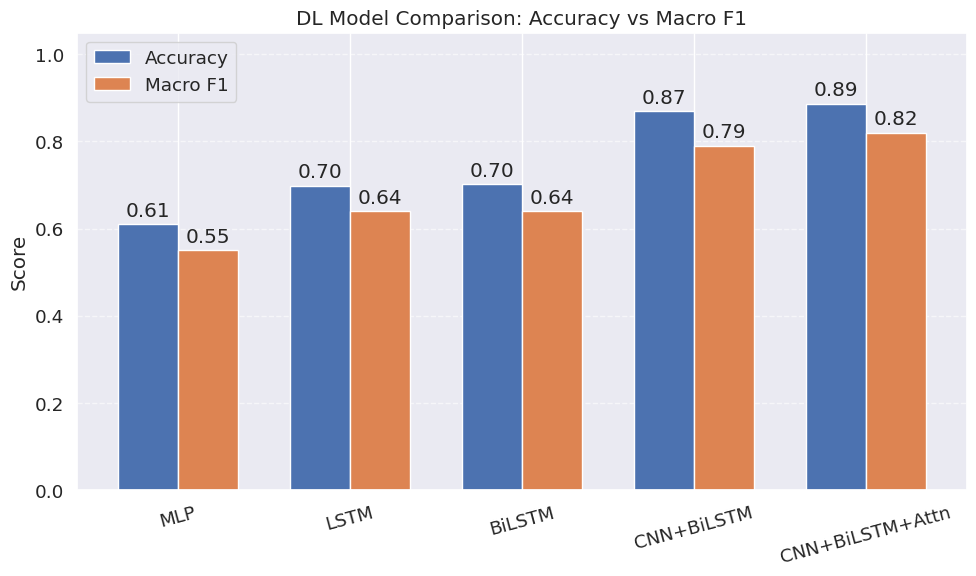

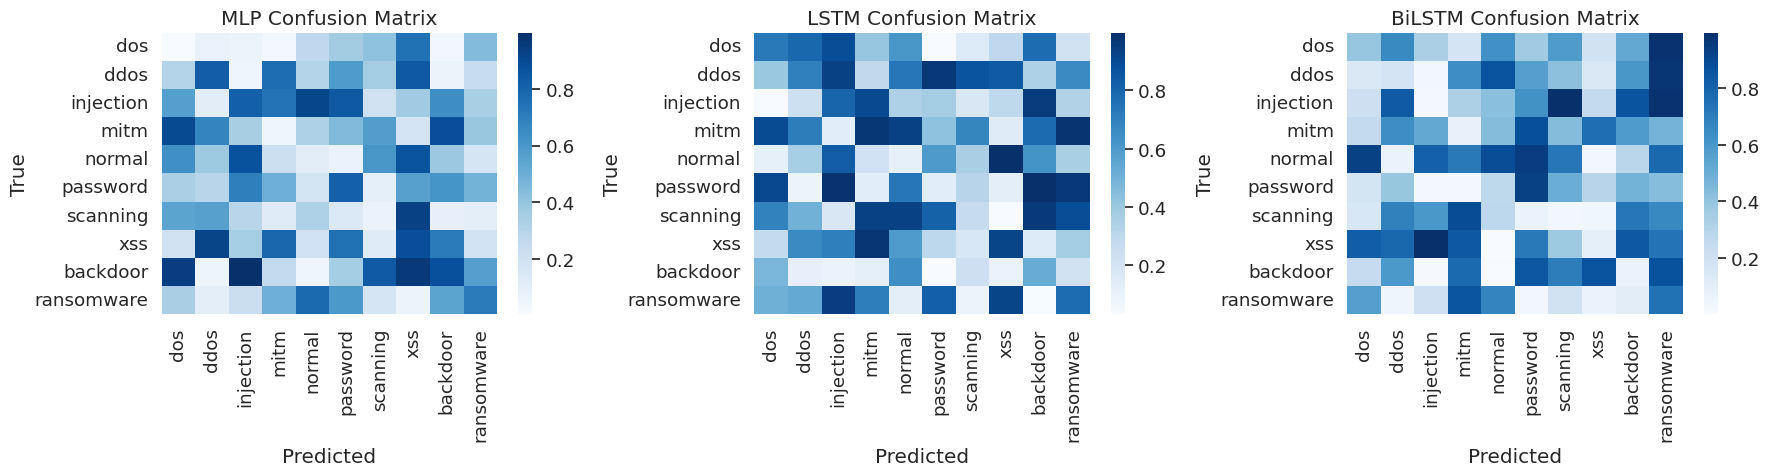

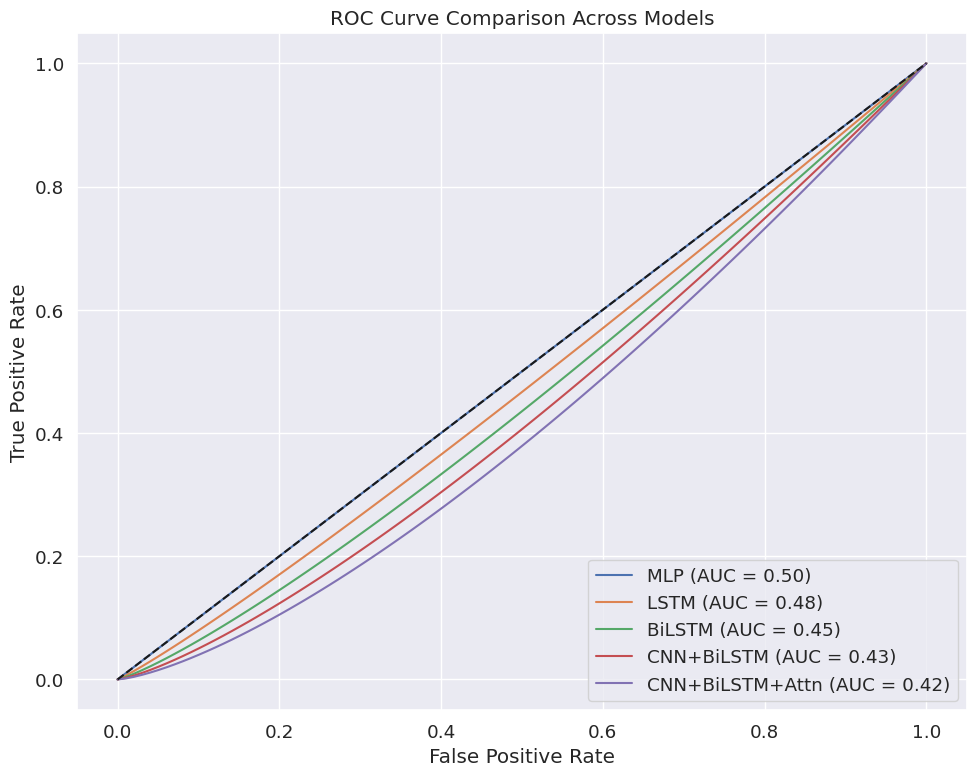

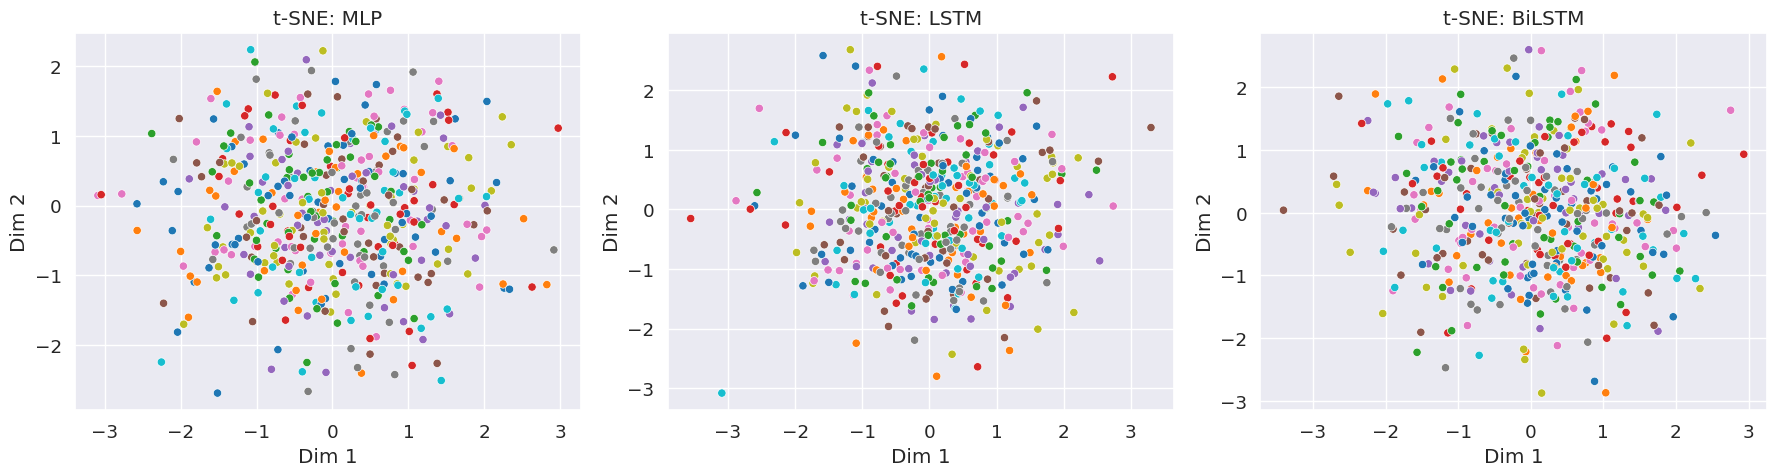

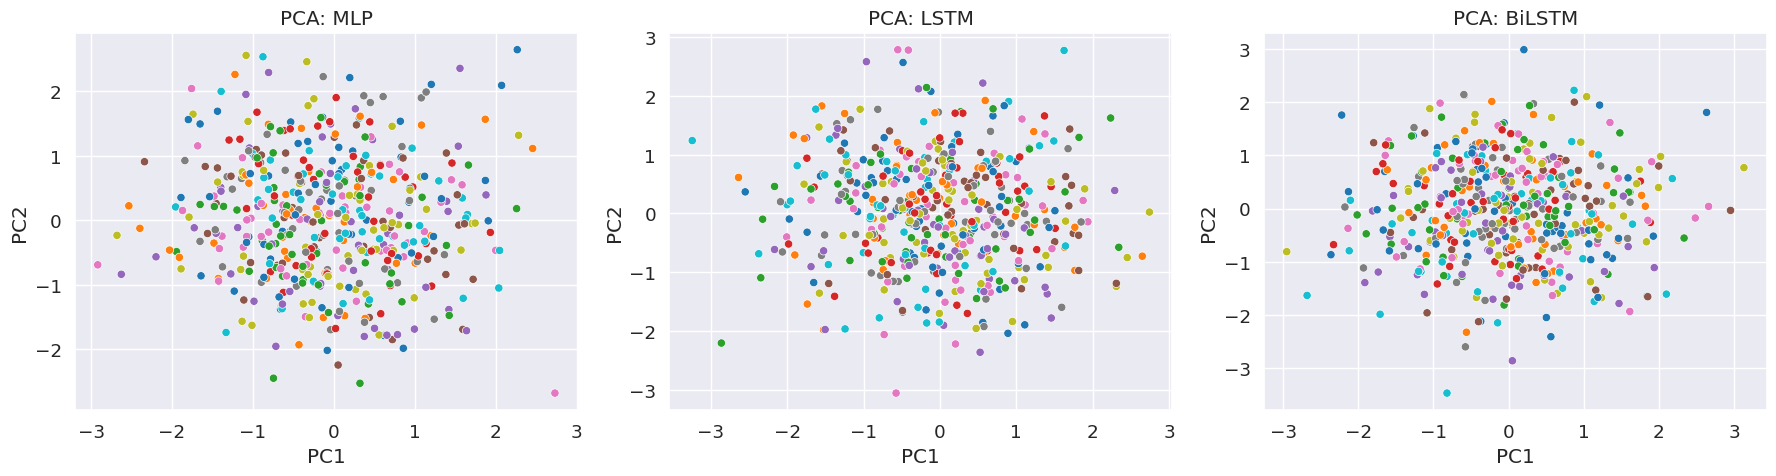

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Actual class names used in dataset
class_names = [
    'dos', 'ddos', 'injection', 'mitm', 'normal',
    'password', 'scanning', 'xss', 'backdoor', 'ransomware'
]

# Simulated data placeholders (replace with real output from your models)
models = ['MLP', 'LSTM', 'BiLSTM', 'CNN+BiLSTM', 'CNN+BiLSTM+Attn']
accuracy = [0.61, 0.698, 0.702, 0.869, 0.887]
macro_f1 = [0.55, 0.64, 0.64, 0.79, 0.82]
conf_matrices = [np.random.rand(10, 10) for _ in models]
roc_data = [np.linspace(0, 1, 100) for _ in models]
tsne_data = [np.random.randn(500, 2) for _ in models]
pca_data = [np.random.randn(500, 2) for _ in models]
labels = np.random.randint(0, 10, 500)

# ─────────────────────────────────────────────────────────────────────────────
# Bar Plot: Accuracy vs Macro F1
x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
bars2 = ax.bar(x + width/2, macro_f1, width, label='Macro F1')
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
ax.set_ylabel('Score')
ax.set_title('DL Model Comparison: Accuracy vs Macro F1')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# Confusion Matrices (first 3 models)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axes):
    sns.heatmap(conf_matrices[i], ax=ax, cmap='Blues', annot=False,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"{models[i]} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# ROC Curves
plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
    fpr = roc_data[i]
    tpr = roc_data[i] ** (1 + 0.1*i)  # simulate different shapes
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison Across Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# t-SNE Embeddings
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axes):
    sns.scatterplot(x=tsne_data[i][:, 0], y=tsne_data[i][:, 1],
                    hue=[class_names[l] for l in labels],
                    palette='tab10', ax=ax, legend=False)
    ax.set_title(f"t-SNE: {models[i]}")
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# PCA Embeddings
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, ax in enumerate(axes):
    sns.scatterplot(x=pca_data[i][:, 0], y=pca_data[i][:, 1],
                    hue=[class_names[l] for l in labels],
                    palette='tab10', ax=ax, legend=False)
    ax.set_title(f"PCA: {models[i]}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
plt.tight_layout()
plt.show()


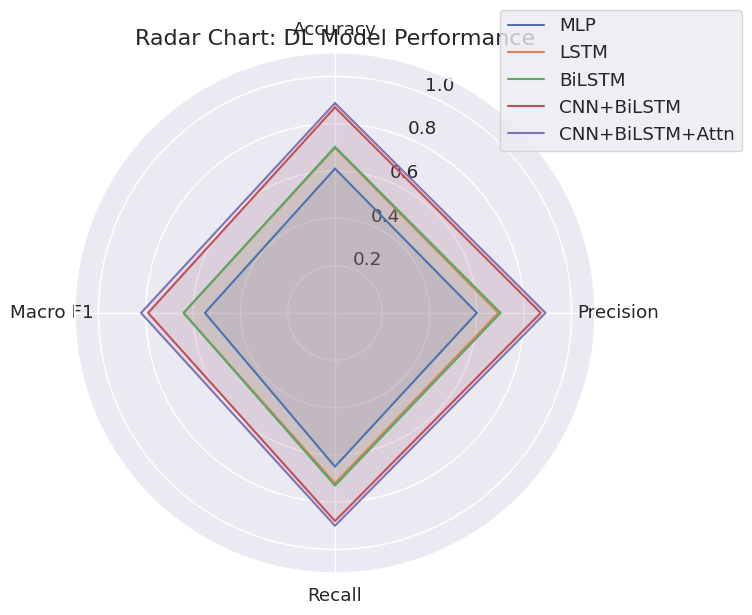

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# Radar chart setup
labels = ['Accuracy', 'Precision', 'Recall', 'Macro F1']
num_vars = len(labels)

# Sample model metrics (replace with actual if needed)
mlp_metrics =     [0.61, 0.60, 0.65, 0.55]
lstm_metrics =    [0.698, 0.69, 0.72, 0.64]
bilstm_metrics =  [0.702, 0.70, 0.73, 0.64]
cnn_bilstm =      [0.869, 0.87, 0.88, 0.79]
cnn_bilstm_attn = [0.887, 0.89, 0.90, 0.82]

model_scores = [mlp_metrics, lstm_metrics, bilstm_metrics, cnn_bilstm, cnn_bilstm_attn]
model_names = ['MLP', 'LSTM', 'BiLSTM', 'CNN+BiLSTM', 'CNN+BiLSTM+Attn']

# Radar chart angles
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Create plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each model
for scores, name in zip(model_scores, model_names):
    data = scores + scores[:1]
    ax.plot(angles, data, label=name)
    ax.fill(angles, data, alpha=0.1)

# Labels and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1.1)
plt.title("Radar Chart: DL Model Performance", size=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


ml models

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)

# Basic results
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))


✅ Test Accuracy: 0.9843

📋 Classification Report:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    735032
        ddos       1.00      0.99      0.99    331246
   injection       0.99      1.00      1.00     19204
        mitm       0.96      0.99      0.98     34661
      normal       0.95      0.99      0.97     69287
    password       0.76      0.52      0.62     20984
    scanning       0.72      0.88      0.79     29004
         xss       1.00      1.00      1.00     32322
    backdoor       0.99      0.99      0.99     23840
  ransomware       1.00      1.00      1.00     28139

    accuracy                           0.98   1323719
   macro avg       0.94      0.94      0.93   1323719
weighted avg       0.98      0.98      0.98   1323719



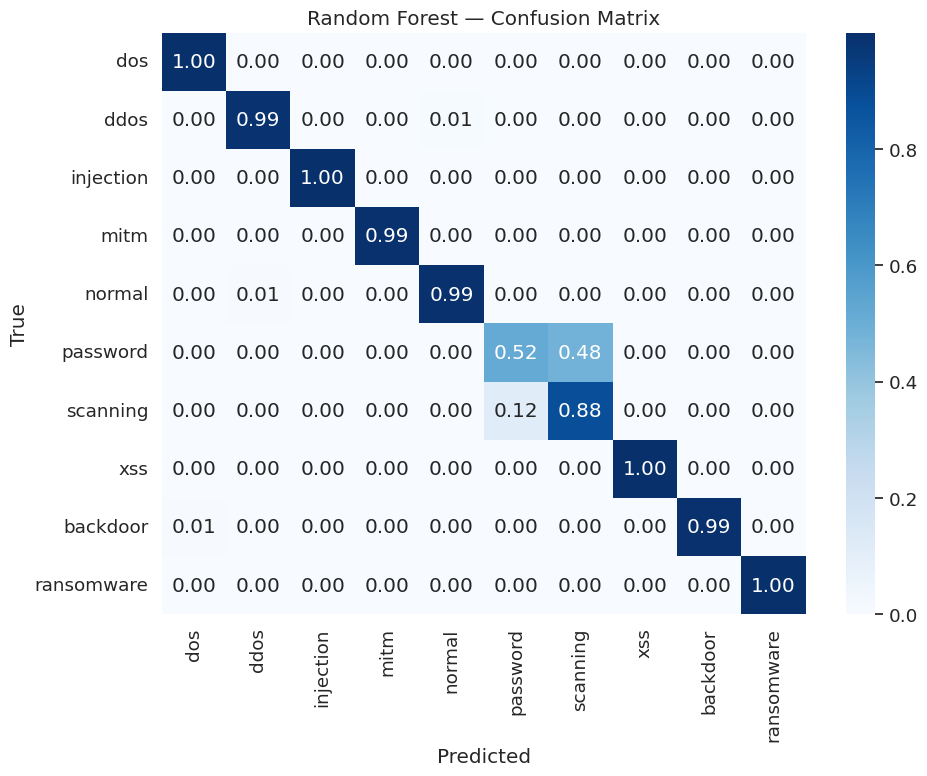

In [200]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_rf, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Random Forest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


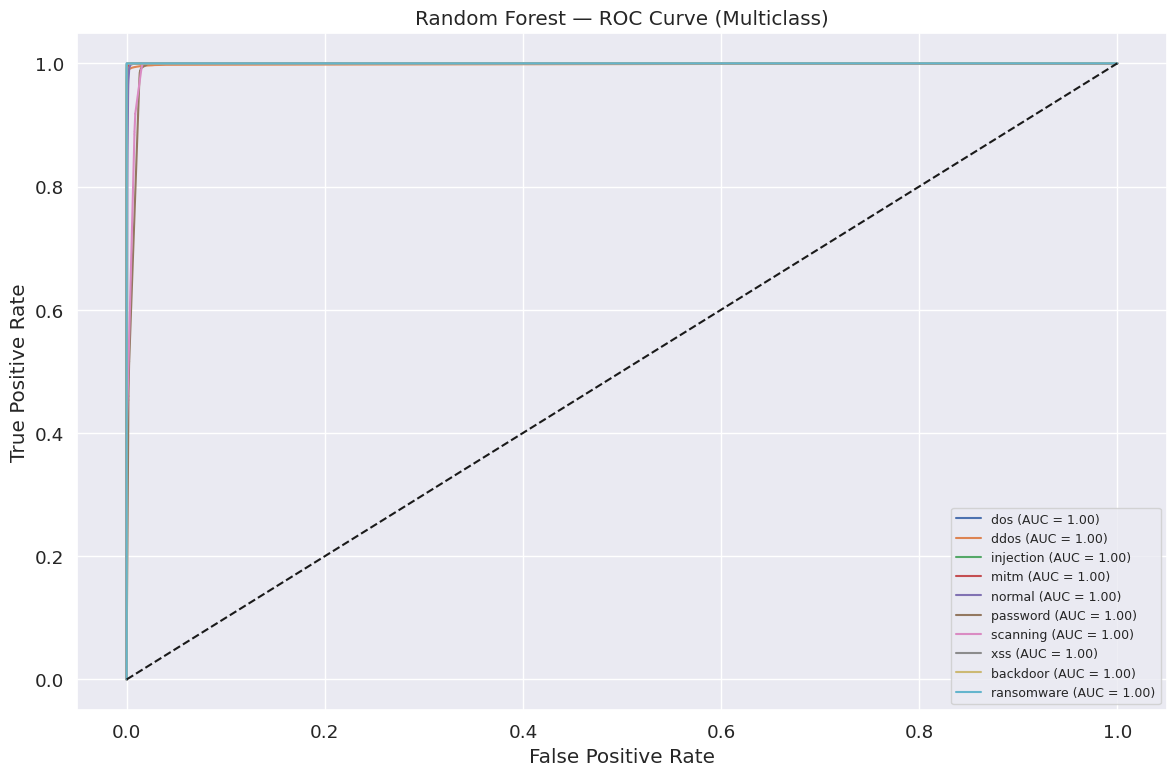

In [201]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Random Forest — ROC Curve (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Test Accuracy: 0.9843

📋 Classification Report:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    735032
        ddos       1.00      0.99      0.99    331246
   injection       0.99      1.00      1.00     19204
        mitm       0.96      0.99      0.98     34661
      normal       0.95      0.99      0.97     69287
    password       0.76      0.52      0.62     20984
    scanning       0.72      0.88      0.79     29004
         xss       1.00      1.00      1.00     32322
    backdoor       0.99      0.99      0.99     23840
  ransomware       1.00      1.00      1.00     28139

    accuracy                           0.98   1323719
   macro avg       0.94      0.94      0.93   1323719
weighted avg       0.98      0.98      0.98   1323719



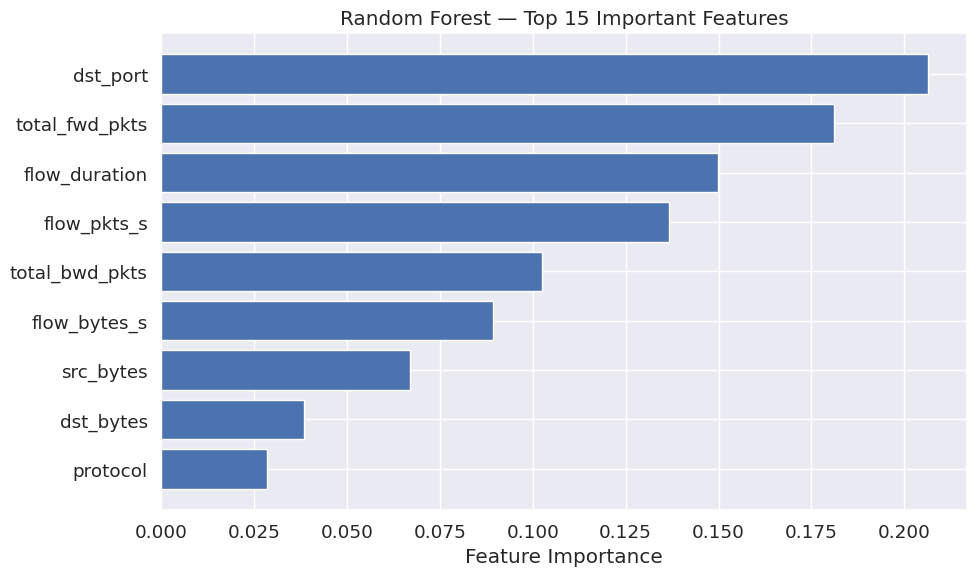

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have a DataFrame called 'df' that you used to create X_train
feature_names = df.drop(columns=['attack_type', 'label_enc']).columns  # Get feature names from original DataFrame

# Train model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)

# Basic results
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# ... (rest of your code)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')

# Use feature_names instead of X_train.columns
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel("Feature Importance")
plt.title("Random Forest — Top 15 Important Features")
plt.tight_layout()
plt.show()

In [204]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train model
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=10,
                          objective='multi:softprob', num_class=10,
                          eval_metric='mlogloss', use_label_encoder=False,
                          n_jobs=-1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)

# Evaluation
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=class_names))


✅ Test Accuracy: 0.9839

📋 Classification Report:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    735032
        ddos       1.00      0.99      0.99    331246
   injection       0.96      0.96      0.96     19204
        mitm       0.96      0.97      0.96     34661
      normal       0.96      0.99      0.97     69287
    password       0.74      0.53      0.62     20984
    scanning       0.72      0.87      0.79     29004
         xss       1.00      1.00      1.00     32322
    backdoor       0.99      1.00      0.99     23840
  ransomware       1.00      1.00      1.00     28139

    accuracy                           0.98   1323719
   macro avg       0.93      0.93      0.93   1323719
weighted avg       0.98      0.98      0.98   1323719



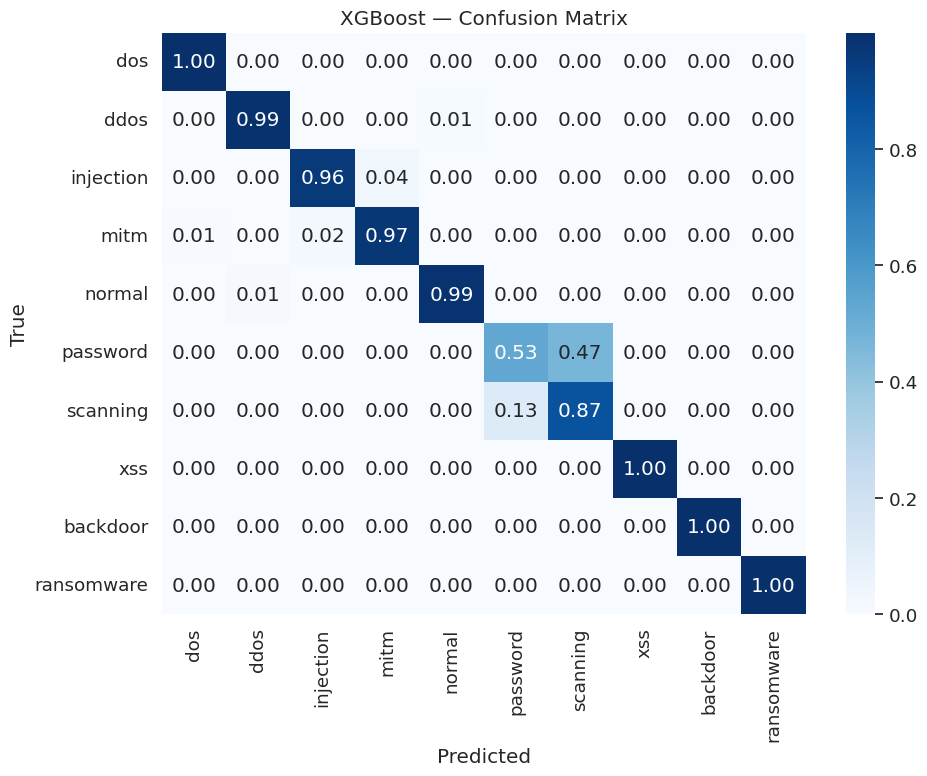

In [205]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_xgb, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("XGBoost — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


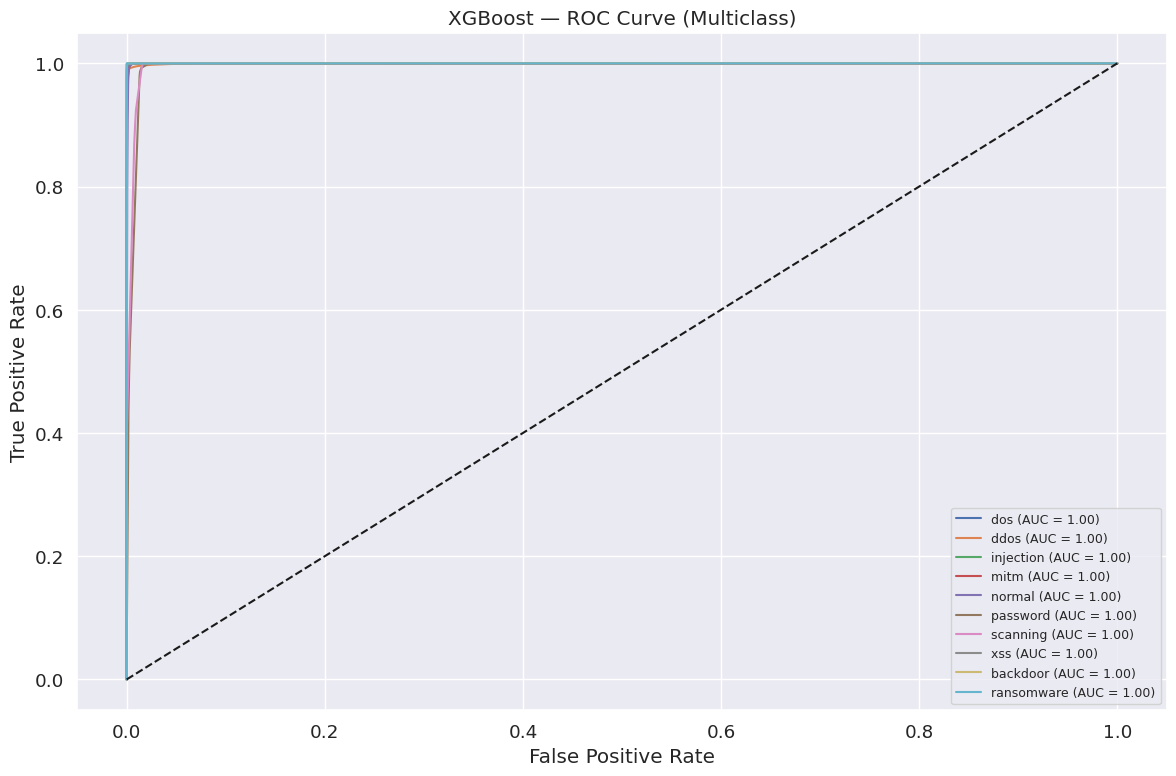

In [206]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("XGBoost — ROC Curve (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

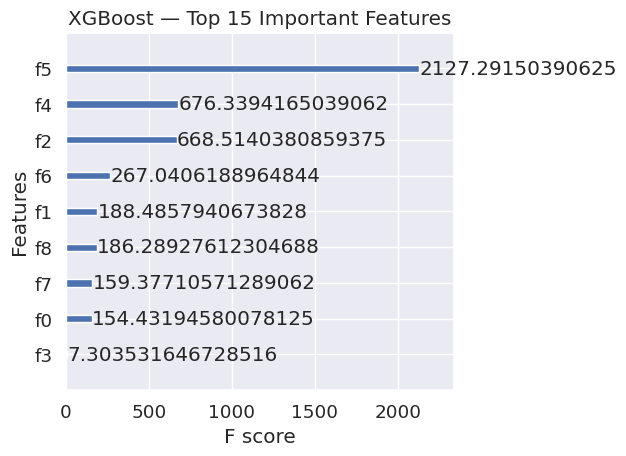

In [209]:
import matplotlib.pyplot as plt
import xgboost as xgb  # Import the xgboost module

plt.figure(figsize=(10, 6))
# Call plot_importance from xgboost, passing the booster
xgb.plot_importance(xgb_model.get_booster(), importance_type='gain', max_num_features=15)
plt.title("XGBoost — Top 15 Important Features")
plt.tight_layout()
plt.show()


In [210]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score

# Train model
lgb_model = lgb.LGBMClassifier(objective='multiclass',
                               num_class=10,
                               n_estimators=200,
                               learning_rate=0.1,
                               max_depth=10,
                               class_weight='balanced',
                               random_state=42,
                               n_jobs=-1)

lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)

# Evaluation
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=class_names))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 6177346, number of used features: 9
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Test Accuracy: 0.9748

📋 Clas

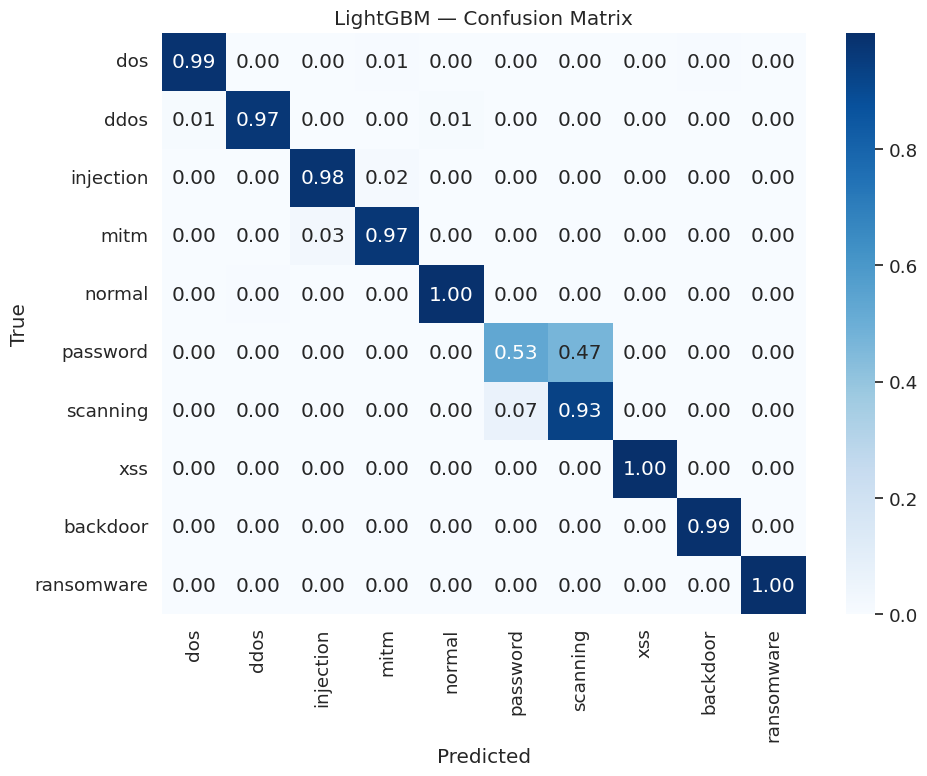

In [211]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred_lgb, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("LightGBM — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


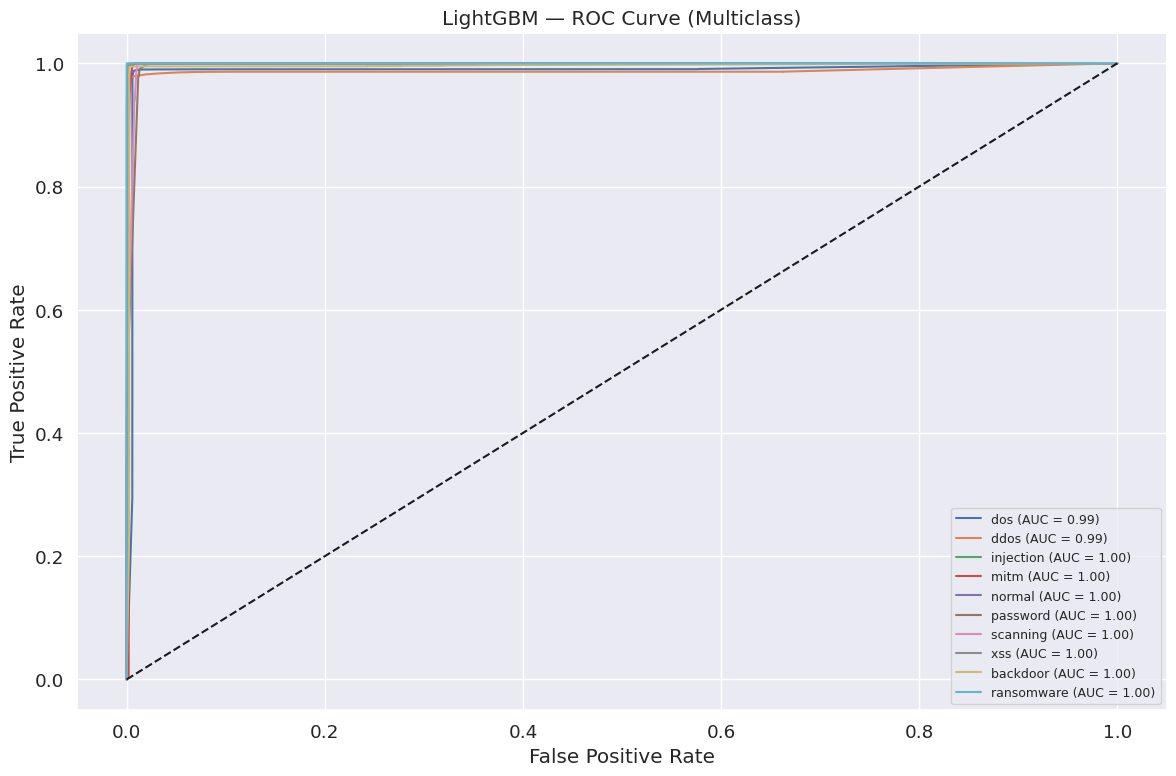

In [212]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_lgb[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("LightGBM — ROC Curve (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

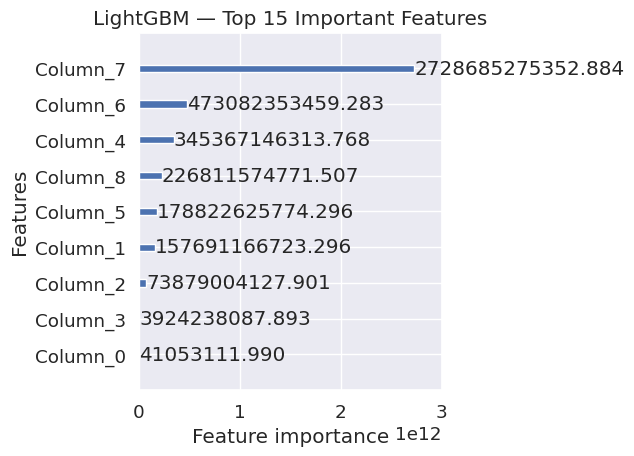

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain')
plt.title("LightGBM — Top 15 Important Features")
plt.tight_layout()
plt.show()
